In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'

config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])

dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

dataset = get_dataset(dataset_dir,
                                     'validation',
                                     config.batch_size,
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

env = RetinaEnv(config, image_generator=dataset)

if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound

# You might want to adjust the hyperparameters
actor_lr = 0.0001
critic_lr = 0.001
gamma = 0.99
tau = 0.005

buffer_capacity = 10000



# Create actor and critic networks
actor_model = create_actor_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)
critic_model = create_critic_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)

# Create target actor and critic networks
target_actor = create_actor_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)
target_critic = create_critic_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# Experience replay buffer
buffer = Buffer(buffer_capacity, config.batch_size, num_states=num_states, num_actions=num_actions,
                state_reshape_fn=env.unflatten_observation)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [2]:
# Training loop
reward_records = []
epsilon_records = []

episodes = 10000
for ep in range(episodes):
    prev_state = env.reset()
    episodic_reward = 0
    epsilon = epsilon_scheduler(ep, floor_episode=1000)

    while True:
        # tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        
        deterministic_action = policy(env.unflatten_observation(prev_state), actor_model, lower_bound, upper_bound)
        random_action = -2+4*np.random.uniform(size=(config.batch_size,2))

        if env.warmup_done:
            action = epsilon*random_action + (1-epsilon)*deterministic_action
        else:
            action = random_action

        # Recieve state and reward from environment
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            buffer.record((prev_state, action, reward, state))
            episodic_reward += reward

            buffer.learn(actor_model, target_actor, critic_model, target_critic, actor_optimizer, critic_optimizer, gamma, tau)
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)
        # End this episode when `done` is True
        if done:
            break

        #prev_state = state avoid assingment by reference:
        prev_state = np.copy(state)
#         print('debug action: ', action[0])

    print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    reward_records.append(episodic_reward.numpy().mean())
    epsilon_records.append(epsilon)

Episode * 0 * exploration epsilon 1.0 * Episodic Reward is ==> -9.598966598510742
Episode * 1 * exploration epsilon 0.9991 * Episodic Reward is ==> -8.283880233764648
Episode * 2 * exploration epsilon 0.9982 * Episodic Reward is ==> -9.621528625488281
Episode * 3 * exploration epsilon 0.9973 * Episodic Reward is ==> -8.712477684020996
Episode * 4 * exploration epsilon 0.9964 * Episodic Reward is ==> -9.848198890686035
Episode * 5 * exploration epsilon 0.9955 * Episodic Reward is ==> -10.023272514343262
Episode * 6 * exploration epsilon 0.9946 * Episodic Reward is ==> -9.797992706298828
Episode * 7 * exploration epsilon 0.9937 * Episodic Reward is ==> -9.850050926208496
Episode * 8 * exploration epsilon 0.9928 * Episodic Reward is ==> -9.329944610595703
Episode * 9 * exploration epsilon 0.9919 * Episodic Reward is ==> -9.497520446777344
Episode * 10 * exploration epsilon 0.991 * Episodic Reward is ==> -10.178903579711914
Episode * 11 * exploration epsilon 0.9901 * Episodic Reward is ==>

Episode * 24 * exploration epsilon 0.9784 * Episodic Reward is ==> -9.242391586303711
Episode * 25 * exploration epsilon 0.9775 * Episodic Reward is ==> -10.117837905883789
Episode * 26 * exploration epsilon 0.9766 * Episodic Reward is ==> -9.755115509033203
Episode * 27 * exploration epsilon 0.9757 * Episodic Reward is ==> -8.525712966918945
Episode * 28 * exploration epsilon 0.9748 * Episodic Reward is ==> -10.59376049041748
Episode * 29 * exploration epsilon 0.9739 * Episodic Reward is ==> -8.918436050415039
Episode * 30 * exploration epsilon 0.973 * Episodic Reward is ==> -8.332381248474121
Episode * 31 * exploration epsilon 0.9721 * Episodic Reward is ==> -11.256507873535156
Episode * 32 * exploration epsilon 0.9712 * Episodic Reward is ==> -9.6190185546875
Episode * 33 * exploration epsilon 0.9703 * Episodic Reward is ==> -7.963829517364502
Episode * 34 * exploration epsilon 0.9694 * Episodic Reward is ==> -9.548091888427734
Episode * 35 * exploration epsilon 0.9685 * Episodic Re

Episode * 48 * exploration epsilon 0.9568 * Episodic Reward is ==> -9.275491714477539
Episode * 49 * exploration epsilon 0.9559 * Episodic Reward is ==> -9.38125228881836
Episode * 50 * exploration epsilon 0.955 * Episodic Reward is ==> -9.65493392944336
Episode * 51 * exploration epsilon 0.9541 * Episodic Reward is ==> -8.786327362060547
Episode * 52 * exploration epsilon 0.9532 * Episodic Reward is ==> -9.771768569946289
Episode * 53 * exploration epsilon 0.9523 * Episodic Reward is ==> -8.931575775146484
Episode * 54 * exploration epsilon 0.9514 * Episodic Reward is ==> -9.036518096923828
Episode * 55 * exploration epsilon 0.9505 * Episodic Reward is ==> -9.127622604370117
Episode * 56 * exploration epsilon 0.9496 * Episodic Reward is ==> -9.129926681518555
Episode * 57 * exploration epsilon 0.9487 * Episodic Reward is ==> -8.543153762817383
Episode * 58 * exploration epsilon 0.9478 * Episodic Reward is ==> -9.725323677062988
Episode * 59 * exploration epsilon 0.9469 * Episodic Rewa

Episode * 72 * exploration epsilon 0.9352 * Episodic Reward is ==> -10.260068893432617
Episode * 73 * exploration epsilon 0.9343 * Episodic Reward is ==> -8.108816146850586
Episode * 74 * exploration epsilon 0.9334 * Episodic Reward is ==> -8.03054141998291
Episode * 75 * exploration epsilon 0.9325 * Episodic Reward is ==> -9.644380569458008
Episode * 76 * exploration epsilon 0.9316 * Episodic Reward is ==> -8.319336891174316
Episode * 77 * exploration epsilon 0.9307 * Episodic Reward is ==> -10.376784324645996
Episode * 78 * exploration epsilon 0.9298 * Episodic Reward is ==> -9.439957618713379
Episode * 79 * exploration epsilon 0.9289 * Episodic Reward is ==> -9.03019905090332
Episode * 80 * exploration epsilon 0.928 * Episodic Reward is ==> -8.374531745910645
Episode * 81 * exploration epsilon 0.9271 * Episodic Reward is ==> -8.526544570922852
Episode * 82 * exploration epsilon 0.9262 * Episodic Reward is ==> -9.470894813537598
Episode * 83 * exploration epsilon 0.9253 * Episodic Re

Episode * 96 * exploration epsilon 0.9136 * Episodic Reward is ==> -8.11330509185791
Episode * 97 * exploration epsilon 0.9127 * Episodic Reward is ==> -8.847909927368164
Episode * 98 * exploration epsilon 0.9117999999999999 * Episodic Reward is ==> -8.208597183227539
Episode * 99 * exploration epsilon 0.9109 * Episodic Reward is ==> -8.977587699890137
Episode * 100 * exploration epsilon 0.91 * Episodic Reward is ==> -9.788359642028809
Episode * 101 * exploration epsilon 0.9091 * Episodic Reward is ==> -9.816468238830566
Episode * 102 * exploration epsilon 0.9082 * Episodic Reward is ==> -9.146692276000977
Episode * 103 * exploration epsilon 0.9073 * Episodic Reward is ==> -7.775561809539795
Episode * 104 * exploration epsilon 0.9064 * Episodic Reward is ==> -8.650959968566895
Episode * 105 * exploration epsilon 0.9055 * Episodic Reward is ==> -9.715359687805176
Episode * 106 * exploration epsilon 0.9046 * Episodic Reward is ==> -8.645671844482422
Episode * 107 * exploration epsilon 0.

Episode * 120 * exploration epsilon 0.892 * Episodic Reward is ==> -8.521240234375
Episode * 121 * exploration epsilon 0.8911 * Episodic Reward is ==> -9.13840389251709
Episode * 122 * exploration epsilon 0.8902 * Episodic Reward is ==> -8.961630821228027
Episode * 123 * exploration epsilon 0.8893 * Episodic Reward is ==> -10.550283432006836
Episode * 124 * exploration epsilon 0.8884 * Episodic Reward is ==> -9.309910774230957
Episode * 125 * exploration epsilon 0.8875 * Episodic Reward is ==> -9.713038444519043
Episode * 126 * exploration epsilon 0.8866 * Episodic Reward is ==> -8.703327178955078
Episode * 127 * exploration epsilon 0.8857 * Episodic Reward is ==> -8.924541473388672
Episode * 128 * exploration epsilon 0.8848 * Episodic Reward is ==> -8.4761962890625
Episode * 129 * exploration epsilon 0.8839 * Episodic Reward is ==> -8.075237274169922
Episode * 130 * exploration epsilon 0.883 * Episodic Reward is ==> -9.051040649414062
Episode * 131 * exploration epsilon 0.8821 * Episo

Episode * 144 * exploration epsilon 0.8704000000000001 * Episodic Reward is ==> -8.147411346435547
Episode * 145 * exploration epsilon 0.8694999999999999 * Episodic Reward is ==> -9.212899208068848
Episode * 146 * exploration epsilon 0.8686 * Episodic Reward is ==> -7.281647682189941
Episode * 147 * exploration epsilon 0.8677 * Episodic Reward is ==> -8.48556900024414
Episode * 148 * exploration epsilon 0.8668 * Episodic Reward is ==> -10.534296035766602
Episode * 149 * exploration epsilon 0.8659 * Episodic Reward is ==> -8.217423439025879
Episode * 150 * exploration epsilon 0.865 * Episodic Reward is ==> -9.602094650268555
Episode * 151 * exploration epsilon 0.8641 * Episodic Reward is ==> -10.004942893981934
Episode * 152 * exploration epsilon 0.8632 * Episodic Reward is ==> -10.052141189575195
Episode * 153 * exploration epsilon 0.8623 * Episodic Reward is ==> -8.171979904174805
Episode * 154 * exploration epsilon 0.8613999999999999 * Episodic Reward is ==> -8.54704475402832
Episode

Episode * 168 * exploration epsilon 0.8488 * Episodic Reward is ==> -8.945059776306152
Episode * 169 * exploration epsilon 0.8479 * Episodic Reward is ==> -9.007085800170898
Episode * 170 * exploration epsilon 0.847 * Episodic Reward is ==> -9.396371841430664
Episode * 171 * exploration epsilon 0.8461 * Episodic Reward is ==> -8.921711921691895
Episode * 172 * exploration epsilon 0.8452 * Episodic Reward is ==> -8.84516716003418
Episode * 173 * exploration epsilon 0.8443 * Episodic Reward is ==> -9.088959693908691
Episode * 174 * exploration epsilon 0.8434 * Episodic Reward is ==> -10.12165641784668
Episode * 175 * exploration epsilon 0.8425 * Episodic Reward is ==> -10.285978317260742
Episode * 176 * exploration epsilon 0.8416 * Episodic Reward is ==> -8.630426406860352
Episode * 177 * exploration epsilon 0.8407 * Episodic Reward is ==> -8.990555763244629
Episode * 178 * exploration epsilon 0.8398 * Episodic Reward is ==> -10.879207611083984
Episode * 179 * exploration epsilon 0.8389 

Episode * 192 * exploration epsilon 0.8271999999999999 * Episodic Reward is ==> -9.522394180297852
Episode * 193 * exploration epsilon 0.8263 * Episodic Reward is ==> -9.040771484375
Episode * 194 * exploration epsilon 0.8254 * Episodic Reward is ==> -10.121139526367188
Episode * 195 * exploration epsilon 0.8245 * Episodic Reward is ==> -8.357542991638184
Episode * 196 * exploration epsilon 0.8236 * Episodic Reward is ==> -9.413434982299805
Episode * 197 * exploration epsilon 0.8227 * Episodic Reward is ==> -8.1386079788208
Episode * 198 * exploration epsilon 0.8218 * Episodic Reward is ==> -8.773751258850098
Episode * 199 * exploration epsilon 0.8209 * Episodic Reward is ==> -8.744672775268555
Episode * 200 * exploration epsilon 0.8200000000000001 * Episodic Reward is ==> -9.126462936401367
Episode * 201 * exploration epsilon 0.8190999999999999 * Episodic Reward is ==> -9.612247467041016
Episode * 202 * exploration epsilon 0.8182 * Episodic Reward is ==> -7.328859329223633
Episode * 2

Episode * 216 * exploration epsilon 0.8056 * Episodic Reward is ==> -8.490194320678711
Episode * 217 * exploration epsilon 0.8047 * Episodic Reward is ==> -8.358026504516602
Episode * 218 * exploration epsilon 0.8038 * Episodic Reward is ==> -8.060075759887695
Episode * 219 * exploration epsilon 0.8029 * Episodic Reward is ==> -9.470924377441406
Episode * 220 * exploration epsilon 0.802 * Episodic Reward is ==> -9.592772483825684
Episode * 221 * exploration epsilon 0.8011 * Episodic Reward is ==> -9.105634689331055
Episode * 222 * exploration epsilon 0.8002 * Episodic Reward is ==> -9.491166114807129
Episode * 223 * exploration epsilon 0.7993 * Episodic Reward is ==> -9.191550254821777
Episode * 224 * exploration epsilon 0.7984 * Episodic Reward is ==> -9.501626968383789
Episode * 225 * exploration epsilon 0.7975 * Episodic Reward is ==> -7.648407936096191
Episode * 226 * exploration epsilon 0.7966 * Episodic Reward is ==> -8.703977584838867
Episode * 227 * exploration epsilon 0.7957 *

Episode * 240 * exploration epsilon 0.784 * Episodic Reward is ==> -8.430874824523926
Episode * 241 * exploration epsilon 0.7831 * Episodic Reward is ==> -7.517312526702881
Episode * 242 * exploration epsilon 0.7822 * Episodic Reward is ==> -9.306193351745605
Episode * 243 * exploration epsilon 0.7813 * Episodic Reward is ==> -8.820844650268555
Episode * 244 * exploration epsilon 0.7804 * Episodic Reward is ==> -9.06797981262207
Episode * 245 * exploration epsilon 0.7795 * Episodic Reward is ==> -8.055194854736328
Episode * 246 * exploration epsilon 0.7786 * Episodic Reward is ==> -10.112077713012695
Episode * 247 * exploration epsilon 0.7777000000000001 * Episodic Reward is ==> -9.427376747131348
Episode * 248 * exploration epsilon 0.7767999999999999 * Episodic Reward is ==> -9.483240127563477
Episode * 249 * exploration epsilon 0.7759 * Episodic Reward is ==> -8.66282844543457
Episode * 250 * exploration epsilon 0.775 * Episodic Reward is ==> -9.127982139587402
Episode * 251 * explor

Episode * 264 * exploration epsilon 0.7624 * Episodic Reward is ==> -8.604588508605957
Episode * 265 * exploration epsilon 0.7615000000000001 * Episodic Reward is ==> -9.441339492797852
Episode * 266 * exploration epsilon 0.7605999999999999 * Episodic Reward is ==> -10.273333549499512
Episode * 267 * exploration epsilon 0.7597 * Episodic Reward is ==> -8.32725715637207
Episode * 268 * exploration epsilon 0.7587999999999999 * Episodic Reward is ==> -9.060211181640625
Episode * 269 * exploration epsilon 0.7579 * Episodic Reward is ==> -8.81673812866211
Episode * 270 * exploration epsilon 0.757 * Episodic Reward is ==> -9.191707611083984
Episode * 271 * exploration epsilon 0.7561 * Episodic Reward is ==> -9.531183242797852
Episode * 272 * exploration epsilon 0.7552 * Episodic Reward is ==> -7.994502067565918
Episode * 273 * exploration epsilon 0.7543 * Episodic Reward is ==> -9.84115219116211
Episode * 274 * exploration epsilon 0.7534000000000001 * Episodic Reward is ==> -9.10791397094726

Episode * 288 * exploration epsilon 0.7408 * Episodic Reward is ==> -8.185419082641602
Episode * 289 * exploration epsilon 0.7399 * Episodic Reward is ==> -7.669648170471191
Episode * 290 * exploration epsilon 0.739 * Episodic Reward is ==> -10.976466178894043
Episode * 291 * exploration epsilon 0.7381 * Episodic Reward is ==> -8.91035270690918
Episode * 292 * exploration epsilon 0.7372 * Episodic Reward is ==> -11.056787490844727
Episode * 293 * exploration epsilon 0.7363 * Episodic Reward is ==> -9.75703239440918
Episode * 294 * exploration epsilon 0.7354 * Episodic Reward is ==> -9.634207725524902
Episode * 295 * exploration epsilon 0.7344999999999999 * Episodic Reward is ==> -7.926268100738525
Episode * 296 * exploration epsilon 0.7336 * Episodic Reward is ==> -8.529167175292969
Episode * 297 * exploration epsilon 0.7326999999999999 * Episodic Reward is ==> -8.511643409729004
Episode * 298 * exploration epsilon 0.7318 * Episodic Reward is ==> -8.770349502563477
Episode * 299 * expl

Episode * 312 * exploration epsilon 0.7192000000000001 * Episodic Reward is ==> -8.824372291564941
Episode * 313 * exploration epsilon 0.7182999999999999 * Episodic Reward is ==> -8.4664306640625
Episode * 314 * exploration epsilon 0.7174 * Episodic Reward is ==> -7.820199012756348
Episode * 315 * exploration epsilon 0.7165 * Episodic Reward is ==> -7.8625168800354
Episode * 316 * exploration epsilon 0.7156 * Episodic Reward is ==> -9.411619186401367
Episode * 317 * exploration epsilon 0.7147 * Episodic Reward is ==> -8.274707794189453
Episode * 318 * exploration epsilon 0.7138 * Episodic Reward is ==> -8.379938125610352
Episode * 319 * exploration epsilon 0.7129 * Episodic Reward is ==> -8.154984474182129
Episode * 320 * exploration epsilon 0.712 * Episodic Reward is ==> -8.094928741455078
Episode * 321 * exploration epsilon 0.7111 * Episodic Reward is ==> -9.586986541748047
Episode * 322 * exploration epsilon 0.7101999999999999 * Episodic Reward is ==> -8.310365676879883
Episode * 32

Episode * 336 * exploration epsilon 0.6976 * Episodic Reward is ==> -8.947728157043457
Episode * 337 * exploration epsilon 0.6967 * Episodic Reward is ==> -9.173465728759766
Episode * 338 * exploration epsilon 0.6958 * Episodic Reward is ==> -8.816137313842773
Episode * 339 * exploration epsilon 0.6949 * Episodic Reward is ==> -10.310929298400879
Episode * 340 * exploration epsilon 0.694 * Episodic Reward is ==> -9.142385482788086
Episode * 341 * exploration epsilon 0.6930999999999999 * Episodic Reward is ==> -9.386515617370605
Episode * 342 * exploration epsilon 0.6921999999999999 * Episodic Reward is ==> -9.548806190490723
Episode * 343 * exploration epsilon 0.6913 * Episodic Reward is ==> -9.568056106567383
Episode * 344 * exploration epsilon 0.6903999999999999 * Episodic Reward is ==> -8.278303146362305
Episode * 345 * exploration epsilon 0.6895 * Episodic Reward is ==> -9.47539234161377
Episode * 346 * exploration epsilon 0.6886 * Episodic Reward is ==> -9.602933883666992
Episode 

Episode * 360 * exploration epsilon 0.6759999999999999 * Episodic Reward is ==> -9.03297233581543
Episode * 361 * exploration epsilon 0.6751 * Episodic Reward is ==> -10.310761451721191
Episode * 362 * exploration epsilon 0.6741999999999999 * Episodic Reward is ==> -8.661582946777344
Episode * 363 * exploration epsilon 0.6733 * Episodic Reward is ==> -8.547396659851074
Episode * 364 * exploration epsilon 0.6724 * Episodic Reward is ==> -10.060846328735352
Episode * 365 * exploration epsilon 0.6715 * Episodic Reward is ==> -8.383284568786621
Episode * 366 * exploration epsilon 0.6706 * Episodic Reward is ==> -8.607525825500488
Episode * 367 * exploration epsilon 0.6697 * Episodic Reward is ==> -9.8740234375
Episode * 368 * exploration epsilon 0.6688000000000001 * Episodic Reward is ==> -9.765497207641602
Episode * 369 * exploration epsilon 0.6678999999999999 * Episodic Reward is ==> -9.712801933288574
Episode * 370 * exploration epsilon 0.667 * Episodic Reward is ==> -8.491987228393555


Episode * 384 * exploration epsilon 0.6544 * Episodic Reward is ==> -8.869562149047852
Episode * 385 * exploration epsilon 0.6535 * Episodic Reward is ==> -10.495969772338867
Episode * 386 * exploration epsilon 0.6526 * Episodic Reward is ==> -8.524473190307617
Episode * 387 * exploration epsilon 0.6517 * Episodic Reward is ==> -8.78082275390625
Episode * 388 * exploration epsilon 0.6508 * Episodic Reward is ==> -9.458395004272461
Episode * 389 * exploration epsilon 0.6498999999999999 * Episodic Reward is ==> -9.07935905456543
Episode * 390 * exploration epsilon 0.649 * Episodic Reward is ==> -9.267433166503906
Episode * 391 * exploration epsilon 0.6480999999999999 * Episodic Reward is ==> -9.032466888427734
Episode * 392 * exploration epsilon 0.6472 * Episodic Reward is ==> -8.107834815979004
Episode * 393 * exploration epsilon 0.6463 * Episodic Reward is ==> -7.944547653198242
Episode * 394 * exploration epsilon 0.6454 * Episodic Reward is ==> -9.389692306518555
Episode * 395 * explo

Episode * 408 * exploration epsilon 0.6328 * Episodic Reward is ==> -10.23351001739502
Episode * 409 * exploration epsilon 0.6318999999999999 * Episodic Reward is ==> -9.795236587524414
Episode * 410 * exploration epsilon 0.631 * Episodic Reward is ==> -8.5868501663208
Episode * 411 * exploration epsilon 0.6301 * Episodic Reward is ==> -9.219457626342773
Episode * 412 * exploration epsilon 0.6292 * Episodic Reward is ==> -11.451836585998535
Episode * 413 * exploration epsilon 0.6283000000000001 * Episodic Reward is ==> -9.052199363708496
Episode * 414 * exploration epsilon 0.6274 * Episodic Reward is ==> -9.670310974121094
Episode * 415 * exploration epsilon 0.6265000000000001 * Episodic Reward is ==> -8.843462944030762
Episode * 416 * exploration epsilon 0.6255999999999999 * Episodic Reward is ==> -9.547569274902344
Episode * 417 * exploration epsilon 0.6247 * Episodic Reward is ==> -8.997960090637207
Episode * 418 * exploration epsilon 0.6238 * Episodic Reward is ==> -9.1569814682006

Episode * 432 * exploration epsilon 0.6112 * Episodic Reward is ==> -9.416008949279785
Episode * 433 * exploration epsilon 0.6103000000000001 * Episodic Reward is ==> -10.360410690307617
Episode * 434 * exploration epsilon 0.6093999999999999 * Episodic Reward is ==> -7.8343400955200195
Episode * 435 * exploration epsilon 0.6085 * Episodic Reward is ==> -8.989592552185059
Episode * 436 * exploration epsilon 0.6075999999999999 * Episodic Reward is ==> -8.844589233398438
Episode * 437 * exploration epsilon 0.6067 * Episodic Reward is ==> -8.765997886657715
Episode * 438 * exploration epsilon 0.6058 * Episodic Reward is ==> -9.196147918701172
Episode * 439 * exploration epsilon 0.6049 * Episodic Reward is ==> -9.430965423583984
Episode * 440 * exploration epsilon 0.604 * Episodic Reward is ==> -8.369443893432617
Episode * 441 * exploration epsilon 0.6031 * Episodic Reward is ==> -8.76693344116211
Episode * 442 * exploration epsilon 0.6022000000000001 * Episodic Reward is ==> -9.67848396301

Episode * 456 * exploration epsilon 0.5895999999999999 * Episodic Reward is ==> -9.309080123901367
Episode * 457 * exploration epsilon 0.5887 * Episodic Reward is ==> -9.551359176635742
Episode * 458 * exploration epsilon 0.5878 * Episodic Reward is ==> -9.837997436523438
Episode * 459 * exploration epsilon 0.5869 * Episodic Reward is ==> -8.741517066955566
Episode * 460 * exploration epsilon 0.5860000000000001 * Episodic Reward is ==> -9.328391075134277
Episode * 461 * exploration epsilon 0.5851 * Episodic Reward is ==> -9.787348747253418
Episode * 462 * exploration epsilon 0.5842 * Episodic Reward is ==> -9.354768753051758
Episode * 463 * exploration epsilon 0.5832999999999999 * Episodic Reward is ==> -10.134392738342285
Episode * 464 * exploration epsilon 0.5824 * Episodic Reward is ==> -9.038055419921875
Episode * 465 * exploration epsilon 0.5815 * Episodic Reward is ==> -8.440787315368652
Episode * 466 * exploration epsilon 0.5806 * Episodic Reward is ==> -9.823498725891113
Episod

Episode * 480 * exploration epsilon 0.5680000000000001 * Episodic Reward is ==> -10.017389297485352
Episode * 481 * exploration epsilon 0.5670999999999999 * Episodic Reward is ==> -8.97214126586914
Episode * 482 * exploration epsilon 0.5662 * Episodic Reward is ==> -8.875040054321289
Episode * 483 * exploration epsilon 0.5653 * Episodic Reward is ==> -9.808778762817383
Episode * 484 * exploration epsilon 0.5644 * Episodic Reward is ==> -10.322969436645508
Episode * 485 * exploration epsilon 0.5635 * Episodic Reward is ==> -8.702252388000488
Episode * 486 * exploration epsilon 0.5626 * Episodic Reward is ==> -9.466461181640625
Episode * 487 * exploration epsilon 0.5617 * Episodic Reward is ==> -9.252969741821289
Episode * 488 * exploration epsilon 0.5608 * Episodic Reward is ==> -8.408788681030273
Episode * 489 * exploration epsilon 0.5599 * Episodic Reward is ==> -9.175882339477539
Episode * 490 * exploration epsilon 0.5589999999999999 * Episodic Reward is ==> -8.899648666381836
Episod

Episode * 504 * exploration epsilon 0.5464 * Episodic Reward is ==> -9.554197311401367
Episode * 505 * exploration epsilon 0.5455 * Episodic Reward is ==> -10.126483917236328
Episode * 506 * exploration epsilon 0.5446 * Episodic Reward is ==> -9.23294448852539
Episode * 507 * exploration epsilon 0.5437 * Episodic Reward is ==> -9.775784492492676
Episode * 508 * exploration epsilon 0.5428 * Episodic Reward is ==> -9.434731483459473
Episode * 509 * exploration epsilon 0.5419 * Episodic Reward is ==> -8.74795150756836
Episode * 510 * exploration epsilon 0.5409999999999999 * Episodic Reward is ==> -10.107710838317871
Episode * 511 * exploration epsilon 0.5401 * Episodic Reward is ==> -9.53229808807373
Episode * 512 * exploration epsilon 0.5392 * Episodic Reward is ==> -10.764886856079102
Episode * 513 * exploration epsilon 0.5383 * Episodic Reward is ==> -9.796985626220703
Episode * 514 * exploration epsilon 0.5374 * Episodic Reward is ==> -9.880160331726074
Episode * 515 * exploration eps

Episode * 528 * exploration epsilon 0.5247999999999999 * Episodic Reward is ==> -10.239664077758789
Episode * 529 * exploration epsilon 0.5239 * Episodic Reward is ==> -10.077655792236328
Episode * 530 * exploration epsilon 0.523 * Episodic Reward is ==> -8.888094902038574
Episode * 531 * exploration epsilon 0.5221 * Episodic Reward is ==> -10.351104736328125
Episode * 532 * exploration epsilon 0.5212 * Episodic Reward is ==> -10.685959815979004
Episode * 533 * exploration epsilon 0.5203 * Episodic Reward is ==> -10.286767959594727
Episode * 534 * exploration epsilon 0.5194 * Episodic Reward is ==> -8.804713249206543
Episode * 535 * exploration epsilon 0.5185 * Episodic Reward is ==> -9.940736770629883
Episode * 536 * exploration epsilon 0.5176 * Episodic Reward is ==> -9.110367774963379
Episode * 537 * exploration epsilon 0.5166999999999999 * Episodic Reward is ==> -10.175239562988281
Episode * 538 * exploration epsilon 0.5158 * Episodic Reward is ==> -9.23832893371582
Episode * 539 *

Episode * 552 * exploration epsilon 0.5032 * Episodic Reward is ==> -10.814861297607422
Episode * 553 * exploration epsilon 0.5023 * Episodic Reward is ==> -9.806253433227539
Episode * 554 * exploration epsilon 0.5014 * Episodic Reward is ==> -8.857124328613281
Episode * 555 * exploration epsilon 0.5005 * Episodic Reward is ==> -10.05406379699707
Episode * 556 * exploration epsilon 0.49959999999999993 * Episodic Reward is ==> -10.066566467285156
Episode * 557 * exploration epsilon 0.49870000000000003 * Episodic Reward is ==> -9.023611068725586
Episode * 558 * exploration epsilon 0.4978 * Episodic Reward is ==> -11.024816513061523
Episode * 559 * exploration epsilon 0.4969 * Episodic Reward is ==> -9.612300872802734
Episode * 560 * exploration epsilon 0.496 * Episodic Reward is ==> -10.313512802124023
Episode * 561 * exploration epsilon 0.4951 * Episodic Reward is ==> -10.454948425292969
Episode * 562 * exploration epsilon 0.4942 * Episodic Reward is ==> -10.641199111938477
Episode * 56

Episode * 576 * exploration epsilon 0.48160000000000003 * Episodic Reward is ==> -8.453910827636719
Episode * 577 * exploration epsilon 0.4806999999999999 * Episodic Reward is ==> -9.240863800048828
Episode * 578 * exploration epsilon 0.4798 * Episodic Reward is ==> -10.287351608276367
Episode * 579 * exploration epsilon 0.4789 * Episodic Reward is ==> -9.923482894897461
Episode * 580 * exploration epsilon 0.478 * Episodic Reward is ==> -10.49355697631836
Episode * 581 * exploration epsilon 0.47709999999999997 * Episodic Reward is ==> -11.865768432617188
Episode * 582 * exploration epsilon 0.47619999999999996 * Episodic Reward is ==> -10.546655654907227
Episode * 583 * exploration epsilon 0.47529999999999994 * Episodic Reward is ==> -9.520490646362305
Episode * 584 * exploration epsilon 0.47439999999999993 * Episodic Reward is ==> -11.818096160888672
Episode * 585 * exploration epsilon 0.47350000000000003 * Episodic Reward is ==> -10.041296005249023
Episode * 586 * exploration epsilon 

Episode * 599 * exploration epsilon 0.4609 * Episodic Reward is ==> -9.11088752746582
Episode * 600 * exploration epsilon 0.45999999999999996 * Episodic Reward is ==> -9.469073295593262
Episode * 601 * exploration epsilon 0.45910000000000006 * Episodic Reward is ==> -10.65789794921875
Episode * 602 * exploration epsilon 0.45819999999999994 * Episodic Reward is ==> -9.843405723571777
Episode * 603 * exploration epsilon 0.45729999999999993 * Episodic Reward is ==> -10.146856307983398
Episode * 604 * exploration epsilon 0.45640000000000003 * Episodic Reward is ==> -10.839441299438477
Episode * 605 * exploration epsilon 0.4555 * Episodic Reward is ==> -12.229337692260742
Episode * 606 * exploration epsilon 0.4546 * Episodic Reward is ==> -10.52814769744873
Episode * 607 * exploration epsilon 0.4536999999999999 * Episodic Reward is ==> -9.535807609558105
Episode * 608 * exploration epsilon 0.4528 * Episodic Reward is ==> -11.810891151428223
Episode * 609 * exploration epsilon 0.451899999999

Episode * 623 * exploration epsilon 0.4392999999999999 * Episodic Reward is ==> -9.836849212646484
Episode * 624 * exploration epsilon 0.4384 * Episodic Reward is ==> -11.011701583862305
Episode * 625 * exploration epsilon 0.4375 * Episodic Reward is ==> -11.139705657958984
Episode * 626 * exploration epsilon 0.4366 * Episodic Reward is ==> -10.966243743896484
Episode * 627 * exploration epsilon 0.4357 * Episodic Reward is ==> -10.113607406616211
Episode * 628 * exploration epsilon 0.43479999999999996 * Episodic Reward is ==> -10.84250259399414
Episode * 629 * exploration epsilon 0.43389999999999995 * Episodic Reward is ==> -10.40386962890625
Episode * 630 * exploration epsilon 0.43300000000000005 * Episodic Reward is ==> -10.337678909301758
Episode * 631 * exploration epsilon 0.43210000000000004 * Episodic Reward is ==> -10.669917106628418
Episode * 632 * exploration epsilon 0.4311999999999999 * Episodic Reward is ==> -10.74363899230957
Episode * 633 * exploration epsilon 0.4302999999

Episode * 646 * exploration epsilon 0.41859999999999997 * Episodic Reward is ==> -10.985698699951172
Episode * 647 * exploration epsilon 0.41769999999999996 * Episodic Reward is ==> -10.592576026916504
Episode * 648 * exploration epsilon 0.41679999999999995 * Episodic Reward is ==> -9.784863471984863
Episode * 649 * exploration epsilon 0.41589999999999994 * Episodic Reward is ==> -10.556265830993652
Episode * 650 * exploration epsilon 0.41500000000000004 * Episodic Reward is ==> -10.304183959960938
Episode * 651 * exploration epsilon 0.4141 * Episodic Reward is ==> -11.615828514099121
Episode * 652 * exploration epsilon 0.4131999999999999 * Episodic Reward is ==> -10.480569839477539
Episode * 653 * exploration epsilon 0.4123 * Episodic Reward is ==> -9.871845245361328
Episode * 654 * exploration epsilon 0.4114 * Episodic Reward is ==> -11.332624435424805
Episode * 655 * exploration epsilon 0.4105 * Episodic Reward is ==> -10.734012603759766
Episode * 656 * exploration epsilon 0.4096000

Episode * 670 * exploration epsilon 0.397 * Episodic Reward is ==> -11.134069442749023
Episode * 671 * exploration epsilon 0.3961 * Episodic Reward is ==> -10.51295280456543
Episode * 672 * exploration epsilon 0.3951999999999999 * Episodic Reward is ==> -10.875473976135254
Episode * 673 * exploration epsilon 0.3943 * Episodic Reward is ==> -9.752056121826172
Episode * 674 * exploration epsilon 0.39339999999999997 * Episodic Reward is ==> -11.201171875
Episode * 675 * exploration epsilon 0.39249999999999996 * Episodic Reward is ==> -11.139902114868164
Episode * 676 * exploration epsilon 0.39160000000000006 * Episodic Reward is ==> -10.790489196777344
Episode * 677 * exploration epsilon 0.39069999999999994 * Episodic Reward is ==> -10.718996047973633
Episode * 678 * exploration epsilon 0.3897999999999999 * Episodic Reward is ==> -10.292160987854004
Episode * 679 * exploration epsilon 0.3889 * Episodic Reward is ==> -10.188772201538086
Episode * 680 * exploration epsilon 0.388 * Episodic 

Episode * 693 * exploration epsilon 0.37629999999999997 * Episodic Reward is ==> -11.146560668945312
Episode * 694 * exploration epsilon 0.37539999999999996 * Episodic Reward is ==> -12.508079528808594
Episode * 695 * exploration epsilon 0.37450000000000006 * Episodic Reward is ==> -9.542099952697754
Episode * 696 * exploration epsilon 0.37360000000000004 * Episodic Reward is ==> -11.098012924194336
Episode * 697 * exploration epsilon 0.3726999999999999 * Episodic Reward is ==> -9.301953315734863
Episode * 698 * exploration epsilon 0.3717999999999999 * Episodic Reward is ==> -10.605459213256836
Episode * 699 * exploration epsilon 0.3709 * Episodic Reward is ==> -10.240955352783203
Episode * 700 * exploration epsilon 0.37 * Episodic Reward is ==> -9.725177764892578
Episode * 701 * exploration epsilon 0.3691 * Episodic Reward is ==> -10.695988655090332
Episode * 702 * exploration epsilon 0.36819999999999997 * Episodic Reward is ==> -11.452718734741211
Episode * 703 * exploration epsilon 

Episode * 717 * exploration epsilon 0.3546999999999999 * Episodic Reward is ==> -9.791951179504395
Episode * 718 * exploration epsilon 0.3538 * Episodic Reward is ==> -12.585699081420898
Episode * 719 * exploration epsilon 0.3529 * Episodic Reward is ==> -10.051084518432617
Episode * 720 * exploration epsilon 0.352 * Episodic Reward is ==> -11.803319931030273
Episode * 721 * exploration epsilon 0.35109999999999997 * Episodic Reward is ==> -10.003591537475586
Episode * 722 * exploration epsilon 0.35019999999999996 * Episodic Reward is ==> -10.246877670288086
Episode * 723 * exploration epsilon 0.34929999999999994 * Episodic Reward is ==> -11.018060684204102
Episode * 724 * exploration epsilon 0.34839999999999993 * Episodic Reward is ==> -9.437193870544434
Episode * 725 * exploration epsilon 0.34750000000000003 * Episodic Reward is ==> -11.424699783325195
Episode * 726 * exploration epsilon 0.3466 * Episodic Reward is ==> -12.001181602478027
Episode * 727 * exploration epsilon 0.34569999

Episode * 740 * exploration epsilon 0.33399999999999996 * Episodic Reward is ==> -10.805669784545898
Episode * 741 * exploration epsilon 0.33310000000000006 * Episodic Reward is ==> -11.089948654174805
Episode * 742 * exploration epsilon 0.33219999999999994 * Episodic Reward is ==> -12.337921142578125
Episode * 743 * exploration epsilon 0.33129999999999993 * Episodic Reward is ==> -10.592695236206055
Episode * 744 * exploration epsilon 0.3304 * Episodic Reward is ==> -11.320295333862305
Episode * 745 * exploration epsilon 0.3295 * Episodic Reward is ==> -12.565300941467285
Episode * 746 * exploration epsilon 0.3286 * Episodic Reward is ==> -11.310172080993652
Episode * 747 * exploration epsilon 0.3276999999999999 * Episodic Reward is ==> -11.557361602783203
Episode * 748 * exploration epsilon 0.3268 * Episodic Reward is ==> -10.05255126953125
Episode * 749 * exploration epsilon 0.32589999999999997 * Episodic Reward is ==> -10.318676948547363
Episode * 750 * exploration epsilon 0.324999

Episode * 764 * exploration epsilon 0.3124 * Episodic Reward is ==> -10.408601760864258
Episode * 765 * exploration epsilon 0.3115 * Episodic Reward is ==> -11.090719223022461
Episode * 766 * exploration epsilon 0.3106 * Episodic Reward is ==> -11.026712417602539
Episode * 767 * exploration epsilon 0.3097 * Episodic Reward is ==> -10.081616401672363
Episode * 768 * exploration epsilon 0.30879999999999996 * Episodic Reward is ==> -10.857091903686523
Episode * 769 * exploration epsilon 0.30789999999999995 * Episodic Reward is ==> -10.517626762390137
Episode * 770 * exploration epsilon 0.30700000000000005 * Episodic Reward is ==> -9.805012702941895
Episode * 771 * exploration epsilon 0.30610000000000004 * Episodic Reward is ==> -9.89523696899414
Episode * 772 * exploration epsilon 0.3051999999999999 * Episodic Reward is ==> -9.963656425476074
Episode * 773 * exploration epsilon 0.3042999999999999 * Episodic Reward is ==> -10.982904434204102
Episode * 774 * exploration epsilon 0.3034 * Epi

Episode * 787 * exploration epsilon 0.29169999999999996 * Episodic Reward is ==> -10.724251747131348
Episode * 788 * exploration epsilon 0.29079999999999995 * Episodic Reward is ==> -10.938413619995117
Episode * 789 * exploration epsilon 0.28989999999999994 * Episodic Reward is ==> -10.915767669677734
Episode * 790 * exploration epsilon 0.28900000000000003 * Episodic Reward is ==> -11.228355407714844
Episode * 791 * exploration epsilon 0.2881 * Episodic Reward is ==> -10.682147979736328
Episode * 792 * exploration epsilon 0.2871999999999999 * Episodic Reward is ==> -11.50222396850586
Episode * 793 * exploration epsilon 0.2863 * Episodic Reward is ==> -10.284299850463867
Episode * 794 * exploration epsilon 0.2854 * Episodic Reward is ==> -11.333338737487793
Episode * 795 * exploration epsilon 0.2845 * Episodic Reward is ==> -11.249883651733398
Episode * 796 * exploration epsilon 0.2836000000000001 * Episodic Reward is ==> -9.934076309204102
Episode * 797 * exploration epsilon 0.28269999

Episode * 811 * exploration epsilon 0.2701 * Episodic Reward is ==> -11.32103157043457
Episode * 812 * exploration epsilon 0.2691999999999999 * Episodic Reward is ==> -11.669168472290039
Episode * 813 * exploration epsilon 0.2683 * Episodic Reward is ==> -10.621590614318848
Episode * 814 * exploration epsilon 0.26739999999999997 * Episodic Reward is ==> -9.822929382324219
Episode * 815 * exploration epsilon 0.26649999999999996 * Episodic Reward is ==> -9.449945449829102
Episode * 816 * exploration epsilon 0.26560000000000006 * Episodic Reward is ==> -10.58774185180664
Episode * 817 * exploration epsilon 0.26469999999999994 * Episodic Reward is ==> -10.532482147216797
Episode * 818 * exploration epsilon 0.2637999999999999 * Episodic Reward is ==> -12.547648429870605
Episode * 819 * exploration epsilon 0.2629 * Episodic Reward is ==> -11.882694244384766
Episode * 820 * exploration epsilon 0.262 * Episodic Reward is ==> -10.528168678283691
Episode * 821 * exploration epsilon 0.2611 * Epis

Episode * 834 * exploration epsilon 0.24939999999999996 * Episodic Reward is ==> -10.182147026062012
Episode * 835 * exploration epsilon 0.24850000000000005 * Episodic Reward is ==> -10.04327392578125
Episode * 836 * exploration epsilon 0.24760000000000004 * Episodic Reward is ==> -9.382648468017578
Episode * 837 * exploration epsilon 0.24669999999999992 * Episodic Reward is ==> -9.868204116821289
Episode * 838 * exploration epsilon 0.2457999999999999 * Episodic Reward is ==> -9.804210662841797
Episode * 839 * exploration epsilon 0.2449 * Episodic Reward is ==> -9.786900520324707
Episode * 840 * exploration epsilon 0.244 * Episodic Reward is ==> -11.36673355102539
Episode * 841 * exploration epsilon 0.24309999999999998 * Episodic Reward is ==> -11.23847770690918
Episode * 842 * exploration epsilon 0.24219999999999997 * Episodic Reward is ==> -10.377629280090332
Episode * 843 * exploration epsilon 0.24129999999999996 * Episodic Reward is ==> -9.490078926086426
Episode * 844 * exploratio

Episode * 858 * exploration epsilon 0.2278 * Episodic Reward is ==> -11.19105339050293
Episode * 859 * exploration epsilon 0.2269 * Episodic Reward is ==> -10.731491088867188
Episode * 860 * exploration epsilon 0.22599999999999998 * Episodic Reward is ==> -10.780866622924805
Episode * 861 * exploration epsilon 0.22510000000000008 * Episodic Reward is ==> -10.561332702636719
Episode * 862 * exploration epsilon 0.22419999999999995 * Episodic Reward is ==> -11.131233215332031
Episode * 863 * exploration epsilon 0.22329999999999994 * Episodic Reward is ==> -11.355388641357422
Episode * 864 * exploration epsilon 0.22239999999999993 * Episodic Reward is ==> -10.175918579101562
Episode * 865 * exploration epsilon 0.22150000000000003 * Episodic Reward is ==> -10.068605422973633
Episode * 866 * exploration epsilon 0.22060000000000002 * Episodic Reward is ==> -11.187174797058105
Episode * 867 * exploration epsilon 0.2196999999999999 * Episodic Reward is ==> -10.937219619750977
Episode * 868 * ex

Episode * 881 * exploration epsilon 0.20710000000000006 * Episodic Reward is ==> -9.660770416259766
Episode * 882 * exploration epsilon 0.20619999999999994 * Episodic Reward is ==> -8.559640884399414
Episode * 883 * exploration epsilon 0.20529999999999993 * Episodic Reward is ==> -9.205392837524414
Episode * 884 * exploration epsilon 0.20440000000000003 * Episodic Reward is ==> -9.504722595214844
Episode * 885 * exploration epsilon 0.20350000000000001 * Episodic Reward is ==> -12.345584869384766
Episode * 886 * exploration epsilon 0.2026 * Episodic Reward is ==> -11.308496475219727
Episode * 887 * exploration epsilon 0.20169999999999988 * Episodic Reward is ==> -9.94217586517334
Episode * 888 * exploration epsilon 0.20079999999999998 * Episodic Reward is ==> -9.694318771362305
Episode * 889 * exploration epsilon 0.19989999999999997 * Episodic Reward is ==> -11.257307052612305
Episode * 890 * exploration epsilon 0.19899999999999995 * Episodic Reward is ==> -10.227438926696777
Episode * 

Episode * 904 * exploration epsilon 0.1864 * Episodic Reward is ==> -11.197460174560547
Episode * 905 * exploration epsilon 0.1855 * Episodic Reward is ==> -10.392902374267578
Episode * 906 * exploration epsilon 0.1846 * Episodic Reward is ==> -10.266545295715332
Episode * 907 * exploration epsilon 0.18369999999999997 * Episodic Reward is ==> -9.779340744018555
Episode * 908 * exploration epsilon 0.18279999999999996 * Episodic Reward is ==> -10.144752502441406
Episode * 909 * exploration epsilon 0.18189999999999995 * Episodic Reward is ==> -9.621223449707031
Episode * 910 * exploration epsilon 0.18100000000000005 * Episodic Reward is ==> -11.374141693115234
Episode * 911 * exploration epsilon 0.18010000000000004 * Episodic Reward is ==> -10.792984008789062
Episode * 912 * exploration epsilon 0.17919999999999991 * Episodic Reward is ==> -10.79406452178955
Episode * 913 * exploration epsilon 0.1782999999999999 * Episodic Reward is ==> -10.55424690246582
Episode * 914 * exploration epsilo

Episode * 928 * exploration epsilon 0.16479999999999995 * Episodic Reward is ==> -9.292118072509766
Episode * 929 * exploration epsilon 0.16389999999999993 * Episodic Reward is ==> -9.742980003356934
Episode * 930 * exploration epsilon 0.16300000000000003 * Episodic Reward is ==> -10.937789916992188
Episode * 931 * exploration epsilon 0.16210000000000002 * Episodic Reward is ==> -11.354816436767578
Episode * 932 * exploration epsilon 0.1611999999999999 * Episodic Reward is ==> -9.68174934387207
Episode * 933 * exploration epsilon 0.1603 * Episodic Reward is ==> -10.718201637268066
Episode * 934 * exploration epsilon 0.1594 * Episodic Reward is ==> -10.671236038208008
Episode * 935 * exploration epsilon 0.15849999999999997 * Episodic Reward is ==> -10.80740737915039
Episode * 936 * exploration epsilon 0.15760000000000007 * Episodic Reward is ==> -11.578984260559082
Episode * 937 * exploration epsilon 0.15669999999999995 * Episodic Reward is ==> -11.19304084777832
Episode * 938 * explora

Episode * 951 * exploration epsilon 0.1441 * Episodic Reward is ==> -10.325164794921875
Episode * 952 * exploration epsilon 0.14319999999999988 * Episodic Reward is ==> -11.793089866638184
Episode * 953 * exploration epsilon 0.14229999999999998 * Episodic Reward is ==> -10.186609268188477
Episode * 954 * exploration epsilon 0.14139999999999997 * Episodic Reward is ==> -10.909945487976074
Episode * 955 * exploration epsilon 0.14049999999999996 * Episodic Reward is ==> -10.39775276184082
Episode * 956 * exploration epsilon 0.13960000000000006 * Episodic Reward is ==> -10.240133285522461
Episode * 957 * exploration epsilon 0.13869999999999993 * Episodic Reward is ==> -10.874959945678711
Episode * 958 * exploration epsilon 0.13779999999999992 * Episodic Reward is ==> -11.388465881347656
Episode * 959 * exploration epsilon 0.13690000000000002 * Episodic Reward is ==> -10.513334274291992
Episode * 960 * exploration epsilon 0.136 * Episodic Reward is ==> -11.511104583740234
Episode * 961 * ex

Episode * 974 * exploration epsilon 0.12339999999999995 * Episodic Reward is ==> -10.654683113098145
Episode * 975 * exploration epsilon 0.12250000000000005 * Episodic Reward is ==> -11.117876052856445
Episode * 976 * exploration epsilon 0.12160000000000004 * Episodic Reward is ==> -10.158941268920898
Episode * 977 * exploration epsilon 0.12069999999999992 * Episodic Reward is ==> -13.248504638671875
Episode * 978 * exploration epsilon 0.1197999999999999 * Episodic Reward is ==> -10.540843963623047
Episode * 979 * exploration epsilon 0.1189 * Episodic Reward is ==> -11.289735794067383
Episode * 980 * exploration epsilon 0.118 * Episodic Reward is ==> -10.461977005004883
Episode * 981 * exploration epsilon 0.11709999999999998 * Episodic Reward is ==> -9.445941925048828
Episode * 982 * exploration epsilon 0.11619999999999997 * Episodic Reward is ==> -10.834972381591797
Episode * 983 * exploration epsilon 0.11529999999999996 * Episodic Reward is ==> -10.46173095703125
Episode * 984 * expl

Episode * 997 * exploration epsilon 0.1026999999999999 * Episodic Reward is ==> -9.926445007324219
Episode * 998 * exploration epsilon 0.1018 * Episodic Reward is ==> -9.581328392028809
Episode * 999 * exploration epsilon 0.10089999999999999 * Episodic Reward is ==> -10.89328384399414
Episode * 1000 * exploration epsilon 0.1 * Episodic Reward is ==> -10.434636116027832
Episode * 1001 * exploration epsilon 0.1 * Episodic Reward is ==> -9.246498107910156
Episode * 1002 * exploration epsilon 0.1 * Episodic Reward is ==> -11.115459442138672
Episode * 1003 * exploration epsilon 0.1 * Episodic Reward is ==> -11.790446281433105
Episode * 1004 * exploration epsilon 0.1 * Episodic Reward is ==> -10.929000854492188
Episode * 1005 * exploration epsilon 0.1 * Episodic Reward is ==> -10.926555633544922
Episode * 1006 * exploration epsilon 0.1 * Episodic Reward is ==> -10.764689445495605
Episode * 1007 * exploration epsilon 0.1 * Episodic Reward is ==> -9.901926040649414
Episode * 1008 * exploration

Episode * 1021 * exploration epsilon 0.1 * Episodic Reward is ==> -9.586767196655273
Episode * 1022 * exploration epsilon 0.1 * Episodic Reward is ==> -10.422935485839844
Episode * 1023 * exploration epsilon 0.1 * Episodic Reward is ==> -9.73402214050293
Episode * 1024 * exploration epsilon 0.1 * Episodic Reward is ==> -9.901585578918457
Episode * 1025 * exploration epsilon 0.1 * Episodic Reward is ==> -10.447429656982422
Episode * 1026 * exploration epsilon 0.1 * Episodic Reward is ==> -11.475770950317383
Episode * 1027 * exploration epsilon 0.1 * Episodic Reward is ==> -9.949420928955078
Episode * 1028 * exploration epsilon 0.1 * Episodic Reward is ==> -10.269588470458984
Episode * 1029 * exploration epsilon 0.1 * Episodic Reward is ==> -9.659296035766602
Episode * 1030 * exploration epsilon 0.1 * Episodic Reward is ==> -11.088001251220703
Episode * 1031 * exploration epsilon 0.1 * Episodic Reward is ==> -10.224061965942383
Episode * 1032 * exploration epsilon 0.1 * Episodic Reward i

Episode * 1045 * exploration epsilon 0.1 * Episodic Reward is ==> -10.433795928955078
Episode * 1046 * exploration epsilon 0.1 * Episodic Reward is ==> -12.608634948730469
Episode * 1047 * exploration epsilon 0.1 * Episodic Reward is ==> -10.637042999267578
Episode * 1048 * exploration epsilon 0.1 * Episodic Reward is ==> -11.017178535461426
Episode * 1049 * exploration epsilon 0.1 * Episodic Reward is ==> -9.440057754516602
Episode * 1050 * exploration epsilon 0.1 * Episodic Reward is ==> -10.452674865722656
Episode * 1051 * exploration epsilon 0.1 * Episodic Reward is ==> -10.577927589416504
Episode * 1052 * exploration epsilon 0.1 * Episodic Reward is ==> -12.193281173706055
Episode * 1053 * exploration epsilon 0.1 * Episodic Reward is ==> -10.646143913269043
Episode * 1054 * exploration epsilon 0.1 * Episodic Reward is ==> -11.614230155944824
Episode * 1055 * exploration epsilon 0.1 * Episodic Reward is ==> -10.763717651367188
Episode * 1056 * exploration epsilon 0.1 * Episodic Rew

Episode * 1069 * exploration epsilon 0.1 * Episodic Reward is ==> -11.012001037597656
Episode * 1070 * exploration epsilon 0.1 * Episodic Reward is ==> -11.046442985534668
Episode * 1071 * exploration epsilon 0.1 * Episodic Reward is ==> -11.511021614074707
Episode * 1072 * exploration epsilon 0.1 * Episodic Reward is ==> -10.911039352416992
Episode * 1073 * exploration epsilon 0.1 * Episodic Reward is ==> -9.350805282592773
Episode * 1074 * exploration epsilon 0.1 * Episodic Reward is ==> -11.297557830810547
Episode * 1075 * exploration epsilon 0.1 * Episodic Reward is ==> -10.071332931518555
Episode * 1076 * exploration epsilon 0.1 * Episodic Reward is ==> -11.487617492675781
Episode * 1077 * exploration epsilon 0.1 * Episodic Reward is ==> -11.115242004394531
Episode * 1078 * exploration epsilon 0.1 * Episodic Reward is ==> -10.74746322631836
Episode * 1079 * exploration epsilon 0.1 * Episodic Reward is ==> -13.046531677246094
Episode * 1080 * exploration epsilon 0.1 * Episodic Rewa

Episode * 1093 * exploration epsilon 0.1 * Episodic Reward is ==> -10.921133041381836
Episode * 1094 * exploration epsilon 0.1 * Episodic Reward is ==> -10.247364044189453
Episode * 1095 * exploration epsilon 0.1 * Episodic Reward is ==> -10.718738555908203
Episode * 1096 * exploration epsilon 0.1 * Episodic Reward is ==> -10.605911254882812
Episode * 1097 * exploration epsilon 0.1 * Episodic Reward is ==> -10.046131134033203
Episode * 1098 * exploration epsilon 0.1 * Episodic Reward is ==> -10.309423446655273
Episode * 1099 * exploration epsilon 0.1 * Episodic Reward is ==> -10.546207427978516
Episode * 1100 * exploration epsilon 0.1 * Episodic Reward is ==> -10.919455528259277
Episode * 1101 * exploration epsilon 0.1 * Episodic Reward is ==> -9.036026954650879
Episode * 1102 * exploration epsilon 0.1 * Episodic Reward is ==> -10.129310607910156
Episode * 1103 * exploration epsilon 0.1 * Episodic Reward is ==> -9.90121078491211
Episode * 1104 * exploration epsilon 0.1 * Episodic Rewar

Episode * 1117 * exploration epsilon 0.1 * Episodic Reward is ==> -9.963581085205078
Episode * 1118 * exploration epsilon 0.1 * Episodic Reward is ==> -10.03955078125
Episode * 1119 * exploration epsilon 0.1 * Episodic Reward is ==> -10.05325698852539
Episode * 1120 * exploration epsilon 0.1 * Episodic Reward is ==> -10.00016975402832
Episode * 1121 * exploration epsilon 0.1 * Episodic Reward is ==> -9.048545837402344
Episode * 1122 * exploration epsilon 0.1 * Episodic Reward is ==> -10.647412300109863
Episode * 1123 * exploration epsilon 0.1 * Episodic Reward is ==> -10.423613548278809
Episode * 1124 * exploration epsilon 0.1 * Episodic Reward is ==> -9.943721771240234
Episode * 1125 * exploration epsilon 0.1 * Episodic Reward is ==> -10.694432258605957
Episode * 1126 * exploration epsilon 0.1 * Episodic Reward is ==> -10.034503936767578
Episode * 1127 * exploration epsilon 0.1 * Episodic Reward is ==> -10.194182395935059
Episode * 1128 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 1141 * exploration epsilon 0.1 * Episodic Reward is ==> -12.225204467773438
Episode * 1142 * exploration epsilon 0.1 * Episodic Reward is ==> -10.374703407287598
Episode * 1143 * exploration epsilon 0.1 * Episodic Reward is ==> -10.65634822845459
Episode * 1144 * exploration epsilon 0.1 * Episodic Reward is ==> -10.427276611328125
Episode * 1145 * exploration epsilon 0.1 * Episodic Reward is ==> -9.304734230041504
Episode * 1146 * exploration epsilon 0.1 * Episodic Reward is ==> -9.502625465393066
Episode * 1147 * exploration epsilon 0.1 * Episodic Reward is ==> -10.68448257446289
Episode * 1148 * exploration epsilon 0.1 * Episodic Reward is ==> -10.985051155090332
Episode * 1149 * exploration epsilon 0.1 * Episodic Reward is ==> -11.542943954467773
Episode * 1150 * exploration epsilon 0.1 * Episodic Reward is ==> -10.109506607055664
Episode * 1151 * exploration epsilon 0.1 * Episodic Reward is ==> -9.893821716308594
Episode * 1152 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1165 * exploration epsilon 0.1 * Episodic Reward is ==> -11.530345916748047
Episode * 1166 * exploration epsilon 0.1 * Episodic Reward is ==> -10.44685173034668
Episode * 1167 * exploration epsilon 0.1 * Episodic Reward is ==> -10.526912689208984
Episode * 1168 * exploration epsilon 0.1 * Episodic Reward is ==> -10.014192581176758
Episode * 1169 * exploration epsilon 0.1 * Episodic Reward is ==> -9.803982734680176
Episode * 1170 * exploration epsilon 0.1 * Episodic Reward is ==> -9.27218246459961
Episode * 1171 * exploration epsilon 0.1 * Episodic Reward is ==> -11.543821334838867
Episode * 1172 * exploration epsilon 0.1 * Episodic Reward is ==> -9.647981643676758
Episode * 1173 * exploration epsilon 0.1 * Episodic Reward is ==> -11.471821784973145
Episode * 1174 * exploration epsilon 0.1 * Episodic Reward is ==> -10.172094345092773
Episode * 1175 * exploration epsilon 0.1 * Episodic Reward is ==> -9.322949409484863
Episode * 1176 * exploration epsilon 0.1 * Episodic Reward i

Episode * 1189 * exploration epsilon 0.1 * Episodic Reward is ==> -11.152006149291992
Episode * 1190 * exploration epsilon 0.1 * Episodic Reward is ==> -9.776325225830078
Episode * 1191 * exploration epsilon 0.1 * Episodic Reward is ==> -10.687328338623047
Episode * 1192 * exploration epsilon 0.1 * Episodic Reward is ==> -10.061330795288086
Episode * 1193 * exploration epsilon 0.1 * Episodic Reward is ==> -9.610515594482422
Episode * 1194 * exploration epsilon 0.1 * Episodic Reward is ==> -10.690919876098633
Episode * 1195 * exploration epsilon 0.1 * Episodic Reward is ==> -10.666211128234863
Episode * 1196 * exploration epsilon 0.1 * Episodic Reward is ==> -11.592339515686035
Episode * 1197 * exploration epsilon 0.1 * Episodic Reward is ==> -9.818316459655762
Episode * 1198 * exploration epsilon 0.1 * Episodic Reward is ==> -9.71725082397461
Episode * 1199 * exploration epsilon 0.1 * Episodic Reward is ==> -10.23561954498291
Episode * 1200 * exploration epsilon 0.1 * Episodic Reward i

Episode * 1213 * exploration epsilon 0.1 * Episodic Reward is ==> -9.895679473876953
Episode * 1214 * exploration epsilon 0.1 * Episodic Reward is ==> -9.773683547973633
Episode * 1215 * exploration epsilon 0.1 * Episodic Reward is ==> -10.084969520568848
Episode * 1216 * exploration epsilon 0.1 * Episodic Reward is ==> -10.51563835144043
Episode * 1217 * exploration epsilon 0.1 * Episodic Reward is ==> -9.940025329589844
Episode * 1218 * exploration epsilon 0.1 * Episodic Reward is ==> -9.454904556274414
Episode * 1219 * exploration epsilon 0.1 * Episodic Reward is ==> -9.917912483215332
Episode * 1220 * exploration epsilon 0.1 * Episodic Reward is ==> -11.008161544799805
Episode * 1221 * exploration epsilon 0.1 * Episodic Reward is ==> -11.415756225585938
Episode * 1222 * exploration epsilon 0.1 * Episodic Reward is ==> -9.59642505645752
Episode * 1223 * exploration epsilon 0.1 * Episodic Reward is ==> -9.247878074645996
Episode * 1224 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 1237 * exploration epsilon 0.1 * Episodic Reward is ==> -9.717161178588867
Episode * 1238 * exploration epsilon 0.1 * Episodic Reward is ==> -11.027155876159668
Episode * 1239 * exploration epsilon 0.1 * Episodic Reward is ==> -10.61589527130127
Episode * 1240 * exploration epsilon 0.1 * Episodic Reward is ==> -10.556360244750977
Episode * 1241 * exploration epsilon 0.1 * Episodic Reward is ==> -11.35662841796875
Episode * 1242 * exploration epsilon 0.1 * Episodic Reward is ==> -9.916940689086914
Episode * 1243 * exploration epsilon 0.1 * Episodic Reward is ==> -10.860448837280273
Episode * 1244 * exploration epsilon 0.1 * Episodic Reward is ==> -11.85516357421875
Episode * 1245 * exploration epsilon 0.1 * Episodic Reward is ==> -11.104665756225586
Episode * 1246 * exploration epsilon 0.1 * Episodic Reward is ==> -9.729646682739258
Episode * 1247 * exploration epsilon 0.1 * Episodic Reward is ==> -10.725805282592773
Episode * 1248 * exploration epsilon 0.1 * Episodic Reward i

Episode * 1261 * exploration epsilon 0.1 * Episodic Reward is ==> -10.815252304077148
Episode * 1262 * exploration epsilon 0.1 * Episodic Reward is ==> -10.868293762207031
Episode * 1263 * exploration epsilon 0.1 * Episodic Reward is ==> -8.700090408325195
Episode * 1264 * exploration epsilon 0.1 * Episodic Reward is ==> -10.285443305969238
Episode * 1265 * exploration epsilon 0.1 * Episodic Reward is ==> -10.114557266235352
Episode * 1266 * exploration epsilon 0.1 * Episodic Reward is ==> -11.220735549926758
Episode * 1267 * exploration epsilon 0.1 * Episodic Reward is ==> -10.757719993591309
Episode * 1268 * exploration epsilon 0.1 * Episodic Reward is ==> -11.003640174865723
Episode * 1269 * exploration epsilon 0.1 * Episodic Reward is ==> -11.324788093566895
Episode * 1270 * exploration epsilon 0.1 * Episodic Reward is ==> -10.350685119628906
Episode * 1271 * exploration epsilon 0.1 * Episodic Reward is ==> -10.5137300491333
Episode * 1272 * exploration epsilon 0.1 * Episodic Rewar

Episode * 1285 * exploration epsilon 0.1 * Episodic Reward is ==> -12.391402244567871
Episode * 1286 * exploration epsilon 0.1 * Episodic Reward is ==> -9.85133171081543
Episode * 1287 * exploration epsilon 0.1 * Episodic Reward is ==> -10.540064811706543
Episode * 1288 * exploration epsilon 0.1 * Episodic Reward is ==> -12.101320266723633
Episode * 1289 * exploration epsilon 0.1 * Episodic Reward is ==> -9.203323364257812
Episode * 1290 * exploration epsilon 0.1 * Episodic Reward is ==> -11.205282211303711
Episode * 1291 * exploration epsilon 0.1 * Episodic Reward is ==> -10.149856567382812
Episode * 1292 * exploration epsilon 0.1 * Episodic Reward is ==> -10.189132690429688
Episode * 1293 * exploration epsilon 0.1 * Episodic Reward is ==> -10.223482131958008
Episode * 1294 * exploration epsilon 0.1 * Episodic Reward is ==> -10.475661277770996
Episode * 1295 * exploration epsilon 0.1 * Episodic Reward is ==> -10.648813247680664
Episode * 1296 * exploration epsilon 0.1 * Episodic Rewar

Episode * 1309 * exploration epsilon 0.1 * Episodic Reward is ==> -9.544238090515137
Episode * 1310 * exploration epsilon 0.1 * Episodic Reward is ==> -10.253738403320312
Episode * 1311 * exploration epsilon 0.1 * Episodic Reward is ==> -10.890594482421875
Episode * 1312 * exploration epsilon 0.1 * Episodic Reward is ==> -10.370509147644043
Episode * 1313 * exploration epsilon 0.1 * Episodic Reward is ==> -10.250945091247559
Episode * 1314 * exploration epsilon 0.1 * Episodic Reward is ==> -10.118534088134766
Episode * 1315 * exploration epsilon 0.1 * Episodic Reward is ==> -9.968353271484375
Episode * 1316 * exploration epsilon 0.1 * Episodic Reward is ==> -11.113021850585938
Episode * 1317 * exploration epsilon 0.1 * Episodic Reward is ==> -10.776369094848633
Episode * 1318 * exploration epsilon 0.1 * Episodic Reward is ==> -11.443927764892578
Episode * 1319 * exploration epsilon 0.1 * Episodic Reward is ==> -10.01799488067627
Episode * 1320 * exploration epsilon 0.1 * Episodic Rewar

Episode * 1333 * exploration epsilon 0.1 * Episodic Reward is ==> -10.930728912353516
Episode * 1334 * exploration epsilon 0.1 * Episodic Reward is ==> -11.020916938781738
Episode * 1335 * exploration epsilon 0.1 * Episodic Reward is ==> -10.744375228881836
Episode * 1336 * exploration epsilon 0.1 * Episodic Reward is ==> -10.532943725585938
Episode * 1337 * exploration epsilon 0.1 * Episodic Reward is ==> -9.49435043334961
Episode * 1338 * exploration epsilon 0.1 * Episodic Reward is ==> -10.60571575164795
Episode * 1339 * exploration epsilon 0.1 * Episodic Reward is ==> -10.670319557189941
Episode * 1340 * exploration epsilon 0.1 * Episodic Reward is ==> -9.4208984375
Episode * 1341 * exploration epsilon 0.1 * Episodic Reward is ==> -11.462238311767578
Episode * 1342 * exploration epsilon 0.1 * Episodic Reward is ==> -12.502602577209473
Episode * 1343 * exploration epsilon 0.1 * Episodic Reward is ==> -12.595507621765137
Episode * 1344 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 1357 * exploration epsilon 0.1 * Episodic Reward is ==> -10.232498168945312
Episode * 1358 * exploration epsilon 0.1 * Episodic Reward is ==> -9.53590202331543
Episode * 1359 * exploration epsilon 0.1 * Episodic Reward is ==> -9.199657440185547
Episode * 1360 * exploration epsilon 0.1 * Episodic Reward is ==> -10.451007843017578
Episode * 1361 * exploration epsilon 0.1 * Episodic Reward is ==> -10.89649486541748
Episode * 1362 * exploration epsilon 0.1 * Episodic Reward is ==> -12.776346206665039
Episode * 1363 * exploration epsilon 0.1 * Episodic Reward is ==> -9.867622375488281
Episode * 1364 * exploration epsilon 0.1 * Episodic Reward is ==> -9.28189754486084
Episode * 1365 * exploration epsilon 0.1 * Episodic Reward is ==> -10.535053253173828
Episode * 1366 * exploration epsilon 0.1 * Episodic Reward is ==> -10.029483795166016
Episode * 1367 * exploration epsilon 0.1 * Episodic Reward is ==> -10.159109115600586
Episode * 1368 * exploration epsilon 0.1 * Episodic Reward is

Episode * 1381 * exploration epsilon 0.1 * Episodic Reward is ==> -11.095322608947754
Episode * 1382 * exploration epsilon 0.1 * Episodic Reward is ==> -9.553305625915527
Episode * 1383 * exploration epsilon 0.1 * Episodic Reward is ==> -10.908428192138672
Episode * 1384 * exploration epsilon 0.1 * Episodic Reward is ==> -10.903680801391602
Episode * 1385 * exploration epsilon 0.1 * Episodic Reward is ==> -10.229680061340332
Episode * 1386 * exploration epsilon 0.1 * Episodic Reward is ==> -10.787130355834961
Episode * 1387 * exploration epsilon 0.1 * Episodic Reward is ==> -11.384601593017578
Episode * 1388 * exploration epsilon 0.1 * Episodic Reward is ==> -10.602357864379883
Episode * 1389 * exploration epsilon 0.1 * Episodic Reward is ==> -9.943404197692871
Episode * 1390 * exploration epsilon 0.1 * Episodic Reward is ==> -10.935245513916016
Episode * 1391 * exploration epsilon 0.1 * Episodic Reward is ==> -10.878199577331543
Episode * 1392 * exploration epsilon 0.1 * Episodic Rewa

Episode * 1405 * exploration epsilon 0.1 * Episodic Reward is ==> -10.47579574584961
Episode * 1406 * exploration epsilon 0.1 * Episodic Reward is ==> -10.933536529541016
Episode * 1407 * exploration epsilon 0.1 * Episodic Reward is ==> -9.432867050170898
Episode * 1408 * exploration epsilon 0.1 * Episodic Reward is ==> -11.440228462219238
Episode * 1409 * exploration epsilon 0.1 * Episodic Reward is ==> -10.907529830932617
Episode * 1410 * exploration epsilon 0.1 * Episodic Reward is ==> -10.90312385559082
Episode * 1411 * exploration epsilon 0.1 * Episodic Reward is ==> -9.730348587036133
Episode * 1412 * exploration epsilon 0.1 * Episodic Reward is ==> -11.006574630737305
Episode * 1413 * exploration epsilon 0.1 * Episodic Reward is ==> -11.527909278869629
Episode * 1414 * exploration epsilon 0.1 * Episodic Reward is ==> -10.712841033935547
Episode * 1415 * exploration epsilon 0.1 * Episodic Reward is ==> -9.979327201843262
Episode * 1416 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1429 * exploration epsilon 0.1 * Episodic Reward is ==> -10.619129180908203
Episode * 1430 * exploration epsilon 0.1 * Episodic Reward is ==> -9.178045272827148
Episode * 1431 * exploration epsilon 0.1 * Episodic Reward is ==> -10.653690338134766
Episode * 1432 * exploration epsilon 0.1 * Episodic Reward is ==> -8.72214126586914
Episode * 1433 * exploration epsilon 0.1 * Episodic Reward is ==> -9.38813591003418
Episode * 1434 * exploration epsilon 0.1 * Episodic Reward is ==> -10.002134323120117
Episode * 1435 * exploration epsilon 0.1 * Episodic Reward is ==> -9.788215637207031
Episode * 1436 * exploration epsilon 0.1 * Episodic Reward is ==> -10.201005935668945
Episode * 1437 * exploration epsilon 0.1 * Episodic Reward is ==> -9.761760711669922
Episode * 1438 * exploration epsilon 0.1 * Episodic Reward is ==> -10.535950660705566
Episode * 1439 * exploration epsilon 0.1 * Episodic Reward is ==> -10.908367156982422
Episode * 1440 * exploration epsilon 0.1 * Episodic Reward is

Episode * 1453 * exploration epsilon 0.1 * Episodic Reward is ==> -10.812538146972656
Episode * 1454 * exploration epsilon 0.1 * Episodic Reward is ==> -10.645406723022461
Episode * 1455 * exploration epsilon 0.1 * Episodic Reward is ==> -10.247774124145508
Episode * 1456 * exploration epsilon 0.1 * Episodic Reward is ==> -10.049652099609375
Episode * 1457 * exploration epsilon 0.1 * Episodic Reward is ==> -9.59695816040039
Episode * 1458 * exploration epsilon 0.1 * Episodic Reward is ==> -9.901863098144531
Episode * 1459 * exploration epsilon 0.1 * Episodic Reward is ==> -10.856733322143555
Episode * 1460 * exploration epsilon 0.1 * Episodic Reward is ==> -10.746902465820312
Episode * 1461 * exploration epsilon 0.1 * Episodic Reward is ==> -11.23044204711914
Episode * 1462 * exploration epsilon 0.1 * Episodic Reward is ==> -12.17310905456543
Episode * 1463 * exploration epsilon 0.1 * Episodic Reward is ==> -10.087509155273438
Episode * 1464 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1477 * exploration epsilon 0.1 * Episodic Reward is ==> -10.903691291809082
Episode * 1478 * exploration epsilon 0.1 * Episodic Reward is ==> -9.872615814208984
Episode * 1479 * exploration epsilon 0.1 * Episodic Reward is ==> -10.08034896850586
Episode * 1480 * exploration epsilon 0.1 * Episodic Reward is ==> -10.285415649414062
Episode * 1481 * exploration epsilon 0.1 * Episodic Reward is ==> -11.852945327758789
Episode * 1482 * exploration epsilon 0.1 * Episodic Reward is ==> -11.96975326538086
Episode * 1483 * exploration epsilon 0.1 * Episodic Reward is ==> -10.67918586730957
Episode * 1484 * exploration epsilon 0.1 * Episodic Reward is ==> -9.350866317749023
Episode * 1485 * exploration epsilon 0.1 * Episodic Reward is ==> -12.23909854888916
Episode * 1486 * exploration epsilon 0.1 * Episodic Reward is ==> -10.377449035644531
Episode * 1487 * exploration epsilon 0.1 * Episodic Reward is ==> -11.117578506469727
Episode * 1488 * exploration epsilon 0.1 * Episodic Reward i

Episode * 1501 * exploration epsilon 0.1 * Episodic Reward is ==> -10.965221405029297
Episode * 1502 * exploration epsilon 0.1 * Episodic Reward is ==> -11.103730201721191
Episode * 1503 * exploration epsilon 0.1 * Episodic Reward is ==> -10.282502174377441
Episode * 1504 * exploration epsilon 0.1 * Episodic Reward is ==> -12.756362915039062
Episode * 1505 * exploration epsilon 0.1 * Episodic Reward is ==> -10.906805992126465
Episode * 1506 * exploration epsilon 0.1 * Episodic Reward is ==> -10.915714263916016
Episode * 1507 * exploration epsilon 0.1 * Episodic Reward is ==> -10.99193000793457
Episode * 1508 * exploration epsilon 0.1 * Episodic Reward is ==> -11.19061279296875
Episode * 1509 * exploration epsilon 0.1 * Episodic Reward is ==> -10.67709732055664
Episode * 1510 * exploration epsilon 0.1 * Episodic Reward is ==> -10.995153427124023
Episode * 1511 * exploration epsilon 0.1 * Episodic Reward is ==> -11.558725357055664
Episode * 1512 * exploration epsilon 0.1 * Episodic Rewar

Episode * 1525 * exploration epsilon 0.1 * Episodic Reward is ==> -13.225433349609375
Episode * 1526 * exploration epsilon 0.1 * Episodic Reward is ==> -10.678207397460938
Episode * 1527 * exploration epsilon 0.1 * Episodic Reward is ==> -10.679073333740234
Episode * 1528 * exploration epsilon 0.1 * Episodic Reward is ==> -12.022786140441895
Episode * 1529 * exploration epsilon 0.1 * Episodic Reward is ==> -9.231802940368652
Episode * 1530 * exploration epsilon 0.1 * Episodic Reward is ==> -12.384820938110352
Episode * 1531 * exploration epsilon 0.1 * Episodic Reward is ==> -12.774928092956543
Episode * 1532 * exploration epsilon 0.1 * Episodic Reward is ==> -8.69760513305664
Episode * 1533 * exploration epsilon 0.1 * Episodic Reward is ==> -11.305864334106445
Episode * 1534 * exploration epsilon 0.1 * Episodic Reward is ==> -10.816812515258789
Episode * 1535 * exploration epsilon 0.1 * Episodic Reward is ==> -11.556947708129883
Episode * 1536 * exploration epsilon 0.1 * Episodic Rewar

Episode * 1549 * exploration epsilon 0.1 * Episodic Reward is ==> -11.273331642150879
Episode * 1550 * exploration epsilon 0.1 * Episodic Reward is ==> -10.15008544921875
Episode * 1551 * exploration epsilon 0.1 * Episodic Reward is ==> -11.241637229919434
Episode * 1552 * exploration epsilon 0.1 * Episodic Reward is ==> -11.073548316955566
Episode * 1553 * exploration epsilon 0.1 * Episodic Reward is ==> -10.093971252441406
Episode * 1554 * exploration epsilon 0.1 * Episodic Reward is ==> -9.672560691833496
Episode * 1555 * exploration epsilon 0.1 * Episodic Reward is ==> -9.665282249450684
Episode * 1556 * exploration epsilon 0.1 * Episodic Reward is ==> -10.494756698608398
Episode * 1557 * exploration epsilon 0.1 * Episodic Reward is ==> -10.07064437866211
Episode * 1558 * exploration epsilon 0.1 * Episodic Reward is ==> -10.931512832641602
Episode * 1559 * exploration epsilon 0.1 * Episodic Reward is ==> -9.80947494506836
Episode * 1560 * exploration epsilon 0.1 * Episodic Reward i

Episode * 1573 * exploration epsilon 0.1 * Episodic Reward is ==> -10.531364440917969
Episode * 1574 * exploration epsilon 0.1 * Episodic Reward is ==> -10.144012451171875
Episode * 1575 * exploration epsilon 0.1 * Episodic Reward is ==> -9.274894714355469
Episode * 1576 * exploration epsilon 0.1 * Episodic Reward is ==> -12.50141429901123
Episode * 1577 * exploration epsilon 0.1 * Episodic Reward is ==> -10.31989860534668
Episode * 1578 * exploration epsilon 0.1 * Episodic Reward is ==> -10.969779014587402
Episode * 1579 * exploration epsilon 0.1 * Episodic Reward is ==> -10.331031799316406
Episode * 1580 * exploration epsilon 0.1 * Episodic Reward is ==> -9.380271911621094
Episode * 1581 * exploration epsilon 0.1 * Episodic Reward is ==> -11.253195762634277
Episode * 1582 * exploration epsilon 0.1 * Episodic Reward is ==> -10.729520797729492
Episode * 1583 * exploration epsilon 0.1 * Episodic Reward is ==> -10.58712387084961
Episode * 1584 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1597 * exploration epsilon 0.1 * Episodic Reward is ==> -9.518348693847656
Episode * 1598 * exploration epsilon 0.1 * Episodic Reward is ==> -10.55636215209961
Episode * 1599 * exploration epsilon 0.1 * Episodic Reward is ==> -11.528816223144531
Episode * 1600 * exploration epsilon 0.1 * Episodic Reward is ==> -9.505578994750977
Episode * 1601 * exploration epsilon 0.1 * Episodic Reward is ==> -10.153291702270508
Episode * 1602 * exploration epsilon 0.1 * Episodic Reward is ==> -10.669997215270996
Episode * 1603 * exploration epsilon 0.1 * Episodic Reward is ==> -9.779205322265625
Episode * 1604 * exploration epsilon 0.1 * Episodic Reward is ==> -10.544258117675781
Episode * 1605 * exploration epsilon 0.1 * Episodic Reward is ==> -10.324432373046875
Episode * 1606 * exploration epsilon 0.1 * Episodic Reward is ==> -11.0472993850708
Episode * 1607 * exploration epsilon 0.1 * Episodic Reward is ==> -9.487601280212402
Episode * 1608 * exploration epsilon 0.1 * Episodic Reward is

Episode * 1621 * exploration epsilon 0.1 * Episodic Reward is ==> -11.442136764526367
Episode * 1622 * exploration epsilon 0.1 * Episodic Reward is ==> -10.021439552307129
Episode * 1623 * exploration epsilon 0.1 * Episodic Reward is ==> -9.628971099853516
Episode * 1624 * exploration epsilon 0.1 * Episodic Reward is ==> -9.939676284790039
Episode * 1625 * exploration epsilon 0.1 * Episodic Reward is ==> -10.087894439697266
Episode * 1626 * exploration epsilon 0.1 * Episodic Reward is ==> -9.571388244628906
Episode * 1627 * exploration epsilon 0.1 * Episodic Reward is ==> -9.448734283447266
Episode * 1628 * exploration epsilon 0.1 * Episodic Reward is ==> -10.425537109375
Episode * 1629 * exploration epsilon 0.1 * Episodic Reward is ==> -9.74906063079834
Episode * 1630 * exploration epsilon 0.1 * Episodic Reward is ==> -10.341793060302734
Episode * 1631 * exploration epsilon 0.1 * Episodic Reward is ==> -10.335569381713867
Episode * 1632 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 1645 * exploration epsilon 0.1 * Episodic Reward is ==> -10.216644287109375
Episode * 1646 * exploration epsilon 0.1 * Episodic Reward is ==> -11.343348503112793
Episode * 1647 * exploration epsilon 0.1 * Episodic Reward is ==> -11.08283805847168
Episode * 1648 * exploration epsilon 0.1 * Episodic Reward is ==> -10.184149742126465
Episode * 1649 * exploration epsilon 0.1 * Episodic Reward is ==> -11.358850479125977
Episode * 1650 * exploration epsilon 0.1 * Episodic Reward is ==> -10.788900375366211
Episode * 1651 * exploration epsilon 0.1 * Episodic Reward is ==> -9.849767684936523
Episode * 1652 * exploration epsilon 0.1 * Episodic Reward is ==> -10.314366340637207
Episode * 1653 * exploration epsilon 0.1 * Episodic Reward is ==> -10.180984497070312
Episode * 1654 * exploration epsilon 0.1 * Episodic Reward is ==> -9.619454383850098
Episode * 1655 * exploration epsilon 0.1 * Episodic Reward is ==> -10.295353889465332
Episode * 1656 * exploration epsilon 0.1 * Episodic Rewar

Episode * 1669 * exploration epsilon 0.1 * Episodic Reward is ==> -11.016437530517578
Episode * 1670 * exploration epsilon 0.1 * Episodic Reward is ==> -11.582723617553711
Episode * 1671 * exploration epsilon 0.1 * Episodic Reward is ==> -10.156549453735352
Episode * 1672 * exploration epsilon 0.1 * Episodic Reward is ==> -10.794713973999023
Episode * 1673 * exploration epsilon 0.1 * Episodic Reward is ==> -10.303519248962402
Episode * 1674 * exploration epsilon 0.1 * Episodic Reward is ==> -10.923186302185059
Episode * 1675 * exploration epsilon 0.1 * Episodic Reward is ==> -9.739048957824707
Episode * 1676 * exploration epsilon 0.1 * Episodic Reward is ==> -11.099407196044922
Episode * 1677 * exploration epsilon 0.1 * Episodic Reward is ==> -11.821587562561035
Episode * 1678 * exploration epsilon 0.1 * Episodic Reward is ==> -10.056588172912598
Episode * 1679 * exploration epsilon 0.1 * Episodic Reward is ==> -9.170120239257812
Episode * 1680 * exploration epsilon 0.1 * Episodic Rewa

Episode * 1693 * exploration epsilon 0.1 * Episodic Reward is ==> -11.270342826843262
Episode * 1694 * exploration epsilon 0.1 * Episodic Reward is ==> -9.845845222473145
Episode * 1695 * exploration epsilon 0.1 * Episodic Reward is ==> -11.06823444366455
Episode * 1696 * exploration epsilon 0.1 * Episodic Reward is ==> -9.6058988571167
Episode * 1697 * exploration epsilon 0.1 * Episodic Reward is ==> -9.313575744628906
Episode * 1698 * exploration epsilon 0.1 * Episodic Reward is ==> -9.615693092346191
Episode * 1699 * exploration epsilon 0.1 * Episodic Reward is ==> -9.734806060791016
Episode * 1700 * exploration epsilon 0.1 * Episodic Reward is ==> -10.58537769317627
Episode * 1701 * exploration epsilon 0.1 * Episodic Reward is ==> -9.746950149536133
Episode * 1702 * exploration epsilon 0.1 * Episodic Reward is ==> -10.385812759399414
Episode * 1703 * exploration epsilon 0.1 * Episodic Reward is ==> -9.36270523071289
Episode * 1704 * exploration epsilon 0.1 * Episodic Reward is ==> 

Episode * 1717 * exploration epsilon 0.1 * Episodic Reward is ==> -10.719097137451172
Episode * 1718 * exploration epsilon 0.1 * Episodic Reward is ==> -10.796981811523438
Episode * 1719 * exploration epsilon 0.1 * Episodic Reward is ==> -9.677800178527832
Episode * 1720 * exploration epsilon 0.1 * Episodic Reward is ==> -11.330026626586914
Episode * 1721 * exploration epsilon 0.1 * Episodic Reward is ==> -9.426603317260742
Episode * 1722 * exploration epsilon 0.1 * Episodic Reward is ==> -10.934412002563477
Episode * 1723 * exploration epsilon 0.1 * Episodic Reward is ==> -10.108470916748047
Episode * 1724 * exploration epsilon 0.1 * Episodic Reward is ==> -11.311641693115234
Episode * 1725 * exploration epsilon 0.1 * Episodic Reward is ==> -10.457477569580078
Episode * 1726 * exploration epsilon 0.1 * Episodic Reward is ==> -10.395659446716309
Episode * 1727 * exploration epsilon 0.1 * Episodic Reward is ==> -11.296821594238281
Episode * 1728 * exploration epsilon 0.1 * Episodic Rewa

Episode * 1741 * exploration epsilon 0.1 * Episodic Reward is ==> -8.991080284118652
Episode * 1742 * exploration epsilon 0.1 * Episodic Reward is ==> -10.318937301635742
Episode * 1743 * exploration epsilon 0.1 * Episodic Reward is ==> -10.785615921020508
Episode * 1744 * exploration epsilon 0.1 * Episodic Reward is ==> -10.497446060180664
Episode * 1745 * exploration epsilon 0.1 * Episodic Reward is ==> -9.714520454406738
Episode * 1746 * exploration epsilon 0.1 * Episodic Reward is ==> -9.430925369262695
Episode * 1747 * exploration epsilon 0.1 * Episodic Reward is ==> -9.820106506347656
Episode * 1748 * exploration epsilon 0.1 * Episodic Reward is ==> -12.079904556274414
Episode * 1749 * exploration epsilon 0.1 * Episodic Reward is ==> -11.000199317932129
Episode * 1750 * exploration epsilon 0.1 * Episodic Reward is ==> -10.765342712402344
Episode * 1751 * exploration epsilon 0.1 * Episodic Reward is ==> -9.178812026977539
Episode * 1752 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1765 * exploration epsilon 0.1 * Episodic Reward is ==> -9.561065673828125
Episode * 1766 * exploration epsilon 0.1 * Episodic Reward is ==> -9.195178985595703
Episode * 1767 * exploration epsilon 0.1 * Episodic Reward is ==> -10.08353328704834
Episode * 1768 * exploration epsilon 0.1 * Episodic Reward is ==> -10.379335403442383
Episode * 1769 * exploration epsilon 0.1 * Episodic Reward is ==> -9.722823143005371
Episode * 1770 * exploration epsilon 0.1 * Episodic Reward is ==> -9.059329986572266
Episode * 1771 * exploration epsilon 0.1 * Episodic Reward is ==> -10.292196273803711
Episode * 1772 * exploration epsilon 0.1 * Episodic Reward is ==> -10.115172386169434
Episode * 1773 * exploration epsilon 0.1 * Episodic Reward is ==> -10.062667846679688
Episode * 1774 * exploration epsilon 0.1 * Episodic Reward is ==> -11.815746307373047
Episode * 1775 * exploration epsilon 0.1 * Episodic Reward is ==> -9.620443344116211
Episode * 1776 * exploration epsilon 0.1 * Episodic Reward i

Episode * 1789 * exploration epsilon 0.1 * Episodic Reward is ==> -9.47628402709961
Episode * 1790 * exploration epsilon 0.1 * Episodic Reward is ==> -9.481882095336914
Episode * 1791 * exploration epsilon 0.1 * Episodic Reward is ==> -10.247419357299805
Episode * 1792 * exploration epsilon 0.1 * Episodic Reward is ==> -10.219175338745117
Episode * 1793 * exploration epsilon 0.1 * Episodic Reward is ==> -9.49676513671875
Episode * 1794 * exploration epsilon 0.1 * Episodic Reward is ==> -9.480527877807617
Episode * 1795 * exploration epsilon 0.1 * Episodic Reward is ==> -9.594169616699219
Episode * 1796 * exploration epsilon 0.1 * Episodic Reward is ==> -11.302482604980469
Episode * 1797 * exploration epsilon 0.1 * Episodic Reward is ==> -9.317964553833008
Episode * 1798 * exploration epsilon 0.1 * Episodic Reward is ==> -11.116325378417969
Episode * 1799 * exploration epsilon 0.1 * Episodic Reward is ==> -10.194849014282227
Episode * 1800 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 1813 * exploration epsilon 0.1 * Episodic Reward is ==> -10.580353736877441
Episode * 1814 * exploration epsilon 0.1 * Episodic Reward is ==> -11.227424621582031
Episode * 1815 * exploration epsilon 0.1 * Episodic Reward is ==> -10.635183334350586
Episode * 1816 * exploration epsilon 0.1 * Episodic Reward is ==> -10.619791030883789
Episode * 1817 * exploration epsilon 0.1 * Episodic Reward is ==> -9.780330657958984
Episode * 1818 * exploration epsilon 0.1 * Episodic Reward is ==> -9.689075469970703
Episode * 1819 * exploration epsilon 0.1 * Episodic Reward is ==> -10.011877059936523
Episode * 1820 * exploration epsilon 0.1 * Episodic Reward is ==> -9.917805671691895
Episode * 1821 * exploration epsilon 0.1 * Episodic Reward is ==> -9.768693923950195
Episode * 1822 * exploration epsilon 0.1 * Episodic Reward is ==> -11.550254821777344
Episode * 1823 * exploration epsilon 0.1 * Episodic Reward is ==> -11.60165023803711
Episode * 1824 * exploration epsilon 0.1 * Episodic Reward 

Episode * 1837 * exploration epsilon 0.1 * Episodic Reward is ==> -10.43828010559082
Episode * 1838 * exploration epsilon 0.1 * Episodic Reward is ==> -9.078234672546387
Episode * 1839 * exploration epsilon 0.1 * Episodic Reward is ==> -10.386943817138672
Episode * 1840 * exploration epsilon 0.1 * Episodic Reward is ==> -10.012365341186523
Episode * 1841 * exploration epsilon 0.1 * Episodic Reward is ==> -10.861181259155273
Episode * 1842 * exploration epsilon 0.1 * Episodic Reward is ==> -10.427730560302734
Episode * 1843 * exploration epsilon 0.1 * Episodic Reward is ==> -11.08426284790039
Episode * 1844 * exploration epsilon 0.1 * Episodic Reward is ==> -10.104762077331543
Episode * 1845 * exploration epsilon 0.1 * Episodic Reward is ==> -10.524856567382812
Episode * 1846 * exploration epsilon 0.1 * Episodic Reward is ==> -9.459375381469727
Episode * 1847 * exploration epsilon 0.1 * Episodic Reward is ==> -10.538028717041016
Episode * 1848 * exploration epsilon 0.1 * Episodic Reward

Episode * 1861 * exploration epsilon 0.1 * Episodic Reward is ==> -11.325443267822266
Episode * 1862 * exploration epsilon 0.1 * Episodic Reward is ==> -10.62864875793457
Episode * 1863 * exploration epsilon 0.1 * Episodic Reward is ==> -9.453731536865234
Episode * 1864 * exploration epsilon 0.1 * Episodic Reward is ==> -9.962770462036133
Episode * 1865 * exploration epsilon 0.1 * Episodic Reward is ==> -10.80820083618164
Episode * 1866 * exploration epsilon 0.1 * Episodic Reward is ==> -9.033758163452148
Episode * 1867 * exploration epsilon 0.1 * Episodic Reward is ==> -9.823938369750977
Episode * 1868 * exploration epsilon 0.1 * Episodic Reward is ==> -11.725103378295898
Episode * 1869 * exploration epsilon 0.1 * Episodic Reward is ==> -10.007551193237305
Episode * 1870 * exploration epsilon 0.1 * Episodic Reward is ==> -9.636933326721191
Episode * 1871 * exploration epsilon 0.1 * Episodic Reward is ==> -10.235797882080078
Episode * 1872 * exploration epsilon 0.1 * Episodic Reward is

Episode * 1885 * exploration epsilon 0.1 * Episodic Reward is ==> -11.779380798339844
Episode * 1886 * exploration epsilon 0.1 * Episodic Reward is ==> -10.918434143066406
Episode * 1887 * exploration epsilon 0.1 * Episodic Reward is ==> -10.671781539916992
Episode * 1888 * exploration epsilon 0.1 * Episodic Reward is ==> -8.986841201782227
Episode * 1889 * exploration epsilon 0.1 * Episodic Reward is ==> -11.88212776184082
Episode * 1890 * exploration epsilon 0.1 * Episodic Reward is ==> -11.591972351074219
Episode * 1891 * exploration epsilon 0.1 * Episodic Reward is ==> -10.775867462158203
Episode * 1892 * exploration epsilon 0.1 * Episodic Reward is ==> -11.337305068969727
Episode * 1893 * exploration epsilon 0.1 * Episodic Reward is ==> -10.06618881225586
Episode * 1894 * exploration epsilon 0.1 * Episodic Reward is ==> -9.318826675415039
Episode * 1895 * exploration epsilon 0.1 * Episodic Reward is ==> -10.209371566772461
Episode * 1896 * exploration epsilon 0.1 * Episodic Reward

Episode * 1909 * exploration epsilon 0.1 * Episodic Reward is ==> -10.464607238769531
Episode * 1910 * exploration epsilon 0.1 * Episodic Reward is ==> -11.562578201293945
Episode * 1911 * exploration epsilon 0.1 * Episodic Reward is ==> -11.192106246948242
Episode * 1912 * exploration epsilon 0.1 * Episodic Reward is ==> -11.797714233398438
Episode * 1913 * exploration epsilon 0.1 * Episodic Reward is ==> -10.395807266235352
Episode * 1914 * exploration epsilon 0.1 * Episodic Reward is ==> -10.738037109375
Episode * 1915 * exploration epsilon 0.1 * Episodic Reward is ==> -12.05458927154541
Episode * 1916 * exploration epsilon 0.1 * Episodic Reward is ==> -10.958194732666016
Episode * 1917 * exploration epsilon 0.1 * Episodic Reward is ==> -11.466303825378418
Episode * 1918 * exploration epsilon 0.1 * Episodic Reward is ==> -10.601879119873047
Episode * 1919 * exploration epsilon 0.1 * Episodic Reward is ==> -10.806407928466797
Episode * 1920 * exploration epsilon 0.1 * Episodic Reward

Episode * 1933 * exploration epsilon 0.1 * Episodic Reward is ==> -9.997565269470215
Episode * 1934 * exploration epsilon 0.1 * Episodic Reward is ==> -11.408975601196289
Episode * 1935 * exploration epsilon 0.1 * Episodic Reward is ==> -11.478708267211914
Episode * 1936 * exploration epsilon 0.1 * Episodic Reward is ==> -9.768430709838867
Episode * 1937 * exploration epsilon 0.1 * Episodic Reward is ==> -9.415143013000488
Episode * 1938 * exploration epsilon 0.1 * Episodic Reward is ==> -10.976419448852539
Episode * 1939 * exploration epsilon 0.1 * Episodic Reward is ==> -11.242822647094727
Episode * 1940 * exploration epsilon 0.1 * Episodic Reward is ==> -11.419893264770508
Episode * 1941 * exploration epsilon 0.1 * Episodic Reward is ==> -10.551324844360352
Episode * 1942 * exploration epsilon 0.1 * Episodic Reward is ==> -11.226323127746582
Episode * 1943 * exploration epsilon 0.1 * Episodic Reward is ==> -10.26950454711914
Episode * 1944 * exploration epsilon 0.1 * Episodic Reward

Episode * 1957 * exploration epsilon 0.1 * Episodic Reward is ==> -11.268037796020508
Episode * 1958 * exploration epsilon 0.1 * Episodic Reward is ==> -10.728737831115723
Episode * 1959 * exploration epsilon 0.1 * Episodic Reward is ==> -11.318304061889648
Episode * 1960 * exploration epsilon 0.1 * Episodic Reward is ==> -10.835611343383789
Episode * 1961 * exploration epsilon 0.1 * Episodic Reward is ==> -11.740436553955078
Episode * 1962 * exploration epsilon 0.1 * Episodic Reward is ==> -10.275106430053711
Episode * 1963 * exploration epsilon 0.1 * Episodic Reward is ==> -10.419669151306152
Episode * 1964 * exploration epsilon 0.1 * Episodic Reward is ==> -10.028440475463867
Episode * 1965 * exploration epsilon 0.1 * Episodic Reward is ==> -10.051128387451172
Episode * 1966 * exploration epsilon 0.1 * Episodic Reward is ==> -10.30966567993164
Episode * 1967 * exploration epsilon 0.1 * Episodic Reward is ==> -12.155925750732422
Episode * 1968 * exploration epsilon 0.1 * Episodic Rew

Episode * 1981 * exploration epsilon 0.1 * Episodic Reward is ==> -11.006935119628906
Episode * 1982 * exploration epsilon 0.1 * Episodic Reward is ==> -11.499584197998047
Episode * 1983 * exploration epsilon 0.1 * Episodic Reward is ==> -11.181564331054688
Episode * 1984 * exploration epsilon 0.1 * Episodic Reward is ==> -11.769143104553223
Episode * 1985 * exploration epsilon 0.1 * Episodic Reward is ==> -11.741092681884766
Episode * 1986 * exploration epsilon 0.1 * Episodic Reward is ==> -11.056774139404297
Episode * 1987 * exploration epsilon 0.1 * Episodic Reward is ==> -10.571398735046387
Episode * 1988 * exploration epsilon 0.1 * Episodic Reward is ==> -11.01750659942627
Episode * 1989 * exploration epsilon 0.1 * Episodic Reward is ==> -10.73363208770752
Episode * 1990 * exploration epsilon 0.1 * Episodic Reward is ==> -13.464099884033203
Episode * 1991 * exploration epsilon 0.1 * Episodic Reward is ==> -11.40693187713623
Episode * 1992 * exploration epsilon 0.1 * Episodic Rewar

Episode * 2005 * exploration epsilon 0.1 * Episodic Reward is ==> -11.098318099975586
Episode * 2006 * exploration epsilon 0.1 * Episodic Reward is ==> -11.495372772216797
Episode * 2007 * exploration epsilon 0.1 * Episodic Reward is ==> -12.260571479797363
Episode * 2008 * exploration epsilon 0.1 * Episodic Reward is ==> -11.220311164855957
Episode * 2009 * exploration epsilon 0.1 * Episodic Reward is ==> -10.590084075927734
Episode * 2010 * exploration epsilon 0.1 * Episodic Reward is ==> -10.323463439941406
Episode * 2011 * exploration epsilon 0.1 * Episodic Reward is ==> -9.097342491149902
Episode * 2012 * exploration epsilon 0.1 * Episodic Reward is ==> -9.921313285827637
Episode * 2013 * exploration epsilon 0.1 * Episodic Reward is ==> -10.189690589904785
Episode * 2014 * exploration epsilon 0.1 * Episodic Reward is ==> -9.59942626953125
Episode * 2015 * exploration epsilon 0.1 * Episodic Reward is ==> -11.561553001403809
Episode * 2016 * exploration epsilon 0.1 * Episodic Reward

Episode * 2029 * exploration epsilon 0.1 * Episodic Reward is ==> -12.390546798706055
Episode * 2030 * exploration epsilon 0.1 * Episodic Reward is ==> -9.769075393676758
Episode * 2031 * exploration epsilon 0.1 * Episodic Reward is ==> -10.469959259033203
Episode * 2032 * exploration epsilon 0.1 * Episodic Reward is ==> -10.921010971069336
Episode * 2033 * exploration epsilon 0.1 * Episodic Reward is ==> -10.673978805541992
Episode * 2034 * exploration epsilon 0.1 * Episodic Reward is ==> -10.735272407531738
Episode * 2035 * exploration epsilon 0.1 * Episodic Reward is ==> -10.953088760375977
Episode * 2036 * exploration epsilon 0.1 * Episodic Reward is ==> -10.843606948852539
Episode * 2037 * exploration epsilon 0.1 * Episodic Reward is ==> -11.658207893371582
Episode * 2038 * exploration epsilon 0.1 * Episodic Reward is ==> -10.305789947509766
Episode * 2039 * exploration epsilon 0.1 * Episodic Reward is ==> -10.36955451965332
Episode * 2040 * exploration epsilon 0.1 * Episodic Rewa

Episode * 2053 * exploration epsilon 0.1 * Episodic Reward is ==> -10.24563217163086
Episode * 2054 * exploration epsilon 0.1 * Episodic Reward is ==> -8.91002082824707
Episode * 2055 * exploration epsilon 0.1 * Episodic Reward is ==> -10.377496719360352
Episode * 2056 * exploration epsilon 0.1 * Episodic Reward is ==> -11.397260665893555
Episode * 2057 * exploration epsilon 0.1 * Episodic Reward is ==> -10.09698486328125
Episode * 2058 * exploration epsilon 0.1 * Episodic Reward is ==> -9.823452949523926
Episode * 2059 * exploration epsilon 0.1 * Episodic Reward is ==> -11.013574600219727
Episode * 2060 * exploration epsilon 0.1 * Episodic Reward is ==> -9.191715240478516
Episode * 2061 * exploration epsilon 0.1 * Episodic Reward is ==> -11.865226745605469
Episode * 2062 * exploration epsilon 0.1 * Episodic Reward is ==> -11.100214958190918
Episode * 2063 * exploration epsilon 0.1 * Episodic Reward is ==> -11.38001823425293
Episode * 2064 * exploration epsilon 0.1 * Episodic Reward is

Episode * 2077 * exploration epsilon 0.1 * Episodic Reward is ==> -10.988130569458008
Episode * 2078 * exploration epsilon 0.1 * Episodic Reward is ==> -9.27473258972168
Episode * 2079 * exploration epsilon 0.1 * Episodic Reward is ==> -9.84238052368164
Episode * 2080 * exploration epsilon 0.1 * Episodic Reward is ==> -10.594947814941406
Episode * 2081 * exploration epsilon 0.1 * Episodic Reward is ==> -10.415199279785156
Episode * 2082 * exploration epsilon 0.1 * Episodic Reward is ==> -10.778970718383789
Episode * 2083 * exploration epsilon 0.1 * Episodic Reward is ==> -10.900524139404297
Episode * 2084 * exploration epsilon 0.1 * Episodic Reward is ==> -9.339496612548828
Episode * 2085 * exploration epsilon 0.1 * Episodic Reward is ==> -10.585212707519531
Episode * 2086 * exploration epsilon 0.1 * Episodic Reward is ==> -11.55096435546875
Episode * 2087 * exploration epsilon 0.1 * Episodic Reward is ==> -9.734405517578125
Episode * 2088 * exploration epsilon 0.1 * Episodic Reward is

Episode * 2101 * exploration epsilon 0.1 * Episodic Reward is ==> -10.170880317687988
Episode * 2102 * exploration epsilon 0.1 * Episodic Reward is ==> -9.939826965332031
Episode * 2103 * exploration epsilon 0.1 * Episodic Reward is ==> -10.155312538146973
Episode * 2104 * exploration epsilon 0.1 * Episodic Reward is ==> -9.294593811035156
Episode * 2105 * exploration epsilon 0.1 * Episodic Reward is ==> -10.681073188781738
Episode * 2106 * exploration epsilon 0.1 * Episodic Reward is ==> -9.00106430053711
Episode * 2107 * exploration epsilon 0.1 * Episodic Reward is ==> -10.004850387573242
Episode * 2108 * exploration epsilon 0.1 * Episodic Reward is ==> -10.528024673461914
Episode * 2109 * exploration epsilon 0.1 * Episodic Reward is ==> -10.933987617492676
Episode * 2110 * exploration epsilon 0.1 * Episodic Reward is ==> -10.037643432617188
Episode * 2111 * exploration epsilon 0.1 * Episodic Reward is ==> -9.269956588745117
Episode * 2112 * exploration epsilon 0.1 * Episodic Reward 

Episode * 2125 * exploration epsilon 0.1 * Episodic Reward is ==> -9.55288314819336
Episode * 2126 * exploration epsilon 0.1 * Episodic Reward is ==> -11.00836181640625
Episode * 2127 * exploration epsilon 0.1 * Episodic Reward is ==> -11.13801383972168
Episode * 2128 * exploration epsilon 0.1 * Episodic Reward is ==> -10.108156204223633
Episode * 2129 * exploration epsilon 0.1 * Episodic Reward is ==> -9.057489395141602
Episode * 2130 * exploration epsilon 0.1 * Episodic Reward is ==> -11.134994506835938
Episode * 2131 * exploration epsilon 0.1 * Episodic Reward is ==> -10.876983642578125
Episode * 2132 * exploration epsilon 0.1 * Episodic Reward is ==> -10.665029525756836
Episode * 2133 * exploration epsilon 0.1 * Episodic Reward is ==> -9.440226554870605
Episode * 2134 * exploration epsilon 0.1 * Episodic Reward is ==> -9.722407341003418
Episode * 2135 * exploration epsilon 0.1 * Episodic Reward is ==> -10.597986221313477
Episode * 2136 * exploration epsilon 0.1 * Episodic Reward is

Episode * 2149 * exploration epsilon 0.1 * Episodic Reward is ==> -9.229063034057617
Episode * 2150 * exploration epsilon 0.1 * Episodic Reward is ==> -11.626155853271484
Episode * 2151 * exploration epsilon 0.1 * Episodic Reward is ==> -10.439680099487305
Episode * 2152 * exploration epsilon 0.1 * Episodic Reward is ==> -10.6262788772583
Episode * 2153 * exploration epsilon 0.1 * Episodic Reward is ==> -10.100577354431152
Episode * 2154 * exploration epsilon 0.1 * Episodic Reward is ==> -11.485057830810547
Episode * 2155 * exploration epsilon 0.1 * Episodic Reward is ==> -10.377922058105469
Episode * 2156 * exploration epsilon 0.1 * Episodic Reward is ==> -10.307022094726562
Episode * 2157 * exploration epsilon 0.1 * Episodic Reward is ==> -10.970935821533203
Episode * 2158 * exploration epsilon 0.1 * Episodic Reward is ==> -9.423622131347656
Episode * 2159 * exploration epsilon 0.1 * Episodic Reward is ==> -11.012483596801758
Episode * 2160 * exploration epsilon 0.1 * Episodic Reward

Episode * 2173 * exploration epsilon 0.1 * Episodic Reward is ==> -9.513442993164062
Episode * 2174 * exploration epsilon 0.1 * Episodic Reward is ==> -10.649843215942383
Episode * 2175 * exploration epsilon 0.1 * Episodic Reward is ==> -10.30530071258545
Episode * 2176 * exploration epsilon 0.1 * Episodic Reward is ==> -9.693979263305664
Episode * 2177 * exploration epsilon 0.1 * Episodic Reward is ==> -10.357870101928711
Episode * 2178 * exploration epsilon 0.1 * Episodic Reward is ==> -9.400269508361816
Episode * 2179 * exploration epsilon 0.1 * Episodic Reward is ==> -11.630216598510742
Episode * 2180 * exploration epsilon 0.1 * Episodic Reward is ==> -10.901628494262695
Episode * 2181 * exploration epsilon 0.1 * Episodic Reward is ==> -11.379796981811523
Episode * 2182 * exploration epsilon 0.1 * Episodic Reward is ==> -10.727527618408203
Episode * 2183 * exploration epsilon 0.1 * Episodic Reward is ==> -8.747201919555664
Episode * 2184 * exploration epsilon 0.1 * Episodic Reward 

Episode * 2197 * exploration epsilon 0.1 * Episodic Reward is ==> -9.188414573669434
Episode * 2198 * exploration epsilon 0.1 * Episodic Reward is ==> -8.691961288452148
Episode * 2199 * exploration epsilon 0.1 * Episodic Reward is ==> -8.293636322021484
Episode * 2200 * exploration epsilon 0.1 * Episodic Reward is ==> -9.211099624633789
Episode * 2201 * exploration epsilon 0.1 * Episodic Reward is ==> -10.111799240112305
Episode * 2202 * exploration epsilon 0.1 * Episodic Reward is ==> -9.529460906982422
Episode * 2203 * exploration epsilon 0.1 * Episodic Reward is ==> -10.19277572631836
Episode * 2204 * exploration epsilon 0.1 * Episodic Reward is ==> -9.99866008758545
Episode * 2205 * exploration epsilon 0.1 * Episodic Reward is ==> -10.223848342895508
Episode * 2206 * exploration epsilon 0.1 * Episodic Reward is ==> -8.084622383117676
Episode * 2207 * exploration epsilon 0.1 * Episodic Reward is ==> -9.927718162536621
Episode * 2208 * exploration epsilon 0.1 * Episodic Reward is ==

Episode * 2221 * exploration epsilon 0.1 * Episodic Reward is ==> -9.339256286621094
Episode * 2222 * exploration epsilon 0.1 * Episodic Reward is ==> -10.40379810333252
Episode * 2223 * exploration epsilon 0.1 * Episodic Reward is ==> -9.536419868469238
Episode * 2224 * exploration epsilon 0.1 * Episodic Reward is ==> -10.718286514282227
Episode * 2225 * exploration epsilon 0.1 * Episodic Reward is ==> -10.486730575561523
Episode * 2226 * exploration epsilon 0.1 * Episodic Reward is ==> -9.774045944213867
Episode * 2227 * exploration epsilon 0.1 * Episodic Reward is ==> -10.08102798461914
Episode * 2228 * exploration epsilon 0.1 * Episodic Reward is ==> -9.418513298034668
Episode * 2229 * exploration epsilon 0.1 * Episodic Reward is ==> -10.933256149291992
Episode * 2230 * exploration epsilon 0.1 * Episodic Reward is ==> -9.971720695495605
Episode * 2231 * exploration epsilon 0.1 * Episodic Reward is ==> -9.252772331237793
Episode * 2232 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 2245 * exploration epsilon 0.1 * Episodic Reward is ==> -8.048709869384766
Episode * 2246 * exploration epsilon 0.1 * Episodic Reward is ==> -11.108081817626953
Episode * 2247 * exploration epsilon 0.1 * Episodic Reward is ==> -9.421277046203613
Episode * 2248 * exploration epsilon 0.1 * Episodic Reward is ==> -9.498693466186523
Episode * 2249 * exploration epsilon 0.1 * Episodic Reward is ==> -11.773637771606445
Episode * 2250 * exploration epsilon 0.1 * Episodic Reward is ==> -10.18539810180664
Episode * 2251 * exploration epsilon 0.1 * Episodic Reward is ==> -9.106062889099121
Episode * 2252 * exploration epsilon 0.1 * Episodic Reward is ==> -9.643970489501953
Episode * 2253 * exploration epsilon 0.1 * Episodic Reward is ==> -10.004305839538574
Episode * 2254 * exploration epsilon 0.1 * Episodic Reward is ==> -8.734354019165039
Episode * 2255 * exploration epsilon 0.1 * Episodic Reward is ==> -10.18549919128418
Episode * 2256 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 2269 * exploration epsilon 0.1 * Episodic Reward is ==> -8.689590454101562
Episode * 2270 * exploration epsilon 0.1 * Episodic Reward is ==> -10.994802474975586
Episode * 2271 * exploration epsilon 0.1 * Episodic Reward is ==> -9.717151641845703
Episode * 2272 * exploration epsilon 0.1 * Episodic Reward is ==> -9.951108932495117
Episode * 2273 * exploration epsilon 0.1 * Episodic Reward is ==> -9.647842407226562
Episode * 2274 * exploration epsilon 0.1 * Episodic Reward is ==> -11.207594871520996
Episode * 2275 * exploration epsilon 0.1 * Episodic Reward is ==> -10.07259750366211
Episode * 2276 * exploration epsilon 0.1 * Episodic Reward is ==> -9.705350875854492
Episode * 2277 * exploration epsilon 0.1 * Episodic Reward is ==> -10.268536567687988
Episode * 2278 * exploration epsilon 0.1 * Episodic Reward is ==> -10.24258041381836
Episode * 2279 * exploration epsilon 0.1 * Episodic Reward is ==> -9.496906280517578
Episode * 2280 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 2293 * exploration epsilon 0.1 * Episodic Reward is ==> -10.049598693847656
Episode * 2294 * exploration epsilon 0.1 * Episodic Reward is ==> -10.627093315124512
Episode * 2295 * exploration epsilon 0.1 * Episodic Reward is ==> -11.420418739318848
Episode * 2296 * exploration epsilon 0.1 * Episodic Reward is ==> -8.568463325500488
Episode * 2297 * exploration epsilon 0.1 * Episodic Reward is ==> -10.225749015808105
Episode * 2298 * exploration epsilon 0.1 * Episodic Reward is ==> -9.179443359375
Episode * 2299 * exploration epsilon 0.1 * Episodic Reward is ==> -9.58066463470459
Episode * 2300 * exploration epsilon 0.1 * Episodic Reward is ==> -10.057982444763184
Episode * 2301 * exploration epsilon 0.1 * Episodic Reward is ==> -12.291316986083984
Episode * 2302 * exploration epsilon 0.1 * Episodic Reward is ==> -10.707839965820312
Episode * 2303 * exploration epsilon 0.1 * Episodic Reward is ==> -9.536686897277832
Episode * 2304 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 2317 * exploration epsilon 0.1 * Episodic Reward is ==> -8.77281665802002
Episode * 2318 * exploration epsilon 0.1 * Episodic Reward is ==> -8.943435668945312
Episode * 2319 * exploration epsilon 0.1 * Episodic Reward is ==> -10.491124153137207
Episode * 2320 * exploration epsilon 0.1 * Episodic Reward is ==> -9.5586519241333
Episode * 2321 * exploration epsilon 0.1 * Episodic Reward is ==> -10.056626319885254
Episode * 2322 * exploration epsilon 0.1 * Episodic Reward is ==> -9.578807830810547
Episode * 2323 * exploration epsilon 0.1 * Episodic Reward is ==> -8.682465553283691
Episode * 2324 * exploration epsilon 0.1 * Episodic Reward is ==> -10.622455596923828
Episode * 2325 * exploration epsilon 0.1 * Episodic Reward is ==> -10.505784034729004
Episode * 2326 * exploration epsilon 0.1 * Episodic Reward is ==> -11.118465423583984
Episode * 2327 * exploration epsilon 0.1 * Episodic Reward is ==> -9.325742721557617
Episode * 2328 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 2341 * exploration epsilon 0.1 * Episodic Reward is ==> -10.30356216430664
Episode * 2342 * exploration epsilon 0.1 * Episodic Reward is ==> -9.394461631774902
Episode * 2343 * exploration epsilon 0.1 * Episodic Reward is ==> -11.69096851348877
Episode * 2344 * exploration epsilon 0.1 * Episodic Reward is ==> -9.535558700561523
Episode * 2345 * exploration epsilon 0.1 * Episodic Reward is ==> -10.32234001159668
Episode * 2346 * exploration epsilon 0.1 * Episodic Reward is ==> -10.977631568908691
Episode * 2347 * exploration epsilon 0.1 * Episodic Reward is ==> -11.043780326843262
Episode * 2348 * exploration epsilon 0.1 * Episodic Reward is ==> -10.327699661254883
Episode * 2349 * exploration epsilon 0.1 * Episodic Reward is ==> -9.844877243041992
Episode * 2350 * exploration epsilon 0.1 * Episodic Reward is ==> -10.910043716430664
Episode * 2351 * exploration epsilon 0.1 * Episodic Reward is ==> -11.040204048156738
Episode * 2352 * exploration epsilon 0.1 * Episodic Reward i

Episode * 2365 * exploration epsilon 0.1 * Episodic Reward is ==> -10.902639389038086
Episode * 2366 * exploration epsilon 0.1 * Episodic Reward is ==> -11.608362197875977
Episode * 2367 * exploration epsilon 0.1 * Episodic Reward is ==> -11.240779876708984
Episode * 2368 * exploration epsilon 0.1 * Episodic Reward is ==> -10.72030258178711
Episode * 2369 * exploration epsilon 0.1 * Episodic Reward is ==> -9.328426361083984
Episode * 2370 * exploration epsilon 0.1 * Episodic Reward is ==> -11.191043853759766
Episode * 2371 * exploration epsilon 0.1 * Episodic Reward is ==> -10.476960182189941
Episode * 2372 * exploration epsilon 0.1 * Episodic Reward is ==> -10.042574882507324
Episode * 2373 * exploration epsilon 0.1 * Episodic Reward is ==> -10.061336517333984
Episode * 2374 * exploration epsilon 0.1 * Episodic Reward is ==> -9.853954315185547
Episode * 2375 * exploration epsilon 0.1 * Episodic Reward is ==> -8.44057846069336
Episode * 2376 * exploration epsilon 0.1 * Episodic Reward 

Episode * 2389 * exploration epsilon 0.1 * Episodic Reward is ==> -10.484042167663574
Episode * 2390 * exploration epsilon 0.1 * Episodic Reward is ==> -9.51353645324707
Episode * 2391 * exploration epsilon 0.1 * Episodic Reward is ==> -9.984586715698242
Episode * 2392 * exploration epsilon 0.1 * Episodic Reward is ==> -11.533416748046875
Episode * 2393 * exploration epsilon 0.1 * Episodic Reward is ==> -11.468167304992676
Episode * 2394 * exploration epsilon 0.1 * Episodic Reward is ==> -10.24370288848877
Episode * 2395 * exploration epsilon 0.1 * Episodic Reward is ==> -10.770231246948242
Episode * 2396 * exploration epsilon 0.1 * Episodic Reward is ==> -9.0192289352417
Episode * 2397 * exploration epsilon 0.1 * Episodic Reward is ==> -10.738346099853516
Episode * 2398 * exploration epsilon 0.1 * Episodic Reward is ==> -10.720343589782715
Episode * 2399 * exploration epsilon 0.1 * Episodic Reward is ==> -10.867227554321289
Episode * 2400 * exploration epsilon 0.1 * Episodic Reward is

Episode * 2413 * exploration epsilon 0.1 * Episodic Reward is ==> -9.922784805297852
Episode * 2414 * exploration epsilon 0.1 * Episodic Reward is ==> -11.229686737060547
Episode * 2415 * exploration epsilon 0.1 * Episodic Reward is ==> -11.69100284576416
Episode * 2416 * exploration epsilon 0.1 * Episodic Reward is ==> -9.556917190551758
Episode * 2417 * exploration epsilon 0.1 * Episodic Reward is ==> -10.23943042755127
Episode * 2418 * exploration epsilon 0.1 * Episodic Reward is ==> -9.762097358703613
Episode * 2419 * exploration epsilon 0.1 * Episodic Reward is ==> -9.8863525390625
Episode * 2420 * exploration epsilon 0.1 * Episodic Reward is ==> -9.425522804260254
Episode * 2421 * exploration epsilon 0.1 * Episodic Reward is ==> -10.708549499511719
Episode * 2422 * exploration epsilon 0.1 * Episodic Reward is ==> -11.130430221557617
Episode * 2423 * exploration epsilon 0.1 * Episodic Reward is ==> -10.975027084350586
Episode * 2424 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 2437 * exploration epsilon 0.1 * Episodic Reward is ==> -9.826353073120117
Episode * 2438 * exploration epsilon 0.1 * Episodic Reward is ==> -10.33675765991211
Episode * 2439 * exploration epsilon 0.1 * Episodic Reward is ==> -8.953417778015137
Episode * 2440 * exploration epsilon 0.1 * Episodic Reward is ==> -10.22015380859375
Episode * 2441 * exploration epsilon 0.1 * Episodic Reward is ==> -10.818596839904785
Episode * 2442 * exploration epsilon 0.1 * Episodic Reward is ==> -11.206192016601562
Episode * 2443 * exploration epsilon 0.1 * Episodic Reward is ==> -10.930954933166504
Episode * 2444 * exploration epsilon 0.1 * Episodic Reward is ==> -9.784242630004883
Episode * 2445 * exploration epsilon 0.1 * Episodic Reward is ==> -10.703325271606445
Episode * 2446 * exploration epsilon 0.1 * Episodic Reward is ==> -10.87158203125
Episode * 2447 * exploration epsilon 0.1 * Episodic Reward is ==> -10.480316162109375
Episode * 2448 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 2461 * exploration epsilon 0.1 * Episodic Reward is ==> -10.537763595581055
Episode * 2462 * exploration epsilon 0.1 * Episodic Reward is ==> -11.254081726074219
Episode * 2463 * exploration epsilon 0.1 * Episodic Reward is ==> -10.353889465332031
Episode * 2464 * exploration epsilon 0.1 * Episodic Reward is ==> -10.04083251953125
Episode * 2465 * exploration epsilon 0.1 * Episodic Reward is ==> -9.113279342651367
Episode * 2466 * exploration epsilon 0.1 * Episodic Reward is ==> -8.43323802947998
Episode * 2467 * exploration epsilon 0.1 * Episodic Reward is ==> -9.944870948791504
Episode * 2468 * exploration epsilon 0.1 * Episodic Reward is ==> -9.98563003540039
Episode * 2469 * exploration epsilon 0.1 * Episodic Reward is ==> -8.625779151916504
Episode * 2470 * exploration epsilon 0.1 * Episodic Reward is ==> -9.436422348022461
Episode * 2471 * exploration epsilon 0.1 * Episodic Reward is ==> -9.82046127319336
Episode * 2472 * exploration epsilon 0.1 * Episodic Reward is ==>

Episode * 2485 * exploration epsilon 0.1 * Episodic Reward is ==> -10.340523719787598
Episode * 2486 * exploration epsilon 0.1 * Episodic Reward is ==> -9.938183784484863
Episode * 2487 * exploration epsilon 0.1 * Episodic Reward is ==> -9.218025207519531
Episode * 2488 * exploration epsilon 0.1 * Episodic Reward is ==> -9.81094741821289
Episode * 2489 * exploration epsilon 0.1 * Episodic Reward is ==> -9.841911315917969
Episode * 2490 * exploration epsilon 0.1 * Episodic Reward is ==> -10.946828842163086
Episode * 2491 * exploration epsilon 0.1 * Episodic Reward is ==> -10.684223175048828
Episode * 2492 * exploration epsilon 0.1 * Episodic Reward is ==> -10.059453964233398
Episode * 2493 * exploration epsilon 0.1 * Episodic Reward is ==> -10.645391464233398
Episode * 2494 * exploration epsilon 0.1 * Episodic Reward is ==> -9.57369613647461
Episode * 2495 * exploration epsilon 0.1 * Episodic Reward is ==> -10.533832550048828
Episode * 2496 * exploration epsilon 0.1 * Episodic Reward is

Episode * 2509 * exploration epsilon 0.1 * Episodic Reward is ==> -10.588749885559082
Episode * 2510 * exploration epsilon 0.1 * Episodic Reward is ==> -11.126317024230957
Episode * 2511 * exploration epsilon 0.1 * Episodic Reward is ==> -11.216632843017578
Episode * 2512 * exploration epsilon 0.1 * Episodic Reward is ==> -10.440516471862793
Episode * 2513 * exploration epsilon 0.1 * Episodic Reward is ==> -10.103169441223145
Episode * 2514 * exploration epsilon 0.1 * Episodic Reward is ==> -12.23080825805664
Episode * 2515 * exploration epsilon 0.1 * Episodic Reward is ==> -11.672494888305664
Episode * 2516 * exploration epsilon 0.1 * Episodic Reward is ==> -11.142192840576172
Episode * 2517 * exploration epsilon 0.1 * Episodic Reward is ==> -9.50035285949707
Episode * 2518 * exploration epsilon 0.1 * Episodic Reward is ==> -10.709725379943848
Episode * 2519 * exploration epsilon 0.1 * Episodic Reward is ==> -10.280584335327148
Episode * 2520 * exploration epsilon 0.1 * Episodic Rewar

Episode * 2533 * exploration epsilon 0.1 * Episodic Reward is ==> -9.986764907836914
Episode * 2534 * exploration epsilon 0.1 * Episodic Reward is ==> -9.825830459594727
Episode * 2535 * exploration epsilon 0.1 * Episodic Reward is ==> -10.894393920898438
Episode * 2536 * exploration epsilon 0.1 * Episodic Reward is ==> -11.648893356323242
Episode * 2537 * exploration epsilon 0.1 * Episodic Reward is ==> -11.998385429382324
Episode * 2538 * exploration epsilon 0.1 * Episodic Reward is ==> -11.46502685546875
Episode * 2539 * exploration epsilon 0.1 * Episodic Reward is ==> -10.485902786254883
Episode * 2540 * exploration epsilon 0.1 * Episodic Reward is ==> -10.395694732666016
Episode * 2541 * exploration epsilon 0.1 * Episodic Reward is ==> -11.084501266479492
Episode * 2542 * exploration epsilon 0.1 * Episodic Reward is ==> -11.053752899169922
Episode * 2543 * exploration epsilon 0.1 * Episodic Reward is ==> -10.846467971801758
Episode * 2544 * exploration epsilon 0.1 * Episodic Rewar

Episode * 2557 * exploration epsilon 0.1 * Episodic Reward is ==> -9.557247161865234
Episode * 2558 * exploration epsilon 0.1 * Episodic Reward is ==> -11.009276390075684
Episode * 2559 * exploration epsilon 0.1 * Episodic Reward is ==> -12.194305419921875
Episode * 2560 * exploration epsilon 0.1 * Episodic Reward is ==> -11.922805786132812
Episode * 2561 * exploration epsilon 0.1 * Episodic Reward is ==> -10.499823570251465
Episode * 2562 * exploration epsilon 0.1 * Episodic Reward is ==> -10.95640754699707
Episode * 2563 * exploration epsilon 0.1 * Episodic Reward is ==> -10.268013000488281
Episode * 2564 * exploration epsilon 0.1 * Episodic Reward is ==> -10.683114051818848
Episode * 2565 * exploration epsilon 0.1 * Episodic Reward is ==> -9.887968063354492
Episode * 2566 * exploration epsilon 0.1 * Episodic Reward is ==> -11.112066268920898
Episode * 2567 * exploration epsilon 0.1 * Episodic Reward is ==> -11.10659122467041
Episode * 2568 * exploration epsilon 0.1 * Episodic Reward

Episode * 2581 * exploration epsilon 0.1 * Episodic Reward is ==> -9.682365417480469
Episode * 2582 * exploration epsilon 0.1 * Episodic Reward is ==> -10.439582824707031
Episode * 2583 * exploration epsilon 0.1 * Episodic Reward is ==> -10.576179504394531
Episode * 2584 * exploration epsilon 0.1 * Episodic Reward is ==> -10.188365936279297
Episode * 2585 * exploration epsilon 0.1 * Episodic Reward is ==> -10.043766021728516
Episode * 2586 * exploration epsilon 0.1 * Episodic Reward is ==> -9.283987998962402
Episode * 2587 * exploration epsilon 0.1 * Episodic Reward is ==> -11.138267517089844
Episode * 2588 * exploration epsilon 0.1 * Episodic Reward is ==> -10.622827529907227
Episode * 2589 * exploration epsilon 0.1 * Episodic Reward is ==> -8.973522186279297
Episode * 2590 * exploration epsilon 0.1 * Episodic Reward is ==> -9.595641136169434
Episode * 2591 * exploration epsilon 0.1 * Episodic Reward is ==> -9.275060653686523
Episode * 2592 * exploration epsilon 0.1 * Episodic Reward 

Episode * 2605 * exploration epsilon 0.1 * Episodic Reward is ==> -9.862951278686523
Episode * 2606 * exploration epsilon 0.1 * Episodic Reward is ==> -12.138867378234863
Episode * 2607 * exploration epsilon 0.1 * Episodic Reward is ==> -10.819112777709961
Episode * 2608 * exploration epsilon 0.1 * Episodic Reward is ==> -9.919658660888672
Episode * 2609 * exploration epsilon 0.1 * Episodic Reward is ==> -10.07028579711914
Episode * 2610 * exploration epsilon 0.1 * Episodic Reward is ==> -11.55535888671875
Episode * 2611 * exploration epsilon 0.1 * Episodic Reward is ==> -10.79088306427002
Episode * 2612 * exploration epsilon 0.1 * Episodic Reward is ==> -9.911888122558594
Episode * 2613 * exploration epsilon 0.1 * Episodic Reward is ==> -10.616098403930664
Episode * 2614 * exploration epsilon 0.1 * Episodic Reward is ==> -9.679756164550781
Episode * 2615 * exploration epsilon 0.1 * Episodic Reward is ==> -10.547975540161133
Episode * 2616 * exploration epsilon 0.1 * Episodic Reward is

Episode * 2629 * exploration epsilon 0.1 * Episodic Reward is ==> -10.366958618164062
Episode * 2630 * exploration epsilon 0.1 * Episodic Reward is ==> -9.563800811767578
Episode * 2631 * exploration epsilon 0.1 * Episodic Reward is ==> -9.518340110778809
Episode * 2632 * exploration epsilon 0.1 * Episodic Reward is ==> -10.587745666503906
Episode * 2633 * exploration epsilon 0.1 * Episodic Reward is ==> -9.323281288146973
Episode * 2634 * exploration epsilon 0.1 * Episodic Reward is ==> -11.316394805908203
Episode * 2635 * exploration epsilon 0.1 * Episodic Reward is ==> -10.300536155700684
Episode * 2636 * exploration epsilon 0.1 * Episodic Reward is ==> -11.307458877563477
Episode * 2637 * exploration epsilon 0.1 * Episodic Reward is ==> -10.188387870788574
Episode * 2638 * exploration epsilon 0.1 * Episodic Reward is ==> -10.596152305603027
Episode * 2639 * exploration epsilon 0.1 * Episodic Reward is ==> -10.178332328796387
Episode * 2640 * exploration epsilon 0.1 * Episodic Rewar

Episode * 2653 * exploration epsilon 0.1 * Episodic Reward is ==> -10.510055541992188
Episode * 2654 * exploration epsilon 0.1 * Episodic Reward is ==> -10.793907165527344
Episode * 2655 * exploration epsilon 0.1 * Episodic Reward is ==> -10.57863998413086
Episode * 2656 * exploration epsilon 0.1 * Episodic Reward is ==> -10.09500503540039
Episode * 2657 * exploration epsilon 0.1 * Episodic Reward is ==> -9.619304656982422
Episode * 2658 * exploration epsilon 0.1 * Episodic Reward is ==> -9.526512145996094
Episode * 2659 * exploration epsilon 0.1 * Episodic Reward is ==> -10.071998596191406
Episode * 2660 * exploration epsilon 0.1 * Episodic Reward is ==> -9.841808319091797
Episode * 2661 * exploration epsilon 0.1 * Episodic Reward is ==> -9.349684715270996
Episode * 2662 * exploration epsilon 0.1 * Episodic Reward is ==> -9.263666152954102
Episode * 2663 * exploration epsilon 0.1 * Episodic Reward is ==> -9.06173324584961
Episode * 2664 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 2677 * exploration epsilon 0.1 * Episodic Reward is ==> -10.61994743347168
Episode * 2678 * exploration epsilon 0.1 * Episodic Reward is ==> -9.144119262695312
Episode * 2679 * exploration epsilon 0.1 * Episodic Reward is ==> -10.267253875732422
Episode * 2680 * exploration epsilon 0.1 * Episodic Reward is ==> -10.625823974609375
Episode * 2681 * exploration epsilon 0.1 * Episodic Reward is ==> -9.993213653564453
Episode * 2682 * exploration epsilon 0.1 * Episodic Reward is ==> -10.362910270690918
Episode * 2683 * exploration epsilon 0.1 * Episodic Reward is ==> -8.668998718261719
Episode * 2684 * exploration epsilon 0.1 * Episodic Reward is ==> -10.472097396850586
Episode * 2685 * exploration epsilon 0.1 * Episodic Reward is ==> -9.39315414428711
Episode * 2686 * exploration epsilon 0.1 * Episodic Reward is ==> -11.307004928588867
Episode * 2687 * exploration epsilon 0.1 * Episodic Reward is ==> -8.179163932800293
Episode * 2688 * exploration epsilon 0.1 * Episodic Reward is

Episode * 2701 * exploration epsilon 0.1 * Episodic Reward is ==> -9.636985778808594
Episode * 2702 * exploration epsilon 0.1 * Episodic Reward is ==> -9.88980484008789
Episode * 2703 * exploration epsilon 0.1 * Episodic Reward is ==> -8.572179794311523
Episode * 2704 * exploration epsilon 0.1 * Episodic Reward is ==> -9.605247497558594
Episode * 2705 * exploration epsilon 0.1 * Episodic Reward is ==> -8.665972709655762
Episode * 2706 * exploration epsilon 0.1 * Episodic Reward is ==> -9.546133041381836
Episode * 2707 * exploration epsilon 0.1 * Episodic Reward is ==> -10.75983715057373
Episode * 2708 * exploration epsilon 0.1 * Episodic Reward is ==> -8.513652801513672
Episode * 2709 * exploration epsilon 0.1 * Episodic Reward is ==> -10.773584365844727
Episode * 2710 * exploration epsilon 0.1 * Episodic Reward is ==> -10.810680389404297
Episode * 2711 * exploration epsilon 0.1 * Episodic Reward is ==> -9.597426414489746
Episode * 2712 * exploration epsilon 0.1 * Episodic Reward is ==

Episode * 2725 * exploration epsilon 0.1 * Episodic Reward is ==> -9.851409912109375
Episode * 2726 * exploration epsilon 0.1 * Episodic Reward is ==> -10.243890762329102
Episode * 2727 * exploration epsilon 0.1 * Episodic Reward is ==> -9.104290008544922
Episode * 2728 * exploration epsilon 0.1 * Episodic Reward is ==> -9.905391693115234
Episode * 2729 * exploration epsilon 0.1 * Episodic Reward is ==> -10.618123054504395
Episode * 2730 * exploration epsilon 0.1 * Episodic Reward is ==> -9.164007186889648
Episode * 2731 * exploration epsilon 0.1 * Episodic Reward is ==> -10.436896324157715
Episode * 2732 * exploration epsilon 0.1 * Episodic Reward is ==> -8.285528182983398
Episode * 2733 * exploration epsilon 0.1 * Episodic Reward is ==> -9.348878860473633
Episode * 2734 * exploration epsilon 0.1 * Episodic Reward is ==> -11.341008186340332
Episode * 2735 * exploration epsilon 0.1 * Episodic Reward is ==> -9.315134048461914
Episode * 2736 * exploration epsilon 0.1 * Episodic Reward is

Episode * 2749 * exploration epsilon 0.1 * Episodic Reward is ==> -9.899736404418945
Episode * 2750 * exploration epsilon 0.1 * Episodic Reward is ==> -9.555395126342773
Episode * 2751 * exploration epsilon 0.1 * Episodic Reward is ==> -9.248112678527832
Episode * 2752 * exploration epsilon 0.1 * Episodic Reward is ==> -9.199117660522461
Episode * 2753 * exploration epsilon 0.1 * Episodic Reward is ==> -10.54263973236084
Episode * 2754 * exploration epsilon 0.1 * Episodic Reward is ==> -10.1631441116333
Episode * 2755 * exploration epsilon 0.1 * Episodic Reward is ==> -10.223894119262695
Episode * 2756 * exploration epsilon 0.1 * Episodic Reward is ==> -8.900590896606445
Episode * 2757 * exploration epsilon 0.1 * Episodic Reward is ==> -9.996447563171387
Episode * 2758 * exploration epsilon 0.1 * Episodic Reward is ==> -9.691019058227539
Episode * 2759 * exploration epsilon 0.1 * Episodic Reward is ==> -8.810686111450195
Episode * 2760 * exploration epsilon 0.1 * Episodic Reward is ==>

Episode * 2773 * exploration epsilon 0.1 * Episodic Reward is ==> -10.664073944091797
Episode * 2774 * exploration epsilon 0.1 * Episodic Reward is ==> -9.60886287689209
Episode * 2775 * exploration epsilon 0.1 * Episodic Reward is ==> -9.055831909179688
Episode * 2776 * exploration epsilon 0.1 * Episodic Reward is ==> -10.345932006835938
Episode * 2777 * exploration epsilon 0.1 * Episodic Reward is ==> -9.400471687316895
Episode * 2778 * exploration epsilon 0.1 * Episodic Reward is ==> -9.69169807434082
Episode * 2779 * exploration epsilon 0.1 * Episodic Reward is ==> -9.767292022705078
Episode * 2780 * exploration epsilon 0.1 * Episodic Reward is ==> -9.400533676147461
Episode * 2781 * exploration epsilon 0.1 * Episodic Reward is ==> -8.861618041992188
Episode * 2782 * exploration epsilon 0.1 * Episodic Reward is ==> -10.16166877746582
Episode * 2783 * exploration epsilon 0.1 * Episodic Reward is ==> -10.136131286621094
Episode * 2784 * exploration epsilon 0.1 * Episodic Reward is ==

Episode * 2797 * exploration epsilon 0.1 * Episodic Reward is ==> -9.345869064331055
Episode * 2798 * exploration epsilon 0.1 * Episodic Reward is ==> -8.31910514831543
Episode * 2799 * exploration epsilon 0.1 * Episodic Reward is ==> -11.415227890014648
Episode * 2800 * exploration epsilon 0.1 * Episodic Reward is ==> -9.216192245483398
Episode * 2801 * exploration epsilon 0.1 * Episodic Reward is ==> -9.364374160766602
Episode * 2802 * exploration epsilon 0.1 * Episodic Reward is ==> -8.724864959716797
Episode * 2803 * exploration epsilon 0.1 * Episodic Reward is ==> -9.943466186523438
Episode * 2804 * exploration epsilon 0.1 * Episodic Reward is ==> -9.417219161987305
Episode * 2805 * exploration epsilon 0.1 * Episodic Reward is ==> -8.511699676513672
Episode * 2806 * exploration epsilon 0.1 * Episodic Reward is ==> -9.893817901611328
Episode * 2807 * exploration epsilon 0.1 * Episodic Reward is ==> -8.946650505065918
Episode * 2808 * exploration epsilon 0.1 * Episodic Reward is ==>

Episode * 2821 * exploration epsilon 0.1 * Episodic Reward is ==> -8.668794631958008
Episode * 2822 * exploration epsilon 0.1 * Episodic Reward is ==> -8.880050659179688
Episode * 2823 * exploration epsilon 0.1 * Episodic Reward is ==> -9.684456825256348
Episode * 2824 * exploration epsilon 0.1 * Episodic Reward is ==> -9.493531227111816
Episode * 2825 * exploration epsilon 0.1 * Episodic Reward is ==> -9.318610191345215
Episode * 2826 * exploration epsilon 0.1 * Episodic Reward is ==> -9.408500671386719
Episode * 2827 * exploration epsilon 0.1 * Episodic Reward is ==> -10.554789543151855
Episode * 2828 * exploration epsilon 0.1 * Episodic Reward is ==> -10.280561447143555
Episode * 2829 * exploration epsilon 0.1 * Episodic Reward is ==> -9.63176155090332
Episode * 2830 * exploration epsilon 0.1 * Episodic Reward is ==> -9.209343910217285
Episode * 2831 * exploration epsilon 0.1 * Episodic Reward is ==> -8.699969291687012
Episode * 2832 * exploration epsilon 0.1 * Episodic Reward is ==

Episode * 2845 * exploration epsilon 0.1 * Episodic Reward is ==> -8.994776725769043
Episode * 2846 * exploration epsilon 0.1 * Episodic Reward is ==> -9.73225212097168
Episode * 2847 * exploration epsilon 0.1 * Episodic Reward is ==> -9.456077575683594
Episode * 2848 * exploration epsilon 0.1 * Episodic Reward is ==> -9.809755325317383
Episode * 2849 * exploration epsilon 0.1 * Episodic Reward is ==> -9.73983097076416
Episode * 2850 * exploration epsilon 0.1 * Episodic Reward is ==> -9.122221946716309
Episode * 2851 * exploration epsilon 0.1 * Episodic Reward is ==> -8.38570499420166
Episode * 2852 * exploration epsilon 0.1 * Episodic Reward is ==> -9.283735275268555
Episode * 2853 * exploration epsilon 0.1 * Episodic Reward is ==> -10.169137954711914
Episode * 2854 * exploration epsilon 0.1 * Episodic Reward is ==> -9.858816146850586
Episode * 2855 * exploration epsilon 0.1 * Episodic Reward is ==> -10.521329879760742
Episode * 2856 * exploration epsilon 0.1 * Episodic Reward is ==> 

Episode * 2869 * exploration epsilon 0.1 * Episodic Reward is ==> -10.579399108886719
Episode * 2870 * exploration epsilon 0.1 * Episodic Reward is ==> -9.094392776489258
Episode * 2871 * exploration epsilon 0.1 * Episodic Reward is ==> -9.198583602905273
Episode * 2872 * exploration epsilon 0.1 * Episodic Reward is ==> -9.160796165466309
Episode * 2873 * exploration epsilon 0.1 * Episodic Reward is ==> -8.931056022644043
Episode * 2874 * exploration epsilon 0.1 * Episodic Reward is ==> -8.827530860900879
Episode * 2875 * exploration epsilon 0.1 * Episodic Reward is ==> -9.750516891479492
Episode * 2876 * exploration epsilon 0.1 * Episodic Reward is ==> -9.663776397705078
Episode * 2877 * exploration epsilon 0.1 * Episodic Reward is ==> -9.369215965270996
Episode * 2878 * exploration epsilon 0.1 * Episodic Reward is ==> -11.053159713745117
Episode * 2879 * exploration epsilon 0.1 * Episodic Reward is ==> -8.366958618164062
Episode * 2880 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 2893 * exploration epsilon 0.1 * Episodic Reward is ==> -9.427428245544434
Episode * 2894 * exploration epsilon 0.1 * Episodic Reward is ==> -10.146845817565918
Episode * 2895 * exploration epsilon 0.1 * Episodic Reward is ==> -9.40777587890625
Episode * 2896 * exploration epsilon 0.1 * Episodic Reward is ==> -11.504779815673828
Episode * 2897 * exploration epsilon 0.1 * Episodic Reward is ==> -8.94333267211914
Episode * 2898 * exploration epsilon 0.1 * Episodic Reward is ==> -8.715179443359375
Episode * 2899 * exploration epsilon 0.1 * Episodic Reward is ==> -9.459994316101074
Episode * 2900 * exploration epsilon 0.1 * Episodic Reward is ==> -10.325833320617676
Episode * 2901 * exploration epsilon 0.1 * Episodic Reward is ==> -9.212042808532715
Episode * 2902 * exploration epsilon 0.1 * Episodic Reward is ==> -8.609334945678711
Episode * 2903 * exploration epsilon 0.1 * Episodic Reward is ==> -8.833829879760742
Episode * 2904 * exploration epsilon 0.1 * Episodic Reward is ==

Episode * 2917 * exploration epsilon 0.1 * Episodic Reward is ==> -9.459786415100098
Episode * 2918 * exploration epsilon 0.1 * Episodic Reward is ==> -8.478763580322266
Episode * 2919 * exploration epsilon 0.1 * Episodic Reward is ==> -9.166196823120117
Episode * 2920 * exploration epsilon 0.1 * Episodic Reward is ==> -10.73777961730957
Episode * 2921 * exploration epsilon 0.1 * Episodic Reward is ==> -10.353511810302734
Episode * 2922 * exploration epsilon 0.1 * Episodic Reward is ==> -11.59028434753418
Episode * 2923 * exploration epsilon 0.1 * Episodic Reward is ==> -10.036764144897461
Episode * 2924 * exploration epsilon 0.1 * Episodic Reward is ==> -9.272745132446289
Episode * 2925 * exploration epsilon 0.1 * Episodic Reward is ==> -8.313247680664062
Episode * 2926 * exploration epsilon 0.1 * Episodic Reward is ==> -9.187211990356445
Episode * 2927 * exploration epsilon 0.1 * Episodic Reward is ==> -8.454999923706055
Episode * 2928 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 2941 * exploration epsilon 0.1 * Episodic Reward is ==> -8.224312782287598
Episode * 2942 * exploration epsilon 0.1 * Episodic Reward is ==> -9.937740325927734
Episode * 2943 * exploration epsilon 0.1 * Episodic Reward is ==> -9.449423789978027
Episode * 2944 * exploration epsilon 0.1 * Episodic Reward is ==> -9.310853958129883
Episode * 2945 * exploration epsilon 0.1 * Episodic Reward is ==> -9.607182502746582
Episode * 2946 * exploration epsilon 0.1 * Episodic Reward is ==> -8.726663589477539
Episode * 2947 * exploration epsilon 0.1 * Episodic Reward is ==> -9.2766752243042
Episode * 2948 * exploration epsilon 0.1 * Episodic Reward is ==> -7.844304084777832
Episode * 2949 * exploration epsilon 0.1 * Episodic Reward is ==> -9.317693710327148
Episode * 2950 * exploration epsilon 0.1 * Episodic Reward is ==> -8.748165130615234
Episode * 2951 * exploration epsilon 0.1 * Episodic Reward is ==> -9.940999984741211
Episode * 2952 * exploration epsilon 0.1 * Episodic Reward is ==> -

Episode * 2965 * exploration epsilon 0.1 * Episodic Reward is ==> -8.412428855895996
Episode * 2966 * exploration epsilon 0.1 * Episodic Reward is ==> -8.31273078918457
Episode * 2967 * exploration epsilon 0.1 * Episodic Reward is ==> -9.631863594055176
Episode * 2968 * exploration epsilon 0.1 * Episodic Reward is ==> -10.509185791015625
Episode * 2969 * exploration epsilon 0.1 * Episodic Reward is ==> -9.349994659423828
Episode * 2970 * exploration epsilon 0.1 * Episodic Reward is ==> -8.624442100524902
Episode * 2971 * exploration epsilon 0.1 * Episodic Reward is ==> -9.808558464050293
Episode * 2972 * exploration epsilon 0.1 * Episodic Reward is ==> -9.686418533325195
Episode * 2973 * exploration epsilon 0.1 * Episodic Reward is ==> -8.677878379821777
Episode * 2974 * exploration epsilon 0.1 * Episodic Reward is ==> -8.499238014221191
Episode * 2975 * exploration epsilon 0.1 * Episodic Reward is ==> -8.36983871459961
Episode * 2976 * exploration epsilon 0.1 * Episodic Reward is ==> 

Episode * 2989 * exploration epsilon 0.1 * Episodic Reward is ==> -9.35789680480957
Episode * 2990 * exploration epsilon 0.1 * Episodic Reward is ==> -8.763916969299316
Episode * 2991 * exploration epsilon 0.1 * Episodic Reward is ==> -7.958089351654053
Episode * 2992 * exploration epsilon 0.1 * Episodic Reward is ==> -7.524484634399414
Episode * 2993 * exploration epsilon 0.1 * Episodic Reward is ==> -9.031325340270996
Episode * 2994 * exploration epsilon 0.1 * Episodic Reward is ==> -8.746767044067383
Episode * 2995 * exploration epsilon 0.1 * Episodic Reward is ==> -8.779024124145508
Episode * 2996 * exploration epsilon 0.1 * Episodic Reward is ==> -8.544708251953125
Episode * 2997 * exploration epsilon 0.1 * Episodic Reward is ==> -8.7518949508667
Episode * 2998 * exploration epsilon 0.1 * Episodic Reward is ==> -8.307914733886719
Episode * 2999 * exploration epsilon 0.1 * Episodic Reward is ==> -10.008068084716797
Episode * 3000 * exploration epsilon 0.1 * Episodic Reward is ==> -

Episode * 3013 * exploration epsilon 0.1 * Episodic Reward is ==> -9.539016723632812
Episode * 3014 * exploration epsilon 0.1 * Episodic Reward is ==> -8.801712036132812
Episode * 3015 * exploration epsilon 0.1 * Episodic Reward is ==> -10.252830505371094
Episode * 3016 * exploration epsilon 0.1 * Episodic Reward is ==> -7.951330184936523
Episode * 3017 * exploration epsilon 0.1 * Episodic Reward is ==> -9.214770317077637
Episode * 3018 * exploration epsilon 0.1 * Episodic Reward is ==> -9.789467811584473
Episode * 3019 * exploration epsilon 0.1 * Episodic Reward is ==> -7.921469688415527
Episode * 3020 * exploration epsilon 0.1 * Episodic Reward is ==> -8.07052993774414
Episode * 3021 * exploration epsilon 0.1 * Episodic Reward is ==> -10.405317306518555
Episode * 3022 * exploration epsilon 0.1 * Episodic Reward is ==> -9.355226516723633
Episode * 3023 * exploration epsilon 0.1 * Episodic Reward is ==> -9.099559783935547
Episode * 3024 * exploration epsilon 0.1 * Episodic Reward is ==

Episode * 3037 * exploration epsilon 0.1 * Episodic Reward is ==> -10.773141860961914
Episode * 3038 * exploration epsilon 0.1 * Episodic Reward is ==> -8.692959785461426
Episode * 3039 * exploration epsilon 0.1 * Episodic Reward is ==> -8.249425888061523
Episode * 3040 * exploration epsilon 0.1 * Episodic Reward is ==> -10.35668659210205
Episode * 3041 * exploration epsilon 0.1 * Episodic Reward is ==> -9.900714874267578
Episode * 3042 * exploration epsilon 0.1 * Episodic Reward is ==> -9.701700210571289
Episode * 3043 * exploration epsilon 0.1 * Episodic Reward is ==> -9.764948844909668
Episode * 3044 * exploration epsilon 0.1 * Episodic Reward is ==> -9.03245735168457
Episode * 3045 * exploration epsilon 0.1 * Episodic Reward is ==> -9.619173049926758
Episode * 3046 * exploration epsilon 0.1 * Episodic Reward is ==> -9.813846588134766
Episode * 3047 * exploration epsilon 0.1 * Episodic Reward is ==> -9.224894523620605
Episode * 3048 * exploration epsilon 0.1 * Episodic Reward is ==>

Episode * 3061 * exploration epsilon 0.1 * Episodic Reward is ==> -11.384395599365234
Episode * 3062 * exploration epsilon 0.1 * Episodic Reward is ==> -9.582621574401855
Episode * 3063 * exploration epsilon 0.1 * Episodic Reward is ==> -9.727383613586426
Episode * 3064 * exploration epsilon 0.1 * Episodic Reward is ==> -9.345800399780273
Episode * 3065 * exploration epsilon 0.1 * Episodic Reward is ==> -9.538982391357422
Episode * 3066 * exploration epsilon 0.1 * Episodic Reward is ==> -8.951648712158203
Episode * 3067 * exploration epsilon 0.1 * Episodic Reward is ==> -10.443037986755371
Episode * 3068 * exploration epsilon 0.1 * Episodic Reward is ==> -10.678387641906738
Episode * 3069 * exploration epsilon 0.1 * Episodic Reward is ==> -10.375875473022461
Episode * 3070 * exploration epsilon 0.1 * Episodic Reward is ==> -9.736135482788086
Episode * 3071 * exploration epsilon 0.1 * Episodic Reward is ==> -11.330106735229492
Episode * 3072 * exploration epsilon 0.1 * Episodic Reward i

Episode * 3085 * exploration epsilon 0.1 * Episodic Reward is ==> -9.921561241149902
Episode * 3086 * exploration epsilon 0.1 * Episodic Reward is ==> -10.875447273254395
Episode * 3087 * exploration epsilon 0.1 * Episodic Reward is ==> -9.986709594726562
Episode * 3088 * exploration epsilon 0.1 * Episodic Reward is ==> -8.965847969055176
Episode * 3089 * exploration epsilon 0.1 * Episodic Reward is ==> -10.391454696655273
Episode * 3090 * exploration epsilon 0.1 * Episodic Reward is ==> -10.662839889526367
Episode * 3091 * exploration epsilon 0.1 * Episodic Reward is ==> -9.295207023620605
Episode * 3092 * exploration epsilon 0.1 * Episodic Reward is ==> -10.349658966064453
Episode * 3093 * exploration epsilon 0.1 * Episodic Reward is ==> -9.83128833770752
Episode * 3094 * exploration epsilon 0.1 * Episodic Reward is ==> -9.990008354187012
Episode * 3095 * exploration epsilon 0.1 * Episodic Reward is ==> -10.425814628601074
Episode * 3096 * exploration epsilon 0.1 * Episodic Reward is

Episode * 3109 * exploration epsilon 0.1 * Episodic Reward is ==> -9.657435417175293
Episode * 3110 * exploration epsilon 0.1 * Episodic Reward is ==> -10.118297576904297
Episode * 3111 * exploration epsilon 0.1 * Episodic Reward is ==> -11.491684913635254
Episode * 3112 * exploration epsilon 0.1 * Episodic Reward is ==> -9.998745918273926
Episode * 3113 * exploration epsilon 0.1 * Episodic Reward is ==> -10.085503578186035
Episode * 3114 * exploration epsilon 0.1 * Episodic Reward is ==> -9.94196891784668
Episode * 3115 * exploration epsilon 0.1 * Episodic Reward is ==> -9.537412643432617
Episode * 3116 * exploration epsilon 0.1 * Episodic Reward is ==> -11.574085235595703
Episode * 3117 * exploration epsilon 0.1 * Episodic Reward is ==> -11.106142044067383
Episode * 3118 * exploration epsilon 0.1 * Episodic Reward is ==> -10.043797492980957
Episode * 3119 * exploration epsilon 0.1 * Episodic Reward is ==> -9.732303619384766
Episode * 3120 * exploration epsilon 0.1 * Episodic Reward i

Episode * 3133 * exploration epsilon 0.1 * Episodic Reward is ==> -9.050359725952148
Episode * 3134 * exploration epsilon 0.1 * Episodic Reward is ==> -9.75958251953125
Episode * 3135 * exploration epsilon 0.1 * Episodic Reward is ==> -10.024629592895508
Episode * 3136 * exploration epsilon 0.1 * Episodic Reward is ==> -9.280424118041992
Episode * 3137 * exploration epsilon 0.1 * Episodic Reward is ==> -9.505398750305176
Episode * 3138 * exploration epsilon 0.1 * Episodic Reward is ==> -9.916573524475098
Episode * 3139 * exploration epsilon 0.1 * Episodic Reward is ==> -9.613563537597656
Episode * 3140 * exploration epsilon 0.1 * Episodic Reward is ==> -9.929912567138672
Episode * 3141 * exploration epsilon 0.1 * Episodic Reward is ==> -10.413818359375
Episode * 3142 * exploration epsilon 0.1 * Episodic Reward is ==> -11.076329231262207
Episode * 3143 * exploration epsilon 0.1 * Episodic Reward is ==> -9.738750457763672
Episode * 3144 * exploration epsilon 0.1 * Episodic Reward is ==> 

Episode * 3157 * exploration epsilon 0.1 * Episodic Reward is ==> -9.825357437133789
Episode * 3158 * exploration epsilon 0.1 * Episodic Reward is ==> -10.841754913330078
Episode * 3159 * exploration epsilon 0.1 * Episodic Reward is ==> -8.953310012817383
Episode * 3160 * exploration epsilon 0.1 * Episodic Reward is ==> -9.593782424926758
Episode * 3161 * exploration epsilon 0.1 * Episodic Reward is ==> -9.945771217346191
Episode * 3162 * exploration epsilon 0.1 * Episodic Reward is ==> -10.166666984558105
Episode * 3163 * exploration epsilon 0.1 * Episodic Reward is ==> -8.848135948181152
Episode * 3164 * exploration epsilon 0.1 * Episodic Reward is ==> -9.752616882324219
Episode * 3165 * exploration epsilon 0.1 * Episodic Reward is ==> -9.396261215209961
Episode * 3166 * exploration epsilon 0.1 * Episodic Reward is ==> -9.053973197937012
Episode * 3167 * exploration epsilon 0.1 * Episodic Reward is ==> -10.348104476928711
Episode * 3168 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 3181 * exploration epsilon 0.1 * Episodic Reward is ==> -10.197071075439453
Episode * 3182 * exploration epsilon 0.1 * Episodic Reward is ==> -12.417686462402344
Episode * 3183 * exploration epsilon 0.1 * Episodic Reward is ==> -9.79008674621582
Episode * 3184 * exploration epsilon 0.1 * Episodic Reward is ==> -8.431902885437012
Episode * 3185 * exploration epsilon 0.1 * Episodic Reward is ==> -9.630098342895508
Episode * 3186 * exploration epsilon 0.1 * Episodic Reward is ==> -10.253040313720703
Episode * 3187 * exploration epsilon 0.1 * Episodic Reward is ==> -9.029458999633789
Episode * 3188 * exploration epsilon 0.1 * Episodic Reward is ==> -9.652636528015137
Episode * 3189 * exploration epsilon 0.1 * Episodic Reward is ==> -9.930405616760254
Episode * 3190 * exploration epsilon 0.1 * Episodic Reward is ==> -9.444902420043945
Episode * 3191 * exploration epsilon 0.1 * Episodic Reward is ==> -9.531866073608398
Episode * 3192 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 3205 * exploration epsilon 0.1 * Episodic Reward is ==> -11.589667320251465
Episode * 3206 * exploration epsilon 0.1 * Episodic Reward is ==> -9.52296257019043
Episode * 3207 * exploration epsilon 0.1 * Episodic Reward is ==> -11.564302444458008
Episode * 3208 * exploration epsilon 0.1 * Episodic Reward is ==> -9.464378356933594
Episode * 3209 * exploration epsilon 0.1 * Episodic Reward is ==> -10.454211235046387
Episode * 3210 * exploration epsilon 0.1 * Episodic Reward is ==> -9.9721097946167
Episode * 3211 * exploration epsilon 0.1 * Episodic Reward is ==> -9.50152587890625
Episode * 3212 * exploration epsilon 0.1 * Episodic Reward is ==> -9.65760612487793
Episode * 3213 * exploration epsilon 0.1 * Episodic Reward is ==> -9.535404205322266
Episode * 3214 * exploration epsilon 0.1 * Episodic Reward is ==> -10.288320541381836
Episode * 3215 * exploration epsilon 0.1 * Episodic Reward is ==> -9.975632667541504
Episode * 3216 * exploration epsilon 0.1 * Episodic Reward is ==> 

Episode * 3229 * exploration epsilon 0.1 * Episodic Reward is ==> -11.682302474975586
Episode * 3230 * exploration epsilon 0.1 * Episodic Reward is ==> -10.56541919708252
Episode * 3231 * exploration epsilon 0.1 * Episodic Reward is ==> -10.17475700378418
Episode * 3232 * exploration epsilon 0.1 * Episodic Reward is ==> -9.74527359008789
Episode * 3233 * exploration epsilon 0.1 * Episodic Reward is ==> -10.986228942871094
Episode * 3234 * exploration epsilon 0.1 * Episodic Reward is ==> -11.222822189331055
Episode * 3235 * exploration epsilon 0.1 * Episodic Reward is ==> -11.641566276550293
Episode * 3236 * exploration epsilon 0.1 * Episodic Reward is ==> -10.923551559448242
Episode * 3237 * exploration epsilon 0.1 * Episodic Reward is ==> -10.203839302062988
Episode * 3238 * exploration epsilon 0.1 * Episodic Reward is ==> -9.604898452758789
Episode * 3239 * exploration epsilon 0.1 * Episodic Reward is ==> -10.203166961669922
Episode * 3240 * exploration epsilon 0.1 * Episodic Reward 

Episode * 3253 * exploration epsilon 0.1 * Episodic Reward is ==> -11.484224319458008
Episode * 3254 * exploration epsilon 0.1 * Episodic Reward is ==> -10.658439636230469
Episode * 3255 * exploration epsilon 0.1 * Episodic Reward is ==> -11.073542594909668
Episode * 3256 * exploration epsilon 0.1 * Episodic Reward is ==> -10.01995849609375
Episode * 3257 * exploration epsilon 0.1 * Episodic Reward is ==> -10.968730926513672
Episode * 3258 * exploration epsilon 0.1 * Episodic Reward is ==> -10.774486541748047
Episode * 3259 * exploration epsilon 0.1 * Episodic Reward is ==> -10.25947093963623
Episode * 3260 * exploration epsilon 0.1 * Episodic Reward is ==> -10.029008865356445
Episode * 3261 * exploration epsilon 0.1 * Episodic Reward is ==> -9.668096542358398
Episode * 3262 * exploration epsilon 0.1 * Episodic Reward is ==> -9.541914939880371
Episode * 3263 * exploration epsilon 0.1 * Episodic Reward is ==> -10.545585632324219
Episode * 3264 * exploration epsilon 0.1 * Episodic Reward

Episode * 3277 * exploration epsilon 0.1 * Episodic Reward is ==> -9.460346221923828
Episode * 3278 * exploration epsilon 0.1 * Episodic Reward is ==> -10.610368728637695
Episode * 3279 * exploration epsilon 0.1 * Episodic Reward is ==> -10.307737350463867
Episode * 3280 * exploration epsilon 0.1 * Episodic Reward is ==> -10.369119644165039
Episode * 3281 * exploration epsilon 0.1 * Episodic Reward is ==> -10.2780179977417
Episode * 3282 * exploration epsilon 0.1 * Episodic Reward is ==> -10.850605010986328
Episode * 3283 * exploration epsilon 0.1 * Episodic Reward is ==> -8.939186096191406
Episode * 3284 * exploration epsilon 0.1 * Episodic Reward is ==> -9.964984893798828
Episode * 3285 * exploration epsilon 0.1 * Episodic Reward is ==> -10.203214645385742
Episode * 3286 * exploration epsilon 0.1 * Episodic Reward is ==> -8.856260299682617
Episode * 3287 * exploration epsilon 0.1 * Episodic Reward is ==> -9.61054801940918
Episode * 3288 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 3301 * exploration epsilon 0.1 * Episodic Reward is ==> -8.529430389404297
Episode * 3302 * exploration epsilon 0.1 * Episodic Reward is ==> -9.996428489685059
Episode * 3303 * exploration epsilon 0.1 * Episodic Reward is ==> -10.131248474121094
Episode * 3304 * exploration epsilon 0.1 * Episodic Reward is ==> -9.339595794677734
Episode * 3305 * exploration epsilon 0.1 * Episodic Reward is ==> -10.685195922851562
Episode * 3306 * exploration epsilon 0.1 * Episodic Reward is ==> -10.428361892700195
Episode * 3307 * exploration epsilon 0.1 * Episodic Reward is ==> -10.290369033813477
Episode * 3308 * exploration epsilon 0.1 * Episodic Reward is ==> -8.93661880493164
Episode * 3309 * exploration epsilon 0.1 * Episodic Reward is ==> -8.913764953613281
Episode * 3310 * exploration epsilon 0.1 * Episodic Reward is ==> -10.626659393310547
Episode * 3311 * exploration epsilon 0.1 * Episodic Reward is ==> -9.641308784484863
Episode * 3312 * exploration epsilon 0.1 * Episodic Reward is

Episode * 3325 * exploration epsilon 0.1 * Episodic Reward is ==> -9.285996437072754
Episode * 3326 * exploration epsilon 0.1 * Episodic Reward is ==> -9.034290313720703
Episode * 3327 * exploration epsilon 0.1 * Episodic Reward is ==> -9.220438003540039
Episode * 3328 * exploration epsilon 0.1 * Episodic Reward is ==> -9.764114379882812
Episode * 3329 * exploration epsilon 0.1 * Episodic Reward is ==> -8.276459693908691
Episode * 3330 * exploration epsilon 0.1 * Episodic Reward is ==> -11.178152084350586
Episode * 3331 * exploration epsilon 0.1 * Episodic Reward is ==> -9.202086448669434
Episode * 3332 * exploration epsilon 0.1 * Episodic Reward is ==> -8.904977798461914
Episode * 3333 * exploration epsilon 0.1 * Episodic Reward is ==> -9.179525375366211
Episode * 3334 * exploration epsilon 0.1 * Episodic Reward is ==> -8.892725944519043
Episode * 3335 * exploration epsilon 0.1 * Episodic Reward is ==> -8.429139137268066
Episode * 3336 * exploration epsilon 0.1 * Episodic Reward is ==

Episode * 3349 * exploration epsilon 0.1 * Episodic Reward is ==> -9.672014236450195
Episode * 3350 * exploration epsilon 0.1 * Episodic Reward is ==> -10.748443603515625
Episode * 3351 * exploration epsilon 0.1 * Episodic Reward is ==> -10.337385177612305
Episode * 3352 * exploration epsilon 0.1 * Episodic Reward is ==> -10.439836502075195
Episode * 3353 * exploration epsilon 0.1 * Episodic Reward is ==> -9.215444564819336
Episode * 3354 * exploration epsilon 0.1 * Episodic Reward is ==> -10.7578125
Episode * 3355 * exploration epsilon 0.1 * Episodic Reward is ==> -10.35457992553711
Episode * 3356 * exploration epsilon 0.1 * Episodic Reward is ==> -10.34541130065918
Episode * 3357 * exploration epsilon 0.1 * Episodic Reward is ==> -10.288446426391602
Episode * 3358 * exploration epsilon 0.1 * Episodic Reward is ==> -10.683137893676758
Episode * 3359 * exploration epsilon 0.1 * Episodic Reward is ==> -11.05616283416748
Episode * 3360 * exploration epsilon 0.1 * Episodic Reward is ==> -

Episode * 3373 * exploration epsilon 0.1 * Episodic Reward is ==> -11.04845142364502
Episode * 3374 * exploration epsilon 0.1 * Episodic Reward is ==> -9.78759765625
Episode * 3375 * exploration epsilon 0.1 * Episodic Reward is ==> -10.30807113647461
Episode * 3376 * exploration epsilon 0.1 * Episodic Reward is ==> -10.411266326904297
Episode * 3377 * exploration epsilon 0.1 * Episodic Reward is ==> -9.201650619506836
Episode * 3378 * exploration epsilon 0.1 * Episodic Reward is ==> -10.825967788696289
Episode * 3379 * exploration epsilon 0.1 * Episodic Reward is ==> -11.211504936218262
Episode * 3380 * exploration epsilon 0.1 * Episodic Reward is ==> -10.460692405700684
Episode * 3381 * exploration epsilon 0.1 * Episodic Reward is ==> -8.991436004638672
Episode * 3382 * exploration epsilon 0.1 * Episodic Reward is ==> -9.331957817077637
Episode * 3383 * exploration epsilon 0.1 * Episodic Reward is ==> -11.360244750976562
Episode * 3384 * exploration epsilon 0.1 * Episodic Reward is ==

Episode * 3397 * exploration epsilon 0.1 * Episodic Reward is ==> -9.639577865600586
Episode * 3398 * exploration epsilon 0.1 * Episodic Reward is ==> -8.847400665283203
Episode * 3399 * exploration epsilon 0.1 * Episodic Reward is ==> -11.11088752746582
Episode * 3400 * exploration epsilon 0.1 * Episodic Reward is ==> -10.025284767150879
Episode * 3401 * exploration epsilon 0.1 * Episodic Reward is ==> -10.838997840881348
Episode * 3402 * exploration epsilon 0.1 * Episodic Reward is ==> -10.826778411865234
Episode * 3403 * exploration epsilon 0.1 * Episodic Reward is ==> -9.618278503417969
Episode * 3404 * exploration epsilon 0.1 * Episodic Reward is ==> -9.002641677856445
Episode * 3405 * exploration epsilon 0.1 * Episodic Reward is ==> -9.84556770324707
Episode * 3406 * exploration epsilon 0.1 * Episodic Reward is ==> -10.990204811096191
Episode * 3407 * exploration epsilon 0.1 * Episodic Reward is ==> -9.926733016967773
Episode * 3408 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 3421 * exploration epsilon 0.1 * Episodic Reward is ==> -9.729698181152344
Episode * 3422 * exploration epsilon 0.1 * Episodic Reward is ==> -8.775915145874023
Episode * 3423 * exploration epsilon 0.1 * Episodic Reward is ==> -9.781597137451172
Episode * 3424 * exploration epsilon 0.1 * Episodic Reward is ==> -10.51098918914795
Episode * 3425 * exploration epsilon 0.1 * Episodic Reward is ==> -10.299703598022461
Episode * 3426 * exploration epsilon 0.1 * Episodic Reward is ==> -8.538894653320312
Episode * 3427 * exploration epsilon 0.1 * Episodic Reward is ==> -9.721431732177734
Episode * 3428 * exploration epsilon 0.1 * Episodic Reward is ==> -9.532979965209961
Episode * 3429 * exploration epsilon 0.1 * Episodic Reward is ==> -9.77899169921875
Episode * 3430 * exploration epsilon 0.1 * Episodic Reward is ==> -9.507097244262695
Episode * 3431 * exploration epsilon 0.1 * Episodic Reward is ==> -8.81801700592041
Episode * 3432 * exploration epsilon 0.1 * Episodic Reward is ==> 

Episode * 3445 * exploration epsilon 0.1 * Episodic Reward is ==> -10.000373840332031
Episode * 3446 * exploration epsilon 0.1 * Episodic Reward is ==> -8.765539169311523
Episode * 3447 * exploration epsilon 0.1 * Episodic Reward is ==> -10.574137687683105
Episode * 3448 * exploration epsilon 0.1 * Episodic Reward is ==> -8.519638061523438
Episode * 3449 * exploration epsilon 0.1 * Episodic Reward is ==> -9.916740417480469
Episode * 3450 * exploration epsilon 0.1 * Episodic Reward is ==> -10.08359146118164
Episode * 3451 * exploration epsilon 0.1 * Episodic Reward is ==> -10.116658210754395
Episode * 3452 * exploration epsilon 0.1 * Episodic Reward is ==> -10.562542915344238
Episode * 3453 * exploration epsilon 0.1 * Episodic Reward is ==> -10.21945571899414
Episode * 3454 * exploration epsilon 0.1 * Episodic Reward is ==> -10.13028335571289
Episode * 3455 * exploration epsilon 0.1 * Episodic Reward is ==> -9.379880905151367
Episode * 3456 * exploration epsilon 0.1 * Episodic Reward is

Episode * 3469 * exploration epsilon 0.1 * Episodic Reward is ==> -10.4981107711792
Episode * 3470 * exploration epsilon 0.1 * Episodic Reward is ==> -8.862632751464844
Episode * 3471 * exploration epsilon 0.1 * Episodic Reward is ==> -9.507442474365234
Episode * 3472 * exploration epsilon 0.1 * Episodic Reward is ==> -10.145235061645508
Episode * 3473 * exploration epsilon 0.1 * Episodic Reward is ==> -9.049351692199707
Episode * 3474 * exploration epsilon 0.1 * Episodic Reward is ==> -11.10220718383789
Episode * 3475 * exploration epsilon 0.1 * Episodic Reward is ==> -9.235471725463867
Episode * 3476 * exploration epsilon 0.1 * Episodic Reward is ==> -8.91232967376709
Episode * 3477 * exploration epsilon 0.1 * Episodic Reward is ==> -10.463271141052246
Episode * 3478 * exploration epsilon 0.1 * Episodic Reward is ==> -9.900920867919922
Episode * 3479 * exploration epsilon 0.1 * Episodic Reward is ==> -8.810470581054688
Episode * 3480 * exploration epsilon 0.1 * Episodic Reward is ==>

Episode * 3493 * exploration epsilon 0.1 * Episodic Reward is ==> -9.164141654968262
Episode * 3494 * exploration epsilon 0.1 * Episodic Reward is ==> -10.575139999389648
Episode * 3495 * exploration epsilon 0.1 * Episodic Reward is ==> -10.2138671875
Episode * 3496 * exploration epsilon 0.1 * Episodic Reward is ==> -10.421024322509766
Episode * 3497 * exploration epsilon 0.1 * Episodic Reward is ==> -10.370372772216797
Episode * 3498 * exploration epsilon 0.1 * Episodic Reward is ==> -10.428443908691406
Episode * 3499 * exploration epsilon 0.1 * Episodic Reward is ==> -11.21689510345459
Episode * 3500 * exploration epsilon 0.1 * Episodic Reward is ==> -11.348737716674805
Episode * 3501 * exploration epsilon 0.1 * Episodic Reward is ==> -11.900857925415039
Episode * 3502 * exploration epsilon 0.1 * Episodic Reward is ==> -10.192323684692383
Episode * 3503 * exploration epsilon 0.1 * Episodic Reward is ==> -10.14375114440918
Episode * 3504 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 3517 * exploration epsilon 0.1 * Episodic Reward is ==> -11.96710205078125
Episode * 3518 * exploration epsilon 0.1 * Episodic Reward is ==> -9.724370956420898
Episode * 3519 * exploration epsilon 0.1 * Episodic Reward is ==> -9.805723190307617
Episode * 3520 * exploration epsilon 0.1 * Episodic Reward is ==> -8.708563804626465
Episode * 3521 * exploration epsilon 0.1 * Episodic Reward is ==> -10.40601921081543
Episode * 3522 * exploration epsilon 0.1 * Episodic Reward is ==> -10.817822456359863
Episode * 3523 * exploration epsilon 0.1 * Episodic Reward is ==> -9.290653228759766
Episode * 3524 * exploration epsilon 0.1 * Episodic Reward is ==> -10.91988754272461
Episode * 3525 * exploration epsilon 0.1 * Episodic Reward is ==> -11.300782203674316
Episode * 3526 * exploration epsilon 0.1 * Episodic Reward is ==> -11.295613288879395
Episode * 3527 * exploration epsilon 0.1 * Episodic Reward is ==> -9.144437789916992
Episode * 3528 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 3541 * exploration epsilon 0.1 * Episodic Reward is ==> -9.896820068359375
Episode * 3542 * exploration epsilon 0.1 * Episodic Reward is ==> -11.46673583984375
Episode * 3543 * exploration epsilon 0.1 * Episodic Reward is ==> -13.02406120300293
Episode * 3544 * exploration epsilon 0.1 * Episodic Reward is ==> -10.573824882507324
Episode * 3545 * exploration epsilon 0.1 * Episodic Reward is ==> -11.06485366821289
Episode * 3546 * exploration epsilon 0.1 * Episodic Reward is ==> -11.031755447387695
Episode * 3547 * exploration epsilon 0.1 * Episodic Reward is ==> -9.704302787780762
Episode * 3548 * exploration epsilon 0.1 * Episodic Reward is ==> -9.899587631225586
Episode * 3549 * exploration epsilon 0.1 * Episodic Reward is ==> -9.348650932312012
Episode * 3550 * exploration epsilon 0.1 * Episodic Reward is ==> -9.855059623718262
Episode * 3551 * exploration epsilon 0.1 * Episodic Reward is ==> -11.188400268554688
Episode * 3552 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 3565 * exploration epsilon 0.1 * Episodic Reward is ==> -10.007177352905273
Episode * 3566 * exploration epsilon 0.1 * Episodic Reward is ==> -9.825573921203613
Episode * 3567 * exploration epsilon 0.1 * Episodic Reward is ==> -10.421012878417969
Episode * 3568 * exploration epsilon 0.1 * Episodic Reward is ==> -10.553772926330566
Episode * 3569 * exploration epsilon 0.1 * Episodic Reward is ==> -10.830093383789062
Episode * 3570 * exploration epsilon 0.1 * Episodic Reward is ==> -11.375761032104492
Episode * 3571 * exploration epsilon 0.1 * Episodic Reward is ==> -11.424299240112305
Episode * 3572 * exploration epsilon 0.1 * Episodic Reward is ==> -10.833136558532715
Episode * 3573 * exploration epsilon 0.1 * Episodic Reward is ==> -11.359441757202148
Episode * 3574 * exploration epsilon 0.1 * Episodic Reward is ==> -11.609424591064453
Episode * 3575 * exploration epsilon 0.1 * Episodic Reward is ==> -10.72495174407959
Episode * 3576 * exploration epsilon 0.1 * Episodic Rewa

Episode * 3589 * exploration epsilon 0.1 * Episodic Reward is ==> -10.196125030517578
Episode * 3590 * exploration epsilon 0.1 * Episodic Reward is ==> -10.26910400390625
Episode * 3591 * exploration epsilon 0.1 * Episodic Reward is ==> -10.217988014221191
Episode * 3592 * exploration epsilon 0.1 * Episodic Reward is ==> -9.408061981201172
Episode * 3593 * exploration epsilon 0.1 * Episodic Reward is ==> -11.061071395874023
Episode * 3594 * exploration epsilon 0.1 * Episodic Reward is ==> -10.175808906555176
Episode * 3595 * exploration epsilon 0.1 * Episodic Reward is ==> -10.063072204589844
Episode * 3596 * exploration epsilon 0.1 * Episodic Reward is ==> -11.005477905273438
Episode * 3597 * exploration epsilon 0.1 * Episodic Reward is ==> -10.953522682189941
Episode * 3598 * exploration epsilon 0.1 * Episodic Reward is ==> -10.860931396484375
Episode * 3599 * exploration epsilon 0.1 * Episodic Reward is ==> -10.986725807189941
Episode * 3600 * exploration epsilon 0.1 * Episodic Rewa

Episode * 3613 * exploration epsilon 0.1 * Episodic Reward is ==> -8.631132125854492
Episode * 3614 * exploration epsilon 0.1 * Episodic Reward is ==> -9.180967330932617
Episode * 3615 * exploration epsilon 0.1 * Episodic Reward is ==> -10.600658416748047
Episode * 3616 * exploration epsilon 0.1 * Episodic Reward is ==> -9.915475845336914
Episode * 3617 * exploration epsilon 0.1 * Episodic Reward is ==> -11.052461624145508
Episode * 3618 * exploration epsilon 0.1 * Episodic Reward is ==> -9.792213439941406
Episode * 3619 * exploration epsilon 0.1 * Episodic Reward is ==> -10.997795104980469
Episode * 3620 * exploration epsilon 0.1 * Episodic Reward is ==> -9.172718048095703
Episode * 3621 * exploration epsilon 0.1 * Episodic Reward is ==> -9.879570007324219
Episode * 3622 * exploration epsilon 0.1 * Episodic Reward is ==> -10.81205940246582
Episode * 3623 * exploration epsilon 0.1 * Episodic Reward is ==> -9.777803421020508
Episode * 3624 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 3637 * exploration epsilon 0.1 * Episodic Reward is ==> -9.705045700073242
Episode * 3638 * exploration epsilon 0.1 * Episodic Reward is ==> -9.694541931152344
Episode * 3639 * exploration epsilon 0.1 * Episodic Reward is ==> -10.590497970581055
Episode * 3640 * exploration epsilon 0.1 * Episodic Reward is ==> -10.455422401428223
Episode * 3641 * exploration epsilon 0.1 * Episodic Reward is ==> -8.815523147583008
Episode * 3642 * exploration epsilon 0.1 * Episodic Reward is ==> -10.240564346313477
Episode * 3643 * exploration epsilon 0.1 * Episodic Reward is ==> -8.923948287963867
Episode * 3644 * exploration epsilon 0.1 * Episodic Reward is ==> -9.703794479370117
Episode * 3645 * exploration epsilon 0.1 * Episodic Reward is ==> -11.947476387023926
Episode * 3646 * exploration epsilon 0.1 * Episodic Reward is ==> -10.203529357910156
Episode * 3647 * exploration epsilon 0.1 * Episodic Reward is ==> -9.315452575683594
Episode * 3648 * exploration epsilon 0.1 * Episodic Reward i

Episode * 3661 * exploration epsilon 0.1 * Episodic Reward is ==> -9.19291877746582
Episode * 3662 * exploration epsilon 0.1 * Episodic Reward is ==> -9.76675033569336
Episode * 3663 * exploration epsilon 0.1 * Episodic Reward is ==> -9.02587604522705
Episode * 3664 * exploration epsilon 0.1 * Episodic Reward is ==> -10.102203369140625
Episode * 3665 * exploration epsilon 0.1 * Episodic Reward is ==> -9.636356353759766
Episode * 3666 * exploration epsilon 0.1 * Episodic Reward is ==> -10.857120513916016
Episode * 3667 * exploration epsilon 0.1 * Episodic Reward is ==> -10.032219886779785
Episode * 3668 * exploration epsilon 0.1 * Episodic Reward is ==> -9.958837509155273
Episode * 3669 * exploration epsilon 0.1 * Episodic Reward is ==> -10.877132415771484
Episode * 3670 * exploration epsilon 0.1 * Episodic Reward is ==> -10.168852806091309
Episode * 3671 * exploration epsilon 0.1 * Episodic Reward is ==> -10.220712661743164
Episode * 3672 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 3685 * exploration epsilon 0.1 * Episodic Reward is ==> -10.110322952270508
Episode * 3686 * exploration epsilon 0.1 * Episodic Reward is ==> -11.213424682617188
Episode * 3687 * exploration epsilon 0.1 * Episodic Reward is ==> -10.181365966796875
Episode * 3688 * exploration epsilon 0.1 * Episodic Reward is ==> -9.74940299987793
Episode * 3689 * exploration epsilon 0.1 * Episodic Reward is ==> -9.76318645477295
Episode * 3690 * exploration epsilon 0.1 * Episodic Reward is ==> -9.278243064880371
Episode * 3691 * exploration epsilon 0.1 * Episodic Reward is ==> -9.479204177856445
Episode * 3692 * exploration epsilon 0.1 * Episodic Reward is ==> -9.523950576782227
Episode * 3693 * exploration epsilon 0.1 * Episodic Reward is ==> -9.45693588256836
Episode * 3694 * exploration epsilon 0.1 * Episodic Reward is ==> -9.776176452636719
Episode * 3695 * exploration epsilon 0.1 * Episodic Reward is ==> -10.762693405151367
Episode * 3696 * exploration epsilon 0.1 * Episodic Reward is ==

Episode * 3709 * exploration epsilon 0.1 * Episodic Reward is ==> -9.382766723632812
Episode * 3710 * exploration epsilon 0.1 * Episodic Reward is ==> -11.263568878173828
Episode * 3711 * exploration epsilon 0.1 * Episodic Reward is ==> -10.38453483581543
Episode * 3712 * exploration epsilon 0.1 * Episodic Reward is ==> -10.160924911499023
Episode * 3713 * exploration epsilon 0.1 * Episodic Reward is ==> -9.405346870422363
Episode * 3714 * exploration epsilon 0.1 * Episodic Reward is ==> -10.72791862487793
Episode * 3715 * exploration epsilon 0.1 * Episodic Reward is ==> -9.81137466430664
Episode * 3716 * exploration epsilon 0.1 * Episodic Reward is ==> -9.828380584716797
Episode * 3717 * exploration epsilon 0.1 * Episodic Reward is ==> -9.816801071166992
Episode * 3718 * exploration epsilon 0.1 * Episodic Reward is ==> -11.10565185546875
Episode * 3719 * exploration epsilon 0.1 * Episodic Reward is ==> -10.888387680053711
Episode * 3720 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 3733 * exploration epsilon 0.1 * Episodic Reward is ==> -9.915901184082031
Episode * 3734 * exploration epsilon 0.1 * Episodic Reward is ==> -9.83741283416748
Episode * 3735 * exploration epsilon 0.1 * Episodic Reward is ==> -9.95427131652832
Episode * 3736 * exploration epsilon 0.1 * Episodic Reward is ==> -9.98923110961914
Episode * 3737 * exploration epsilon 0.1 * Episodic Reward is ==> -9.06411075592041
Episode * 3738 * exploration epsilon 0.1 * Episodic Reward is ==> -9.428365707397461
Episode * 3739 * exploration epsilon 0.1 * Episodic Reward is ==> -10.534845352172852
Episode * 3740 * exploration epsilon 0.1 * Episodic Reward is ==> -9.815901756286621
Episode * 3741 * exploration epsilon 0.1 * Episodic Reward is ==> -10.260577201843262
Episode * 3742 * exploration epsilon 0.1 * Episodic Reward is ==> -9.847532272338867
Episode * 3743 * exploration epsilon 0.1 * Episodic Reward is ==> -8.295880317687988
Episode * 3744 * exploration epsilon 0.1 * Episodic Reward is ==> -

Episode * 3757 * exploration epsilon 0.1 * Episodic Reward is ==> -11.220842361450195
Episode * 3758 * exploration epsilon 0.1 * Episodic Reward is ==> -10.026873588562012
Episode * 3759 * exploration epsilon 0.1 * Episodic Reward is ==> -9.705968856811523
Episode * 3760 * exploration epsilon 0.1 * Episodic Reward is ==> -10.105907440185547
Episode * 3761 * exploration epsilon 0.1 * Episodic Reward is ==> -10.828845977783203
Episode * 3762 * exploration epsilon 0.1 * Episodic Reward is ==> -9.77842903137207
Episode * 3763 * exploration epsilon 0.1 * Episodic Reward is ==> -10.050018310546875
Episode * 3764 * exploration epsilon 0.1 * Episodic Reward is ==> -9.373872756958008
Episode * 3765 * exploration epsilon 0.1 * Episodic Reward is ==> -9.313186645507812
Episode * 3766 * exploration epsilon 0.1 * Episodic Reward is ==> -9.102645874023438
Episode * 3767 * exploration epsilon 0.1 * Episodic Reward is ==> -10.49704360961914
Episode * 3768 * exploration epsilon 0.1 * Episodic Reward is

Episode * 3781 * exploration epsilon 0.1 * Episodic Reward is ==> -10.806600570678711
Episode * 3782 * exploration epsilon 0.1 * Episodic Reward is ==> -9.1239652633667
Episode * 3783 * exploration epsilon 0.1 * Episodic Reward is ==> -11.052742004394531
Episode * 3784 * exploration epsilon 0.1 * Episodic Reward is ==> -9.57484245300293
Episode * 3785 * exploration epsilon 0.1 * Episodic Reward is ==> -10.050210952758789
Episode * 3786 * exploration epsilon 0.1 * Episodic Reward is ==> -11.047769546508789
Episode * 3787 * exploration epsilon 0.1 * Episodic Reward is ==> -9.167889595031738
Episode * 3788 * exploration epsilon 0.1 * Episodic Reward is ==> -10.36909294128418
Episode * 3789 * exploration epsilon 0.1 * Episodic Reward is ==> -10.055123329162598
Episode * 3790 * exploration epsilon 0.1 * Episodic Reward is ==> -8.605448722839355
Episode * 3791 * exploration epsilon 0.1 * Episodic Reward is ==> -9.916080474853516
Episode * 3792 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 3805 * exploration epsilon 0.1 * Episodic Reward is ==> -9.872173309326172
Episode * 3806 * exploration epsilon 0.1 * Episodic Reward is ==> -9.122838020324707
Episode * 3807 * exploration epsilon 0.1 * Episodic Reward is ==> -9.943769454956055
Episode * 3808 * exploration epsilon 0.1 * Episodic Reward is ==> -11.10552978515625
Episode * 3809 * exploration epsilon 0.1 * Episodic Reward is ==> -11.660629272460938
Episode * 3810 * exploration epsilon 0.1 * Episodic Reward is ==> -9.8452730178833
Episode * 3811 * exploration epsilon 0.1 * Episodic Reward is ==> -10.917485237121582
Episode * 3812 * exploration epsilon 0.1 * Episodic Reward is ==> -9.859685897827148
Episode * 3813 * exploration epsilon 0.1 * Episodic Reward is ==> -9.378181457519531
Episode * 3814 * exploration epsilon 0.1 * Episodic Reward is ==> -9.260614395141602
Episode * 3815 * exploration epsilon 0.1 * Episodic Reward is ==> -9.015937805175781
Episode * 3816 * exploration epsilon 0.1 * Episodic Reward is ==>

Episode * 3829 * exploration epsilon 0.1 * Episodic Reward is ==> -10.91792106628418
Episode * 3830 * exploration epsilon 0.1 * Episodic Reward is ==> -8.347579956054688
Episode * 3831 * exploration epsilon 0.1 * Episodic Reward is ==> -9.247243881225586
Episode * 3832 * exploration epsilon 0.1 * Episodic Reward is ==> -9.922971725463867
Episode * 3833 * exploration epsilon 0.1 * Episodic Reward is ==> -9.414627075195312
Episode * 3834 * exploration epsilon 0.1 * Episodic Reward is ==> -10.009231567382812
Episode * 3835 * exploration epsilon 0.1 * Episodic Reward is ==> -10.975065231323242
Episode * 3836 * exploration epsilon 0.1 * Episodic Reward is ==> -10.280097961425781
Episode * 3837 * exploration epsilon 0.1 * Episodic Reward is ==> -10.701308250427246
Episode * 3838 * exploration epsilon 0.1 * Episodic Reward is ==> -10.169588088989258
Episode * 3839 * exploration epsilon 0.1 * Episodic Reward is ==> -11.071802139282227
Episode * 3840 * exploration epsilon 0.1 * Episodic Reward 

Episode * 3853 * exploration epsilon 0.1 * Episodic Reward is ==> -9.94295883178711
Episode * 3854 * exploration epsilon 0.1 * Episodic Reward is ==> -9.853384017944336
Episode * 3855 * exploration epsilon 0.1 * Episodic Reward is ==> -9.720529556274414
Episode * 3856 * exploration epsilon 0.1 * Episodic Reward is ==> -9.567466735839844
Episode * 3857 * exploration epsilon 0.1 * Episodic Reward is ==> -11.584211349487305
Episode * 3858 * exploration epsilon 0.1 * Episodic Reward is ==> -9.551287651062012
Episode * 3859 * exploration epsilon 0.1 * Episodic Reward is ==> -11.05583381652832
Episode * 3860 * exploration epsilon 0.1 * Episodic Reward is ==> -12.886100769042969
Episode * 3861 * exploration epsilon 0.1 * Episodic Reward is ==> -10.16927433013916
Episode * 3862 * exploration epsilon 0.1 * Episodic Reward is ==> -10.395319938659668
Episode * 3863 * exploration epsilon 0.1 * Episodic Reward is ==> -12.088079452514648
Episode * 3864 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 3877 * exploration epsilon 0.1 * Episodic Reward is ==> -10.859403610229492
Episode * 3878 * exploration epsilon 0.1 * Episodic Reward is ==> -10.714349746704102
Episode * 3879 * exploration epsilon 0.1 * Episodic Reward is ==> -10.864941596984863
Episode * 3880 * exploration epsilon 0.1 * Episodic Reward is ==> -10.259528160095215
Episode * 3881 * exploration epsilon 0.1 * Episodic Reward is ==> -8.637979507446289
Episode * 3882 * exploration epsilon 0.1 * Episodic Reward is ==> -10.350828170776367
Episode * 3883 * exploration epsilon 0.1 * Episodic Reward is ==> -9.912734031677246
Episode * 3884 * exploration epsilon 0.1 * Episodic Reward is ==> -8.820768356323242
Episode * 3885 * exploration epsilon 0.1 * Episodic Reward is ==> -11.320337295532227
Episode * 3886 * exploration epsilon 0.1 * Episodic Reward is ==> -10.293577194213867
Episode * 3887 * exploration epsilon 0.1 * Episodic Reward is ==> -10.20211410522461
Episode * 3888 * exploration epsilon 0.1 * Episodic Reward

Episode * 3901 * exploration epsilon 0.1 * Episodic Reward is ==> -10.025376319885254
Episode * 3902 * exploration epsilon 0.1 * Episodic Reward is ==> -10.228006362915039
Episode * 3903 * exploration epsilon 0.1 * Episodic Reward is ==> -10.813165664672852
Episode * 3904 * exploration epsilon 0.1 * Episodic Reward is ==> -11.39815902709961
Episode * 3905 * exploration epsilon 0.1 * Episodic Reward is ==> -10.358370780944824
Episode * 3906 * exploration epsilon 0.1 * Episodic Reward is ==> -10.30530834197998
Episode * 3907 * exploration epsilon 0.1 * Episodic Reward is ==> -9.343005180358887
Episode * 3908 * exploration epsilon 0.1 * Episodic Reward is ==> -10.148504257202148
Episode * 3909 * exploration epsilon 0.1 * Episodic Reward is ==> -11.9120512008667
Episode * 3910 * exploration epsilon 0.1 * Episodic Reward is ==> -11.538909912109375
Episode * 3911 * exploration epsilon 0.1 * Episodic Reward is ==> -10.164959907531738
Episode * 3912 * exploration epsilon 0.1 * Episodic Reward 

Episode * 3925 * exploration epsilon 0.1 * Episodic Reward is ==> -10.002580642700195
Episode * 3926 * exploration epsilon 0.1 * Episodic Reward is ==> -10.036514282226562
Episode * 3927 * exploration epsilon 0.1 * Episodic Reward is ==> -11.134085655212402
Episode * 3928 * exploration epsilon 0.1 * Episodic Reward is ==> -10.83090877532959
Episode * 3929 * exploration epsilon 0.1 * Episodic Reward is ==> -10.14370059967041
Episode * 3930 * exploration epsilon 0.1 * Episodic Reward is ==> -10.259952545166016
Episode * 3931 * exploration epsilon 0.1 * Episodic Reward is ==> -11.273946762084961
Episode * 3932 * exploration epsilon 0.1 * Episodic Reward is ==> -9.312637329101562
Episode * 3933 * exploration epsilon 0.1 * Episodic Reward is ==> -9.241458892822266
Episode * 3934 * exploration epsilon 0.1 * Episodic Reward is ==> -9.437849044799805
Episode * 3935 * exploration epsilon 0.1 * Episodic Reward is ==> -10.191408157348633
Episode * 3936 * exploration epsilon 0.1 * Episodic Reward 

Episode * 3949 * exploration epsilon 0.1 * Episodic Reward is ==> -10.425289154052734
Episode * 3950 * exploration epsilon 0.1 * Episodic Reward is ==> -11.034749984741211
Episode * 3951 * exploration epsilon 0.1 * Episodic Reward is ==> -9.456530570983887
Episode * 3952 * exploration epsilon 0.1 * Episodic Reward is ==> -10.743734359741211
Episode * 3953 * exploration epsilon 0.1 * Episodic Reward is ==> -10.357942581176758
Episode * 3954 * exploration epsilon 0.1 * Episodic Reward is ==> -10.465893745422363
Episode * 3955 * exploration epsilon 0.1 * Episodic Reward is ==> -9.210869789123535
Episode * 3956 * exploration epsilon 0.1 * Episodic Reward is ==> -11.137702941894531
Episode * 3957 * exploration epsilon 0.1 * Episodic Reward is ==> -10.869006156921387
Episode * 3958 * exploration epsilon 0.1 * Episodic Reward is ==> -10.609842300415039
Episode * 3959 * exploration epsilon 0.1 * Episodic Reward is ==> -12.032071113586426
Episode * 3960 * exploration epsilon 0.1 * Episodic Rewa

Episode * 3973 * exploration epsilon 0.1 * Episodic Reward is ==> -10.060287475585938
Episode * 3974 * exploration epsilon 0.1 * Episodic Reward is ==> -11.520190238952637
Episode * 3975 * exploration epsilon 0.1 * Episodic Reward is ==> -10.369535446166992
Episode * 3976 * exploration epsilon 0.1 * Episodic Reward is ==> -10.91446304321289
Episode * 3977 * exploration epsilon 0.1 * Episodic Reward is ==> -11.789529800415039
Episode * 3978 * exploration epsilon 0.1 * Episodic Reward is ==> -10.627158164978027
Episode * 3979 * exploration epsilon 0.1 * Episodic Reward is ==> -10.643794059753418
Episode * 3980 * exploration epsilon 0.1 * Episodic Reward is ==> -9.256372451782227
Episode * 3981 * exploration epsilon 0.1 * Episodic Reward is ==> -9.406341552734375
Episode * 3982 * exploration epsilon 0.1 * Episodic Reward is ==> -12.287368774414062
Episode * 3983 * exploration epsilon 0.1 * Episodic Reward is ==> -10.42067813873291
Episode * 3984 * exploration epsilon 0.1 * Episodic Reward

Episode * 3997 * exploration epsilon 0.1 * Episodic Reward is ==> -11.475902557373047
Episode * 3998 * exploration epsilon 0.1 * Episodic Reward is ==> -11.426185607910156
Episode * 3999 * exploration epsilon 0.1 * Episodic Reward is ==> -10.054718017578125
Episode * 4000 * exploration epsilon 0.1 * Episodic Reward is ==> -11.182950973510742
Episode * 4001 * exploration epsilon 0.1 * Episodic Reward is ==> -10.714676856994629
Episode * 4002 * exploration epsilon 0.1 * Episodic Reward is ==> -10.54529094696045
Episode * 4003 * exploration epsilon 0.1 * Episodic Reward is ==> -11.42893123626709
Episode * 4004 * exploration epsilon 0.1 * Episodic Reward is ==> -9.657438278198242
Episode * 4005 * exploration epsilon 0.1 * Episodic Reward is ==> -11.593606948852539
Episode * 4006 * exploration epsilon 0.1 * Episodic Reward is ==> -12.686370849609375
Episode * 4007 * exploration epsilon 0.1 * Episodic Reward is ==> -10.912521362304688
Episode * 4008 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4021 * exploration epsilon 0.1 * Episodic Reward is ==> -9.577957153320312
Episode * 4022 * exploration epsilon 0.1 * Episodic Reward is ==> -11.087980270385742
Episode * 4023 * exploration epsilon 0.1 * Episodic Reward is ==> -10.827269554138184
Episode * 4024 * exploration epsilon 0.1 * Episodic Reward is ==> -10.98297119140625
Episode * 4025 * exploration epsilon 0.1 * Episodic Reward is ==> -11.411006927490234
Episode * 4026 * exploration epsilon 0.1 * Episodic Reward is ==> -10.211673736572266
Episode * 4027 * exploration epsilon 0.1 * Episodic Reward is ==> -10.695730209350586
Episode * 4028 * exploration epsilon 0.1 * Episodic Reward is ==> -9.406723022460938
Episode * 4029 * exploration epsilon 0.1 * Episodic Reward is ==> -10.730382919311523
Episode * 4030 * exploration epsilon 0.1 * Episodic Reward is ==> -11.476899147033691
Episode * 4031 * exploration epsilon 0.1 * Episodic Reward is ==> -10.091713905334473
Episode * 4032 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4045 * exploration epsilon 0.1 * Episodic Reward is ==> -11.298718452453613
Episode * 4046 * exploration epsilon 0.1 * Episodic Reward is ==> -10.324125289916992
Episode * 4047 * exploration epsilon 0.1 * Episodic Reward is ==> -10.844425201416016
Episode * 4048 * exploration epsilon 0.1 * Episodic Reward is ==> -10.111978530883789
Episode * 4049 * exploration epsilon 0.1 * Episodic Reward is ==> -10.918272018432617
Episode * 4050 * exploration epsilon 0.1 * Episodic Reward is ==> -10.1463041305542
Episode * 4051 * exploration epsilon 0.1 * Episodic Reward is ==> -11.70285415649414
Episode * 4052 * exploration epsilon 0.1 * Episodic Reward is ==> -9.635795593261719
Episode * 4053 * exploration epsilon 0.1 * Episodic Reward is ==> -11.15368366241455
Episode * 4054 * exploration epsilon 0.1 * Episodic Reward is ==> -11.388618469238281
Episode * 4055 * exploration epsilon 0.1 * Episodic Reward is ==> -9.969470977783203
Episode * 4056 * exploration epsilon 0.1 * Episodic Reward i

Episode * 4069 * exploration epsilon 0.1 * Episodic Reward is ==> -9.500852584838867
Episode * 4070 * exploration epsilon 0.1 * Episodic Reward is ==> -11.442551612854004
Episode * 4071 * exploration epsilon 0.1 * Episodic Reward is ==> -12.348190307617188
Episode * 4072 * exploration epsilon 0.1 * Episodic Reward is ==> -10.159152030944824
Episode * 4073 * exploration epsilon 0.1 * Episodic Reward is ==> -10.897906303405762
Episode * 4074 * exploration epsilon 0.1 * Episodic Reward is ==> -11.613044738769531
Episode * 4075 * exploration epsilon 0.1 * Episodic Reward is ==> -11.031291007995605
Episode * 4076 * exploration epsilon 0.1 * Episodic Reward is ==> -11.695524215698242
Episode * 4077 * exploration epsilon 0.1 * Episodic Reward is ==> -10.858809471130371
Episode * 4078 * exploration epsilon 0.1 * Episodic Reward is ==> -10.688253402709961
Episode * 4079 * exploration epsilon 0.1 * Episodic Reward is ==> -10.672964096069336
Episode * 4080 * exploration epsilon 0.1 * Episodic Rew

Episode * 4093 * exploration epsilon 0.1 * Episodic Reward is ==> -11.173168182373047
Episode * 4094 * exploration epsilon 0.1 * Episodic Reward is ==> -11.078413009643555
Episode * 4095 * exploration epsilon 0.1 * Episodic Reward is ==> -11.234243392944336
Episode * 4096 * exploration epsilon 0.1 * Episodic Reward is ==> -10.129364013671875
Episode * 4097 * exploration epsilon 0.1 * Episodic Reward is ==> -11.46745491027832
Episode * 4098 * exploration epsilon 0.1 * Episodic Reward is ==> -12.15396785736084
Episode * 4099 * exploration epsilon 0.1 * Episodic Reward is ==> -10.478469848632812
Episode * 4100 * exploration epsilon 0.1 * Episodic Reward is ==> -11.712577819824219
Episode * 4101 * exploration epsilon 0.1 * Episodic Reward is ==> -11.426246643066406
Episode * 4102 * exploration epsilon 0.1 * Episodic Reward is ==> -10.86561393737793
Episode * 4103 * exploration epsilon 0.1 * Episodic Reward is ==> -10.724369049072266
Episode * 4104 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4117 * exploration epsilon 0.1 * Episodic Reward is ==> -11.724942207336426
Episode * 4118 * exploration epsilon 0.1 * Episodic Reward is ==> -9.837474822998047
Episode * 4119 * exploration epsilon 0.1 * Episodic Reward is ==> -10.072490692138672
Episode * 4120 * exploration epsilon 0.1 * Episodic Reward is ==> -9.635902404785156
Episode * 4121 * exploration epsilon 0.1 * Episodic Reward is ==> -11.720771789550781
Episode * 4122 * exploration epsilon 0.1 * Episodic Reward is ==> -11.065071105957031
Episode * 4123 * exploration epsilon 0.1 * Episodic Reward is ==> -10.66092586517334
Episode * 4124 * exploration epsilon 0.1 * Episodic Reward is ==> -9.677810668945312
Episode * 4125 * exploration epsilon 0.1 * Episodic Reward is ==> -9.386200904846191
Episode * 4126 * exploration epsilon 0.1 * Episodic Reward is ==> -9.705492973327637
Episode * 4127 * exploration epsilon 0.1 * Episodic Reward is ==> -10.799116134643555
Episode * 4128 * exploration epsilon 0.1 * Episodic Reward i

Episode * 4141 * exploration epsilon 0.1 * Episodic Reward is ==> -11.247550010681152
Episode * 4142 * exploration epsilon 0.1 * Episodic Reward is ==> -11.27601432800293
Episode * 4143 * exploration epsilon 0.1 * Episodic Reward is ==> -12.31574821472168
Episode * 4144 * exploration epsilon 0.1 * Episodic Reward is ==> -10.955413818359375
Episode * 4145 * exploration epsilon 0.1 * Episodic Reward is ==> -11.561168670654297
Episode * 4146 * exploration epsilon 0.1 * Episodic Reward is ==> -11.287885665893555
Episode * 4147 * exploration epsilon 0.1 * Episodic Reward is ==> -12.768475532531738
Episode * 4148 * exploration epsilon 0.1 * Episodic Reward is ==> -10.920433044433594
Episode * 4149 * exploration epsilon 0.1 * Episodic Reward is ==> -11.501853942871094
Episode * 4150 * exploration epsilon 0.1 * Episodic Reward is ==> -10.838948249816895
Episode * 4151 * exploration epsilon 0.1 * Episodic Reward is ==> -11.835107803344727
Episode * 4152 * exploration epsilon 0.1 * Episodic Rewa

Episode * 4165 * exploration epsilon 0.1 * Episodic Reward is ==> -12.153141975402832
Episode * 4166 * exploration epsilon 0.1 * Episodic Reward is ==> -11.179122924804688
Episode * 4167 * exploration epsilon 0.1 * Episodic Reward is ==> -11.557292938232422
Episode * 4168 * exploration epsilon 0.1 * Episodic Reward is ==> -10.084999084472656
Episode * 4169 * exploration epsilon 0.1 * Episodic Reward is ==> -11.593727111816406
Episode * 4170 * exploration epsilon 0.1 * Episodic Reward is ==> -9.809605598449707
Episode * 4171 * exploration epsilon 0.1 * Episodic Reward is ==> -10.33794116973877
Episode * 4172 * exploration epsilon 0.1 * Episodic Reward is ==> -10.7186279296875
Episode * 4173 * exploration epsilon 0.1 * Episodic Reward is ==> -13.11931037902832
Episode * 4174 * exploration epsilon 0.1 * Episodic Reward is ==> -10.849691390991211
Episode * 4175 * exploration epsilon 0.1 * Episodic Reward is ==> -11.31144905090332
Episode * 4176 * exploration epsilon 0.1 * Episodic Reward i

Episode * 4189 * exploration epsilon 0.1 * Episodic Reward is ==> -11.080528259277344
Episode * 4190 * exploration epsilon 0.1 * Episodic Reward is ==> -10.711406707763672
Episode * 4191 * exploration epsilon 0.1 * Episodic Reward is ==> -11.645161628723145
Episode * 4192 * exploration epsilon 0.1 * Episodic Reward is ==> -9.463613510131836
Episode * 4193 * exploration epsilon 0.1 * Episodic Reward is ==> -12.373205184936523
Episode * 4194 * exploration epsilon 0.1 * Episodic Reward is ==> -11.806841850280762
Episode * 4195 * exploration epsilon 0.1 * Episodic Reward is ==> -11.620840072631836
Episode * 4196 * exploration epsilon 0.1 * Episodic Reward is ==> -10.598012924194336
Episode * 4197 * exploration epsilon 0.1 * Episodic Reward is ==> -12.536788940429688
Episode * 4198 * exploration epsilon 0.1 * Episodic Reward is ==> -11.061103820800781
Episode * 4199 * exploration epsilon 0.1 * Episodic Reward is ==> -10.925735473632812
Episode * 4200 * exploration epsilon 0.1 * Episodic Rew

Episode * 4213 * exploration epsilon 0.1 * Episodic Reward is ==> -10.36517333984375
Episode * 4214 * exploration epsilon 0.1 * Episodic Reward is ==> -11.267690658569336
Episode * 4215 * exploration epsilon 0.1 * Episodic Reward is ==> -11.754562377929688
Episode * 4216 * exploration epsilon 0.1 * Episodic Reward is ==> -11.46003532409668
Episode * 4217 * exploration epsilon 0.1 * Episodic Reward is ==> -12.045412063598633
Episode * 4218 * exploration epsilon 0.1 * Episodic Reward is ==> -10.58880615234375
Episode * 4219 * exploration epsilon 0.1 * Episodic Reward is ==> -11.351736068725586
Episode * 4220 * exploration epsilon 0.1 * Episodic Reward is ==> -10.911848068237305
Episode * 4221 * exploration epsilon 0.1 * Episodic Reward is ==> -10.843311309814453
Episode * 4222 * exploration epsilon 0.1 * Episodic Reward is ==> -12.445247650146484
Episode * 4223 * exploration epsilon 0.1 * Episodic Reward is ==> -12.833471298217773
Episode * 4224 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4237 * exploration epsilon 0.1 * Episodic Reward is ==> -11.759223937988281
Episode * 4238 * exploration epsilon 0.1 * Episodic Reward is ==> -11.857330322265625
Episode * 4239 * exploration epsilon 0.1 * Episodic Reward is ==> -12.875534057617188
Episode * 4240 * exploration epsilon 0.1 * Episodic Reward is ==> -12.46432113647461
Episode * 4241 * exploration epsilon 0.1 * Episodic Reward is ==> -11.077339172363281
Episode * 4242 * exploration epsilon 0.1 * Episodic Reward is ==> -11.02149772644043
Episode * 4243 * exploration epsilon 0.1 * Episodic Reward is ==> -11.292705535888672
Episode * 4244 * exploration epsilon 0.1 * Episodic Reward is ==> -11.117794036865234
Episode * 4245 * exploration epsilon 0.1 * Episodic Reward is ==> -10.611188888549805
Episode * 4246 * exploration epsilon 0.1 * Episodic Reward is ==> -11.75977897644043
Episode * 4247 * exploration epsilon 0.1 * Episodic Reward is ==> -12.929618835449219
Episode * 4248 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4261 * exploration epsilon 0.1 * Episodic Reward is ==> -11.917398452758789
Episode * 4262 * exploration epsilon 0.1 * Episodic Reward is ==> -10.138101577758789
Episode * 4263 * exploration epsilon 0.1 * Episodic Reward is ==> -10.124073028564453
Episode * 4264 * exploration epsilon 0.1 * Episodic Reward is ==> -10.464302062988281
Episode * 4265 * exploration epsilon 0.1 * Episodic Reward is ==> -10.987164497375488
Episode * 4266 * exploration epsilon 0.1 * Episodic Reward is ==> -10.472028732299805
Episode * 4267 * exploration epsilon 0.1 * Episodic Reward is ==> -11.831092834472656
Episode * 4268 * exploration epsilon 0.1 * Episodic Reward is ==> -10.313469886779785
Episode * 4269 * exploration epsilon 0.1 * Episodic Reward is ==> -10.901833534240723
Episode * 4270 * exploration epsilon 0.1 * Episodic Reward is ==> -10.519135475158691
Episode * 4271 * exploration epsilon 0.1 * Episodic Reward is ==> -10.929244995117188
Episode * 4272 * exploration epsilon 0.1 * Episodic Re

Episode * 4285 * exploration epsilon 0.1 * Episodic Reward is ==> -11.464033126831055
Episode * 4286 * exploration epsilon 0.1 * Episodic Reward is ==> -9.651589393615723
Episode * 4287 * exploration epsilon 0.1 * Episodic Reward is ==> -11.885761260986328
Episode * 4288 * exploration epsilon 0.1 * Episodic Reward is ==> -10.397370338439941
Episode * 4289 * exploration epsilon 0.1 * Episodic Reward is ==> -10.337991714477539
Episode * 4290 * exploration epsilon 0.1 * Episodic Reward is ==> -9.398091316223145
Episode * 4291 * exploration epsilon 0.1 * Episodic Reward is ==> -10.723289489746094
Episode * 4292 * exploration epsilon 0.1 * Episodic Reward is ==> -9.545385360717773
Episode * 4293 * exploration epsilon 0.1 * Episodic Reward is ==> -10.507116317749023
Episode * 4294 * exploration epsilon 0.1 * Episodic Reward is ==> -9.507383346557617
Episode * 4295 * exploration epsilon 0.1 * Episodic Reward is ==> -10.468414306640625
Episode * 4296 * exploration epsilon 0.1 * Episodic Reward

Episode * 4309 * exploration epsilon 0.1 * Episodic Reward is ==> -10.801499366760254
Episode * 4310 * exploration epsilon 0.1 * Episodic Reward is ==> -10.043027877807617
Episode * 4311 * exploration epsilon 0.1 * Episodic Reward is ==> -11.533845901489258
Episode * 4312 * exploration epsilon 0.1 * Episodic Reward is ==> -10.357403755187988
Episode * 4313 * exploration epsilon 0.1 * Episodic Reward is ==> -9.868919372558594
Episode * 4314 * exploration epsilon 0.1 * Episodic Reward is ==> -10.184011459350586
Episode * 4315 * exploration epsilon 0.1 * Episodic Reward is ==> -10.858811378479004
Episode * 4316 * exploration epsilon 0.1 * Episodic Reward is ==> -11.945253372192383
Episode * 4317 * exploration epsilon 0.1 * Episodic Reward is ==> -10.493968963623047
Episode * 4318 * exploration epsilon 0.1 * Episodic Reward is ==> -10.56784725189209
Episode * 4319 * exploration epsilon 0.1 * Episodic Reward is ==> -9.454309463500977
Episode * 4320 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4333 * exploration epsilon 0.1 * Episodic Reward is ==> -10.06680679321289
Episode * 4334 * exploration epsilon 0.1 * Episodic Reward is ==> -10.628085136413574
Episode * 4335 * exploration epsilon 0.1 * Episodic Reward is ==> -10.31434440612793
Episode * 4336 * exploration epsilon 0.1 * Episodic Reward is ==> -10.151239395141602
Episode * 4337 * exploration epsilon 0.1 * Episodic Reward is ==> -10.421459197998047
Episode * 4338 * exploration epsilon 0.1 * Episodic Reward is ==> -10.862031936645508
Episode * 4339 * exploration epsilon 0.1 * Episodic Reward is ==> -9.581073760986328
Episode * 4340 * exploration epsilon 0.1 * Episodic Reward is ==> -11.393409729003906
Episode * 4341 * exploration epsilon 0.1 * Episodic Reward is ==> -10.840899467468262
Episode * 4342 * exploration epsilon 0.1 * Episodic Reward is ==> -10.367329597473145
Episode * 4343 * exploration epsilon 0.1 * Episodic Reward is ==> -12.568000793457031
Episode * 4344 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4357 * exploration epsilon 0.1 * Episodic Reward is ==> -10.412729263305664
Episode * 4358 * exploration epsilon 0.1 * Episodic Reward is ==> -12.113862991333008
Episode * 4359 * exploration epsilon 0.1 * Episodic Reward is ==> -12.027235984802246
Episode * 4360 * exploration epsilon 0.1 * Episodic Reward is ==> -10.041019439697266
Episode * 4361 * exploration epsilon 0.1 * Episodic Reward is ==> -11.819183349609375
Episode * 4362 * exploration epsilon 0.1 * Episodic Reward is ==> -12.309330940246582
Episode * 4363 * exploration epsilon 0.1 * Episodic Reward is ==> -10.097768783569336
Episode * 4364 * exploration epsilon 0.1 * Episodic Reward is ==> -10.291035652160645
Episode * 4365 * exploration epsilon 0.1 * Episodic Reward is ==> -9.419418334960938
Episode * 4366 * exploration epsilon 0.1 * Episodic Reward is ==> -10.158468246459961
Episode * 4367 * exploration epsilon 0.1 * Episodic Reward is ==> -10.266016006469727
Episode * 4368 * exploration epsilon 0.1 * Episodic Rew

Episode * 4381 * exploration epsilon 0.1 * Episodic Reward is ==> -10.046815872192383
Episode * 4382 * exploration epsilon 0.1 * Episodic Reward is ==> -10.130023002624512
Episode * 4383 * exploration epsilon 0.1 * Episodic Reward is ==> -9.905007362365723
Episode * 4384 * exploration epsilon 0.1 * Episodic Reward is ==> -11.450292587280273
Episode * 4385 * exploration epsilon 0.1 * Episodic Reward is ==> -9.965530395507812
Episode * 4386 * exploration epsilon 0.1 * Episodic Reward is ==> -11.772743225097656
Episode * 4387 * exploration epsilon 0.1 * Episodic Reward is ==> -10.70959758758545
Episode * 4388 * exploration epsilon 0.1 * Episodic Reward is ==> -11.714746475219727
Episode * 4389 * exploration epsilon 0.1 * Episodic Reward is ==> -11.270339012145996
Episode * 4390 * exploration epsilon 0.1 * Episodic Reward is ==> -11.559898376464844
Episode * 4391 * exploration epsilon 0.1 * Episodic Reward is ==> -10.902364730834961
Episode * 4392 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4405 * exploration epsilon 0.1 * Episodic Reward is ==> -10.343229293823242
Episode * 4406 * exploration epsilon 0.1 * Episodic Reward is ==> -10.302190780639648
Episode * 4407 * exploration epsilon 0.1 * Episodic Reward is ==> -9.49133586883545
Episode * 4408 * exploration epsilon 0.1 * Episodic Reward is ==> -11.310365676879883
Episode * 4409 * exploration epsilon 0.1 * Episodic Reward is ==> -11.170967102050781
Episode * 4410 * exploration epsilon 0.1 * Episodic Reward is ==> -12.299766540527344
Episode * 4411 * exploration epsilon 0.1 * Episodic Reward is ==> -11.141557693481445
Episode * 4412 * exploration epsilon 0.1 * Episodic Reward is ==> -11.586198806762695
Episode * 4413 * exploration epsilon 0.1 * Episodic Reward is ==> -10.796812057495117
Episode * 4414 * exploration epsilon 0.1 * Episodic Reward is ==> -10.539949417114258
Episode * 4415 * exploration epsilon 0.1 * Episodic Reward is ==> -9.796350479125977
Episode * 4416 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4429 * exploration epsilon 0.1 * Episodic Reward is ==> -10.8399076461792
Episode * 4430 * exploration epsilon 0.1 * Episodic Reward is ==> -11.702901840209961
Episode * 4431 * exploration epsilon 0.1 * Episodic Reward is ==> -10.466165542602539
Episode * 4432 * exploration epsilon 0.1 * Episodic Reward is ==> -11.490687370300293
Episode * 4433 * exploration epsilon 0.1 * Episodic Reward is ==> -10.321159362792969
Episode * 4434 * exploration epsilon 0.1 * Episodic Reward is ==> -9.109271049499512
Episode * 4435 * exploration epsilon 0.1 * Episodic Reward is ==> -10.46362018585205
Episode * 4436 * exploration epsilon 0.1 * Episodic Reward is ==> -11.168657302856445
Episode * 4437 * exploration epsilon 0.1 * Episodic Reward is ==> -8.966690063476562
Episode * 4438 * exploration epsilon 0.1 * Episodic Reward is ==> -10.576835632324219
Episode * 4439 * exploration epsilon 0.1 * Episodic Reward is ==> -9.748671531677246
Episode * 4440 * exploration epsilon 0.1 * Episodic Reward i

Episode * 4453 * exploration epsilon 0.1 * Episodic Reward is ==> -9.786138534545898
Episode * 4454 * exploration epsilon 0.1 * Episodic Reward is ==> -11.326772689819336
Episode * 4455 * exploration epsilon 0.1 * Episodic Reward is ==> -10.42239761352539
Episode * 4456 * exploration epsilon 0.1 * Episodic Reward is ==> -10.188426971435547
Episode * 4457 * exploration epsilon 0.1 * Episodic Reward is ==> -10.637222290039062
Episode * 4458 * exploration epsilon 0.1 * Episodic Reward is ==> -10.656206130981445
Episode * 4459 * exploration epsilon 0.1 * Episodic Reward is ==> -10.972387313842773
Episode * 4460 * exploration epsilon 0.1 * Episodic Reward is ==> -11.360482215881348
Episode * 4461 * exploration epsilon 0.1 * Episodic Reward is ==> -10.784493446350098
Episode * 4462 * exploration epsilon 0.1 * Episodic Reward is ==> -9.590373992919922
Episode * 4463 * exploration epsilon 0.1 * Episodic Reward is ==> -11.689476013183594
Episode * 4464 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4477 * exploration epsilon 0.1 * Episodic Reward is ==> -9.365901947021484
Episode * 4478 * exploration epsilon 0.1 * Episodic Reward is ==> -10.88203239440918
Episode * 4479 * exploration epsilon 0.1 * Episodic Reward is ==> -10.883302688598633
Episode * 4480 * exploration epsilon 0.1 * Episodic Reward is ==> -11.09837532043457
Episode * 4481 * exploration epsilon 0.1 * Episodic Reward is ==> -8.866167068481445
Episode * 4482 * exploration epsilon 0.1 * Episodic Reward is ==> -10.774928092956543
Episode * 4483 * exploration epsilon 0.1 * Episodic Reward is ==> -11.203862190246582
Episode * 4484 * exploration epsilon 0.1 * Episodic Reward is ==> -9.590189933776855
Episode * 4485 * exploration epsilon 0.1 * Episodic Reward is ==> -10.623364448547363
Episode * 4486 * exploration epsilon 0.1 * Episodic Reward is ==> -11.194463729858398
Episode * 4487 * exploration epsilon 0.1 * Episodic Reward is ==> -10.01296615600586
Episode * 4488 * exploration epsilon 0.1 * Episodic Reward i

Episode * 4501 * exploration epsilon 0.1 * Episodic Reward is ==> -9.742802619934082
Episode * 4502 * exploration epsilon 0.1 * Episodic Reward is ==> -9.600458145141602
Episode * 4503 * exploration epsilon 0.1 * Episodic Reward is ==> -11.241033554077148
Episode * 4504 * exploration epsilon 0.1 * Episodic Reward is ==> -11.404500961303711
Episode * 4505 * exploration epsilon 0.1 * Episodic Reward is ==> -9.277621269226074
Episode * 4506 * exploration epsilon 0.1 * Episodic Reward is ==> -10.75582218170166
Episode * 4507 * exploration epsilon 0.1 * Episodic Reward is ==> -10.384166717529297
Episode * 4508 * exploration epsilon 0.1 * Episodic Reward is ==> -10.256362915039062
Episode * 4509 * exploration epsilon 0.1 * Episodic Reward is ==> -9.906559944152832
Episode * 4510 * exploration epsilon 0.1 * Episodic Reward is ==> -11.324979782104492
Episode * 4511 * exploration epsilon 0.1 * Episodic Reward is ==> -9.078636169433594
Episode * 4512 * exploration epsilon 0.1 * Episodic Reward i

Episode * 4525 * exploration epsilon 0.1 * Episodic Reward is ==> -10.64505672454834
Episode * 4526 * exploration epsilon 0.1 * Episodic Reward is ==> -11.019838333129883
Episode * 4527 * exploration epsilon 0.1 * Episodic Reward is ==> -9.729058265686035
Episode * 4528 * exploration epsilon 0.1 * Episodic Reward is ==> -11.109010696411133
Episode * 4529 * exploration epsilon 0.1 * Episodic Reward is ==> -10.873849868774414
Episode * 4530 * exploration epsilon 0.1 * Episodic Reward is ==> -11.316932678222656
Episode * 4531 * exploration epsilon 0.1 * Episodic Reward is ==> -11.549806594848633
Episode * 4532 * exploration epsilon 0.1 * Episodic Reward is ==> -10.35495376586914
Episode * 4533 * exploration epsilon 0.1 * Episodic Reward is ==> -11.370504379272461
Episode * 4534 * exploration epsilon 0.1 * Episodic Reward is ==> -10.616722106933594
Episode * 4535 * exploration epsilon 0.1 * Episodic Reward is ==> -9.282027244567871
Episode * 4536 * exploration epsilon 0.1 * Episodic Reward

Episode * 4549 * exploration epsilon 0.1 * Episodic Reward is ==> -10.757822036743164
Episode * 4550 * exploration epsilon 0.1 * Episodic Reward is ==> -10.460954666137695
Episode * 4551 * exploration epsilon 0.1 * Episodic Reward is ==> -10.845827102661133
Episode * 4552 * exploration epsilon 0.1 * Episodic Reward is ==> -9.889822006225586
Episode * 4553 * exploration epsilon 0.1 * Episodic Reward is ==> -9.455016136169434
Episode * 4554 * exploration epsilon 0.1 * Episodic Reward is ==> -11.308053970336914
Episode * 4555 * exploration epsilon 0.1 * Episodic Reward is ==> -10.757518768310547
Episode * 4556 * exploration epsilon 0.1 * Episodic Reward is ==> -12.431861877441406
Episode * 4557 * exploration epsilon 0.1 * Episodic Reward is ==> -10.12375259399414
Episode * 4558 * exploration epsilon 0.1 * Episodic Reward is ==> -9.100876808166504
Episode * 4559 * exploration epsilon 0.1 * Episodic Reward is ==> -11.77745246887207
Episode * 4560 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4573 * exploration epsilon 0.1 * Episodic Reward is ==> -10.433182716369629
Episode * 4574 * exploration epsilon 0.1 * Episodic Reward is ==> -10.888158798217773
Episode * 4575 * exploration epsilon 0.1 * Episodic Reward is ==> -10.43989086151123
Episode * 4576 * exploration epsilon 0.1 * Episodic Reward is ==> -10.126323699951172
Episode * 4577 * exploration epsilon 0.1 * Episodic Reward is ==> -10.971842765808105
Episode * 4578 * exploration epsilon 0.1 * Episodic Reward is ==> -9.810176849365234
Episode * 4579 * exploration epsilon 0.1 * Episodic Reward is ==> -11.410040855407715
Episode * 4580 * exploration epsilon 0.1 * Episodic Reward is ==> -12.587820053100586
Episode * 4581 * exploration epsilon 0.1 * Episodic Reward is ==> -9.993328094482422
Episode * 4582 * exploration epsilon 0.1 * Episodic Reward is ==> -10.829593658447266
Episode * 4583 * exploration epsilon 0.1 * Episodic Reward is ==> -10.114829063415527
Episode * 4584 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4597 * exploration epsilon 0.1 * Episodic Reward is ==> -8.976752281188965
Episode * 4598 * exploration epsilon 0.1 * Episodic Reward is ==> -10.344438552856445
Episode * 4599 * exploration epsilon 0.1 * Episodic Reward is ==> -10.330629348754883
Episode * 4600 * exploration epsilon 0.1 * Episodic Reward is ==> -11.079951286315918
Episode * 4601 * exploration epsilon 0.1 * Episodic Reward is ==> -9.789291381835938
Episode * 4602 * exploration epsilon 0.1 * Episodic Reward is ==> -11.776992797851562
Episode * 4603 * exploration epsilon 0.1 * Episodic Reward is ==> -10.239570617675781
Episode * 4604 * exploration epsilon 0.1 * Episodic Reward is ==> -11.07371711730957
Episode * 4605 * exploration epsilon 0.1 * Episodic Reward is ==> -10.422924041748047
Episode * 4606 * exploration epsilon 0.1 * Episodic Reward is ==> -10.931102752685547
Episode * 4607 * exploration epsilon 0.1 * Episodic Reward is ==> -11.489845275878906
Episode * 4608 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4621 * exploration epsilon 0.1 * Episodic Reward is ==> -10.834611892700195
Episode * 4622 * exploration epsilon 0.1 * Episodic Reward is ==> -10.00010871887207
Episode * 4623 * exploration epsilon 0.1 * Episodic Reward is ==> -9.79940414428711
Episode * 4624 * exploration epsilon 0.1 * Episodic Reward is ==> -11.91872501373291
Episode * 4625 * exploration epsilon 0.1 * Episodic Reward is ==> -9.662967681884766
Episode * 4626 * exploration epsilon 0.1 * Episodic Reward is ==> -11.140973091125488
Episode * 4627 * exploration epsilon 0.1 * Episodic Reward is ==> -9.977384567260742
Episode * 4628 * exploration epsilon 0.1 * Episodic Reward is ==> -9.786670684814453
Episode * 4629 * exploration epsilon 0.1 * Episodic Reward is ==> -10.845409393310547
Episode * 4630 * exploration epsilon 0.1 * Episodic Reward is ==> -11.933965682983398
Episode * 4631 * exploration epsilon 0.1 * Episodic Reward is ==> -11.111648559570312
Episode * 4632 * exploration epsilon 0.1 * Episodic Reward is

Episode * 4645 * exploration epsilon 0.1 * Episodic Reward is ==> -9.89614486694336
Episode * 4646 * exploration epsilon 0.1 * Episodic Reward is ==> -10.891426086425781
Episode * 4647 * exploration epsilon 0.1 * Episodic Reward is ==> -10.287290573120117
Episode * 4648 * exploration epsilon 0.1 * Episodic Reward is ==> -10.812536239624023
Episode * 4649 * exploration epsilon 0.1 * Episodic Reward is ==> -10.907440185546875
Episode * 4650 * exploration epsilon 0.1 * Episodic Reward is ==> -10.907411575317383
Episode * 4651 * exploration epsilon 0.1 * Episodic Reward is ==> -10.397579193115234
Episode * 4652 * exploration epsilon 0.1 * Episodic Reward is ==> -9.498750686645508
Episode * 4653 * exploration epsilon 0.1 * Episodic Reward is ==> -10.423458099365234
Episode * 4654 * exploration epsilon 0.1 * Episodic Reward is ==> -10.188196182250977
Episode * 4655 * exploration epsilon 0.1 * Episodic Reward is ==> -10.222620010375977
Episode * 4656 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4669 * exploration epsilon 0.1 * Episodic Reward is ==> -11.97673225402832
Episode * 4670 * exploration epsilon 0.1 * Episodic Reward is ==> -10.96139144897461
Episode * 4671 * exploration epsilon 0.1 * Episodic Reward is ==> -11.249868392944336
Episode * 4672 * exploration epsilon 0.1 * Episodic Reward is ==> -11.674052238464355
Episode * 4673 * exploration epsilon 0.1 * Episodic Reward is ==> -13.12668514251709
Episode * 4674 * exploration epsilon 0.1 * Episodic Reward is ==> -10.975419998168945
Episode * 4675 * exploration epsilon 0.1 * Episodic Reward is ==> -12.134977340698242
Episode * 4676 * exploration epsilon 0.1 * Episodic Reward is ==> -11.184858322143555
Episode * 4677 * exploration epsilon 0.1 * Episodic Reward is ==> -10.179121971130371
Episode * 4678 * exploration epsilon 0.1 * Episodic Reward is ==> -10.435285568237305
Episode * 4679 * exploration epsilon 0.1 * Episodic Reward is ==> -11.483993530273438
Episode * 4680 * exploration epsilon 0.1 * Episodic Rewar

Episode * 4693 * exploration epsilon 0.1 * Episodic Reward is ==> -11.071205139160156
Episode * 4694 * exploration epsilon 0.1 * Episodic Reward is ==> -12.133184432983398
Episode * 4695 * exploration epsilon 0.1 * Episodic Reward is ==> -11.779350280761719
Episode * 4696 * exploration epsilon 0.1 * Episodic Reward is ==> -12.843300819396973
Episode * 4697 * exploration epsilon 0.1 * Episodic Reward is ==> -10.891298294067383
Episode * 4698 * exploration epsilon 0.1 * Episodic Reward is ==> -10.692370414733887
Episode * 4699 * exploration epsilon 0.1 * Episodic Reward is ==> -10.69064712524414
Episode * 4700 * exploration epsilon 0.1 * Episodic Reward is ==> -10.634278297424316
Episode * 4701 * exploration epsilon 0.1 * Episodic Reward is ==> -10.507135391235352
Episode * 4702 * exploration epsilon 0.1 * Episodic Reward is ==> -12.684164047241211
Episode * 4703 * exploration epsilon 0.1 * Episodic Reward is ==> -11.908552169799805
Episode * 4704 * exploration epsilon 0.1 * Episodic Rew

Episode * 4717 * exploration epsilon 0.1 * Episodic Reward is ==> -12.103424072265625
Episode * 4718 * exploration epsilon 0.1 * Episodic Reward is ==> -10.20535659790039
Episode * 4719 * exploration epsilon 0.1 * Episodic Reward is ==> -11.183990478515625
Episode * 4720 * exploration epsilon 0.1 * Episodic Reward is ==> -10.909505844116211
Episode * 4721 * exploration epsilon 0.1 * Episodic Reward is ==> -10.902387619018555
Episode * 4722 * exploration epsilon 0.1 * Episodic Reward is ==> -12.087181091308594
Episode * 4723 * exploration epsilon 0.1 * Episodic Reward is ==> -11.202855110168457
Episode * 4724 * exploration epsilon 0.1 * Episodic Reward is ==> -11.767903327941895
Episode * 4725 * exploration epsilon 0.1 * Episodic Reward is ==> -11.031108856201172
Episode * 4726 * exploration epsilon 0.1 * Episodic Reward is ==> -9.821489334106445
Episode * 4727 * exploration epsilon 0.1 * Episodic Reward is ==> -10.961952209472656
Episode * 4728 * exploration epsilon 0.1 * Episodic Rewa

Episode * 4741 * exploration epsilon 0.1 * Episodic Reward is ==> -11.404264450073242
Episode * 4742 * exploration epsilon 0.1 * Episodic Reward is ==> -11.953927040100098
Episode * 4743 * exploration epsilon 0.1 * Episodic Reward is ==> -11.027849197387695
Episode * 4744 * exploration epsilon 0.1 * Episodic Reward is ==> -12.662755966186523
Episode * 4745 * exploration epsilon 0.1 * Episodic Reward is ==> -11.873851776123047
Episode * 4746 * exploration epsilon 0.1 * Episodic Reward is ==> -10.677411079406738
Episode * 4747 * exploration epsilon 0.1 * Episodic Reward is ==> -13.289907455444336
Episode * 4748 * exploration epsilon 0.1 * Episodic Reward is ==> -12.878324508666992
Episode * 4749 * exploration epsilon 0.1 * Episodic Reward is ==> -11.721858978271484
Episode * 4750 * exploration epsilon 0.1 * Episodic Reward is ==> -13.325538635253906
Episode * 4751 * exploration epsilon 0.1 * Episodic Reward is ==> -9.505083084106445
Episode * 4752 * exploration epsilon 0.1 * Episodic Rew

Episode * 4765 * exploration epsilon 0.1 * Episodic Reward is ==> -12.080999374389648
Episode * 4766 * exploration epsilon 0.1 * Episodic Reward is ==> -10.704553604125977
Episode * 4767 * exploration epsilon 0.1 * Episodic Reward is ==> -11.868907928466797
Episode * 4768 * exploration epsilon 0.1 * Episodic Reward is ==> -12.741766929626465
Episode * 4769 * exploration epsilon 0.1 * Episodic Reward is ==> -12.228663444519043
Episode * 4770 * exploration epsilon 0.1 * Episodic Reward is ==> -9.900952339172363
Episode * 4771 * exploration epsilon 0.1 * Episodic Reward is ==> -11.298446655273438
Episode * 4772 * exploration epsilon 0.1 * Episodic Reward is ==> -11.749588012695312
Episode * 4773 * exploration epsilon 0.1 * Episodic Reward is ==> -12.140961647033691
Episode * 4774 * exploration epsilon 0.1 * Episodic Reward is ==> -10.679878234863281
Episode * 4775 * exploration epsilon 0.1 * Episodic Reward is ==> -10.742438316345215
Episode * 4776 * exploration epsilon 0.1 * Episodic Rew

Episode * 4789 * exploration epsilon 0.1 * Episodic Reward is ==> -11.414358139038086
Episode * 4790 * exploration epsilon 0.1 * Episodic Reward is ==> -10.928762435913086
Episode * 4791 * exploration epsilon 0.1 * Episodic Reward is ==> -11.199548721313477
Episode * 4792 * exploration epsilon 0.1 * Episodic Reward is ==> -10.65252685546875
Episode * 4793 * exploration epsilon 0.1 * Episodic Reward is ==> -10.991706848144531
Episode * 4794 * exploration epsilon 0.1 * Episodic Reward is ==> -12.390340805053711
Episode * 4795 * exploration epsilon 0.1 * Episodic Reward is ==> -9.732852935791016
Episode * 4796 * exploration epsilon 0.1 * Episodic Reward is ==> -11.278539657592773
Episode * 4797 * exploration epsilon 0.1 * Episodic Reward is ==> -11.04684066772461
Episode * 4798 * exploration epsilon 0.1 * Episodic Reward is ==> -10.547891616821289
Episode * 4799 * exploration epsilon 0.1 * Episodic Reward is ==> -9.043234825134277
Episode * 4800 * exploration epsilon 0.1 * Episodic Reward

Episode * 4813 * exploration epsilon 0.1 * Episodic Reward is ==> -10.172643661499023
Episode * 4814 * exploration epsilon 0.1 * Episodic Reward is ==> -10.864322662353516
Episode * 4815 * exploration epsilon 0.1 * Episodic Reward is ==> -11.771567344665527
Episode * 4816 * exploration epsilon 0.1 * Episodic Reward is ==> -10.786409378051758
Episode * 4817 * exploration epsilon 0.1 * Episodic Reward is ==> -11.026859283447266
Episode * 4818 * exploration epsilon 0.1 * Episodic Reward is ==> -12.002063751220703
Episode * 4819 * exploration epsilon 0.1 * Episodic Reward is ==> -9.700078964233398
Episode * 4820 * exploration epsilon 0.1 * Episodic Reward is ==> -10.172872543334961
Episode * 4821 * exploration epsilon 0.1 * Episodic Reward is ==> -10.354081153869629
Episode * 4822 * exploration epsilon 0.1 * Episodic Reward is ==> -11.502442359924316
Episode * 4823 * exploration epsilon 0.1 * Episodic Reward is ==> -10.764270782470703
Episode * 4824 * exploration epsilon 0.1 * Episodic Rew

Episode * 4837 * exploration epsilon 0.1 * Episodic Reward is ==> -10.23250961303711
Episode * 4838 * exploration epsilon 0.1 * Episodic Reward is ==> -10.259714126586914
Episode * 4839 * exploration epsilon 0.1 * Episodic Reward is ==> -10.562978744506836
Episode * 4840 * exploration epsilon 0.1 * Episodic Reward is ==> -10.12818431854248
Episode * 4841 * exploration epsilon 0.1 * Episodic Reward is ==> -9.137714385986328
Episode * 4842 * exploration epsilon 0.1 * Episodic Reward is ==> -10.502218246459961
Episode * 4843 * exploration epsilon 0.1 * Episodic Reward is ==> -10.273725509643555
Episode * 4844 * exploration epsilon 0.1 * Episodic Reward is ==> -8.715059280395508
Episode * 4845 * exploration epsilon 0.1 * Episodic Reward is ==> -11.655302047729492
Episode * 4846 * exploration epsilon 0.1 * Episodic Reward is ==> -10.176557540893555
Episode * 4847 * exploration epsilon 0.1 * Episodic Reward is ==> -9.964668273925781
Episode * 4848 * exploration epsilon 0.1 * Episodic Reward 

Episode * 4861 * exploration epsilon 0.1 * Episodic Reward is ==> -12.307757377624512
Episode * 4862 * exploration epsilon 0.1 * Episodic Reward is ==> -11.00503921508789
Episode * 4863 * exploration epsilon 0.1 * Episodic Reward is ==> -11.359718322753906
Episode * 4864 * exploration epsilon 0.1 * Episodic Reward is ==> -9.88299560546875
Episode * 4865 * exploration epsilon 0.1 * Episodic Reward is ==> -10.79732894897461
Episode * 4866 * exploration epsilon 0.1 * Episodic Reward is ==> -10.75648021697998
Episode * 4867 * exploration epsilon 0.1 * Episodic Reward is ==> -9.508614540100098
Episode * 4868 * exploration epsilon 0.1 * Episodic Reward is ==> -9.915863037109375
Episode * 4869 * exploration epsilon 0.1 * Episodic Reward is ==> -11.085498809814453
Episode * 4870 * exploration epsilon 0.1 * Episodic Reward is ==> -9.551934242248535
Episode * 4871 * exploration epsilon 0.1 * Episodic Reward is ==> -11.383281707763672
Episode * 4872 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 4885 * exploration epsilon 0.1 * Episodic Reward is ==> -11.019268035888672
Episode * 4886 * exploration epsilon 0.1 * Episodic Reward is ==> -11.75018310546875
Episode * 4887 * exploration epsilon 0.1 * Episodic Reward is ==> -11.700511932373047
Episode * 4888 * exploration epsilon 0.1 * Episodic Reward is ==> -11.828508377075195
Episode * 4889 * exploration epsilon 0.1 * Episodic Reward is ==> -12.494903564453125
Episode * 4890 * exploration epsilon 0.1 * Episodic Reward is ==> -12.425182342529297
Episode * 4891 * exploration epsilon 0.1 * Episodic Reward is ==> -13.093387603759766
Episode * 4892 * exploration epsilon 0.1 * Episodic Reward is ==> -11.161211013793945
Episode * 4893 * exploration epsilon 0.1 * Episodic Reward is ==> -9.976312637329102
Episode * 4894 * exploration epsilon 0.1 * Episodic Reward is ==> -10.136404037475586
Episode * 4895 * exploration epsilon 0.1 * Episodic Reward is ==> -11.988176345825195
Episode * 4896 * exploration epsilon 0.1 * Episodic Rewa

Episode * 4909 * exploration epsilon 0.1 * Episodic Reward is ==> -10.242166519165039
Episode * 4910 * exploration epsilon 0.1 * Episodic Reward is ==> -11.22540283203125
Episode * 4911 * exploration epsilon 0.1 * Episodic Reward is ==> -12.379646301269531
Episode * 4912 * exploration epsilon 0.1 * Episodic Reward is ==> -11.247146606445312
Episode * 4913 * exploration epsilon 0.1 * Episodic Reward is ==> -9.510986328125
Episode * 4914 * exploration epsilon 0.1 * Episodic Reward is ==> -12.284601211547852
Episode * 4915 * exploration epsilon 0.1 * Episodic Reward is ==> -9.838752746582031
Episode * 4916 * exploration epsilon 0.1 * Episodic Reward is ==> -10.039628028869629
Episode * 4917 * exploration epsilon 0.1 * Episodic Reward is ==> -10.500495910644531
Episode * 4918 * exploration epsilon 0.1 * Episodic Reward is ==> -10.268783569335938
Episode * 4919 * exploration epsilon 0.1 * Episodic Reward is ==> -10.854686737060547
Episode * 4920 * exploration epsilon 0.1 * Episodic Reward i

Episode * 4933 * exploration epsilon 0.1 * Episodic Reward is ==> -11.526152610778809
Episode * 4934 * exploration epsilon 0.1 * Episodic Reward is ==> -11.200698852539062
Episode * 4935 * exploration epsilon 0.1 * Episodic Reward is ==> -10.021341323852539
Episode * 4936 * exploration epsilon 0.1 * Episodic Reward is ==> -10.534499168395996
Episode * 4937 * exploration epsilon 0.1 * Episodic Reward is ==> -10.795121192932129
Episode * 4938 * exploration epsilon 0.1 * Episodic Reward is ==> -11.136531829833984
Episode * 4939 * exploration epsilon 0.1 * Episodic Reward is ==> -11.199257850646973
Episode * 4940 * exploration epsilon 0.1 * Episodic Reward is ==> -10.856143951416016
Episode * 4941 * exploration epsilon 0.1 * Episodic Reward is ==> -12.563640594482422
Episode * 4942 * exploration epsilon 0.1 * Episodic Reward is ==> -13.442915916442871
Episode * 4943 * exploration epsilon 0.1 * Episodic Reward is ==> -11.775955200195312
Episode * 4944 * exploration epsilon 0.1 * Episodic Re

Episode * 4957 * exploration epsilon 0.1 * Episodic Reward is ==> -11.12141227722168
Episode * 4958 * exploration epsilon 0.1 * Episodic Reward is ==> -10.369828224182129
Episode * 4959 * exploration epsilon 0.1 * Episodic Reward is ==> -11.467730522155762
Episode * 4960 * exploration epsilon 0.1 * Episodic Reward is ==> -10.208255767822266
Episode * 4961 * exploration epsilon 0.1 * Episodic Reward is ==> -12.183176040649414
Episode * 4962 * exploration epsilon 0.1 * Episodic Reward is ==> -11.328750610351562
Episode * 4963 * exploration epsilon 0.1 * Episodic Reward is ==> -11.259988784790039
Episode * 4964 * exploration epsilon 0.1 * Episodic Reward is ==> -12.467670440673828
Episode * 4965 * exploration epsilon 0.1 * Episodic Reward is ==> -10.265657424926758
Episode * 4966 * exploration epsilon 0.1 * Episodic Reward is ==> -11.706284523010254
Episode * 4967 * exploration epsilon 0.1 * Episodic Reward is ==> -10.601749420166016
Episode * 4968 * exploration epsilon 0.1 * Episodic Rew

Episode * 4981 * exploration epsilon 0.1 * Episodic Reward is ==> -11.127274513244629
Episode * 4982 * exploration epsilon 0.1 * Episodic Reward is ==> -11.883052825927734
Episode * 4983 * exploration epsilon 0.1 * Episodic Reward is ==> -10.380282402038574
Episode * 4984 * exploration epsilon 0.1 * Episodic Reward is ==> -11.552125930786133
Episode * 4985 * exploration epsilon 0.1 * Episodic Reward is ==> -10.414705276489258
Episode * 4986 * exploration epsilon 0.1 * Episodic Reward is ==> -11.285717964172363
Episode * 4987 * exploration epsilon 0.1 * Episodic Reward is ==> -11.615495681762695
Episode * 4988 * exploration epsilon 0.1 * Episodic Reward is ==> -11.51579761505127
Episode * 4989 * exploration epsilon 0.1 * Episodic Reward is ==> -11.347726821899414
Episode * 4990 * exploration epsilon 0.1 * Episodic Reward is ==> -10.863506317138672
Episode * 4991 * exploration epsilon 0.1 * Episodic Reward is ==> -11.4498291015625
Episode * 4992 * exploration epsilon 0.1 * Episodic Rewar

Episode * 5005 * exploration epsilon 0.1 * Episodic Reward is ==> -11.218917846679688
Episode * 5006 * exploration epsilon 0.1 * Episodic Reward is ==> -11.3162260055542
Episode * 5007 * exploration epsilon 0.1 * Episodic Reward is ==> -12.125656127929688
Episode * 5008 * exploration epsilon 0.1 * Episodic Reward is ==> -9.83517074584961
Episode * 5009 * exploration epsilon 0.1 * Episodic Reward is ==> -10.552335739135742
Episode * 5010 * exploration epsilon 0.1 * Episodic Reward is ==> -12.163930892944336
Episode * 5011 * exploration epsilon 0.1 * Episodic Reward is ==> -11.045287132263184
Episode * 5012 * exploration epsilon 0.1 * Episodic Reward is ==> -11.439485549926758
Episode * 5013 * exploration epsilon 0.1 * Episodic Reward is ==> -11.736238479614258
Episode * 5014 * exploration epsilon 0.1 * Episodic Reward is ==> -10.93830680847168
Episode * 5015 * exploration epsilon 0.1 * Episodic Reward is ==> -10.46824836730957
Episode * 5016 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5029 * exploration epsilon 0.1 * Episodic Reward is ==> -11.564135551452637
Episode * 5030 * exploration epsilon 0.1 * Episodic Reward is ==> -10.525087356567383
Episode * 5031 * exploration epsilon 0.1 * Episodic Reward is ==> -10.370229721069336
Episode * 5032 * exploration epsilon 0.1 * Episodic Reward is ==> -10.14284896850586
Episode * 5033 * exploration epsilon 0.1 * Episodic Reward is ==> -9.830938339233398
Episode * 5034 * exploration epsilon 0.1 * Episodic Reward is ==> -9.32588005065918
Episode * 5035 * exploration epsilon 0.1 * Episodic Reward is ==> -9.69381332397461
Episode * 5036 * exploration epsilon 0.1 * Episodic Reward is ==> -9.521821022033691
Episode * 5037 * exploration epsilon 0.1 * Episodic Reward is ==> -10.94019889831543
Episode * 5038 * exploration epsilon 0.1 * Episodic Reward is ==> -11.820879936218262
Episode * 5039 * exploration epsilon 0.1 * Episodic Reward is ==> -10.934959411621094
Episode * 5040 * exploration epsilon 0.1 * Episodic Reward is 

Episode * 5053 * exploration epsilon 0.1 * Episodic Reward is ==> -9.963194847106934
Episode * 5054 * exploration epsilon 0.1 * Episodic Reward is ==> -12.369623184204102
Episode * 5055 * exploration epsilon 0.1 * Episodic Reward is ==> -9.775334358215332
Episode * 5056 * exploration epsilon 0.1 * Episodic Reward is ==> -9.284015655517578
Episode * 5057 * exploration epsilon 0.1 * Episodic Reward is ==> -9.521039009094238
Episode * 5058 * exploration epsilon 0.1 * Episodic Reward is ==> -10.966059684753418
Episode * 5059 * exploration epsilon 0.1 * Episodic Reward is ==> -10.990106582641602
Episode * 5060 * exploration epsilon 0.1 * Episodic Reward is ==> -11.831284523010254
Episode * 5061 * exploration epsilon 0.1 * Episodic Reward is ==> -11.009933471679688
Episode * 5062 * exploration epsilon 0.1 * Episodic Reward is ==> -9.320314407348633
Episode * 5063 * exploration epsilon 0.1 * Episodic Reward is ==> -11.330231666564941
Episode * 5064 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5077 * exploration epsilon 0.1 * Episodic Reward is ==> -11.765996932983398
Episode * 5078 * exploration epsilon 0.1 * Episodic Reward is ==> -8.885004043579102
Episode * 5079 * exploration epsilon 0.1 * Episodic Reward is ==> -10.34235668182373
Episode * 5080 * exploration epsilon 0.1 * Episodic Reward is ==> -9.781001091003418
Episode * 5081 * exploration epsilon 0.1 * Episodic Reward is ==> -11.678836822509766
Episode * 5082 * exploration epsilon 0.1 * Episodic Reward is ==> -10.981581687927246
Episode * 5083 * exploration epsilon 0.1 * Episodic Reward is ==> -10.964982986450195
Episode * 5084 * exploration epsilon 0.1 * Episodic Reward is ==> -10.922285079956055
Episode * 5085 * exploration epsilon 0.1 * Episodic Reward is ==> -9.894207954406738
Episode * 5086 * exploration epsilon 0.1 * Episodic Reward is ==> -10.749434471130371
Episode * 5087 * exploration epsilon 0.1 * Episodic Reward is ==> -9.45814323425293
Episode * 5088 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5101 * exploration epsilon 0.1 * Episodic Reward is ==> -10.286317825317383
Episode * 5102 * exploration epsilon 0.1 * Episodic Reward is ==> -10.885773658752441
Episode * 5103 * exploration epsilon 0.1 * Episodic Reward is ==> -10.132879257202148
Episode * 5104 * exploration epsilon 0.1 * Episodic Reward is ==> -11.741825103759766
Episode * 5105 * exploration epsilon 0.1 * Episodic Reward is ==> -9.465129852294922
Episode * 5106 * exploration epsilon 0.1 * Episodic Reward is ==> -10.259998321533203
Episode * 5107 * exploration epsilon 0.1 * Episodic Reward is ==> -10.828385353088379
Episode * 5108 * exploration epsilon 0.1 * Episodic Reward is ==> -10.329841613769531
Episode * 5109 * exploration epsilon 0.1 * Episodic Reward is ==> -11.643451690673828
Episode * 5110 * exploration epsilon 0.1 * Episodic Reward is ==> -10.106592178344727
Episode * 5111 * exploration epsilon 0.1 * Episodic Reward is ==> -11.516456604003906
Episode * 5112 * exploration epsilon 0.1 * Episodic Rew

Episode * 5125 * exploration epsilon 0.1 * Episodic Reward is ==> -10.655708312988281
Episode * 5126 * exploration epsilon 0.1 * Episodic Reward is ==> -11.417865753173828
Episode * 5127 * exploration epsilon 0.1 * Episodic Reward is ==> -9.884289741516113
Episode * 5128 * exploration epsilon 0.1 * Episodic Reward is ==> -10.787346839904785
Episode * 5129 * exploration epsilon 0.1 * Episodic Reward is ==> -11.110085487365723
Episode * 5130 * exploration epsilon 0.1 * Episodic Reward is ==> -10.183516502380371
Episode * 5131 * exploration epsilon 0.1 * Episodic Reward is ==> -11.69294261932373
Episode * 5132 * exploration epsilon 0.1 * Episodic Reward is ==> -9.90310001373291
Episode * 5133 * exploration epsilon 0.1 * Episodic Reward is ==> -11.0325345993042
Episode * 5134 * exploration epsilon 0.1 * Episodic Reward is ==> -10.018470764160156
Episode * 5135 * exploration epsilon 0.1 * Episodic Reward is ==> -10.197254180908203
Episode * 5136 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5149 * exploration epsilon 0.1 * Episodic Reward is ==> -10.46577262878418
Episode * 5150 * exploration epsilon 0.1 * Episodic Reward is ==> -11.036724090576172
Episode * 5151 * exploration epsilon 0.1 * Episodic Reward is ==> -9.79290771484375
Episode * 5152 * exploration epsilon 0.1 * Episodic Reward is ==> -10.19059944152832
Episode * 5153 * exploration epsilon 0.1 * Episodic Reward is ==> -9.597091674804688
Episode * 5154 * exploration epsilon 0.1 * Episodic Reward is ==> -10.57558822631836
Episode * 5155 * exploration epsilon 0.1 * Episodic Reward is ==> -11.133298873901367
Episode * 5156 * exploration epsilon 0.1 * Episodic Reward is ==> -10.659262657165527
Episode * 5157 * exploration epsilon 0.1 * Episodic Reward is ==> -11.109698295593262
Episode * 5158 * exploration epsilon 0.1 * Episodic Reward is ==> -10.13216781616211
Episode * 5159 * exploration epsilon 0.1 * Episodic Reward is ==> -10.401286125183105
Episode * 5160 * exploration epsilon 0.1 * Episodic Reward is

Episode * 5173 * exploration epsilon 0.1 * Episodic Reward is ==> -10.311811447143555
Episode * 5174 * exploration epsilon 0.1 * Episodic Reward is ==> -9.187767028808594
Episode * 5175 * exploration epsilon 0.1 * Episodic Reward is ==> -11.727974891662598
Episode * 5176 * exploration epsilon 0.1 * Episodic Reward is ==> -10.281270027160645
Episode * 5177 * exploration epsilon 0.1 * Episodic Reward is ==> -10.869159698486328
Episode * 5178 * exploration epsilon 0.1 * Episodic Reward is ==> -11.78333854675293
Episode * 5179 * exploration epsilon 0.1 * Episodic Reward is ==> -10.9580078125
Episode * 5180 * exploration epsilon 0.1 * Episodic Reward is ==> -10.547774314880371
Episode * 5181 * exploration epsilon 0.1 * Episodic Reward is ==> -10.996498107910156
Episode * 5182 * exploration epsilon 0.1 * Episodic Reward is ==> -11.061744689941406
Episode * 5183 * exploration epsilon 0.1 * Episodic Reward is ==> -11.150863647460938
Episode * 5184 * exploration epsilon 0.1 * Episodic Reward is

Episode * 5197 * exploration epsilon 0.1 * Episodic Reward is ==> -9.995096206665039
Episode * 5198 * exploration epsilon 0.1 * Episodic Reward is ==> -10.17046070098877
Episode * 5199 * exploration epsilon 0.1 * Episodic Reward is ==> -9.700316429138184
Episode * 5200 * exploration epsilon 0.1 * Episodic Reward is ==> -13.072639465332031
Episode * 5201 * exploration epsilon 0.1 * Episodic Reward is ==> -11.038750648498535
Episode * 5202 * exploration epsilon 0.1 * Episodic Reward is ==> -10.44746208190918
Episode * 5203 * exploration epsilon 0.1 * Episodic Reward is ==> -10.4757080078125
Episode * 5204 * exploration epsilon 0.1 * Episodic Reward is ==> -9.864557266235352
Episode * 5205 * exploration epsilon 0.1 * Episodic Reward is ==> -10.618712425231934
Episode * 5206 * exploration epsilon 0.1 * Episodic Reward is ==> -9.791704177856445
Episode * 5207 * exploration epsilon 0.1 * Episodic Reward is ==> -10.98481273651123
Episode * 5208 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 5221 * exploration epsilon 0.1 * Episodic Reward is ==> -9.260480880737305
Episode * 5222 * exploration epsilon 0.1 * Episodic Reward is ==> -9.911102294921875
Episode * 5223 * exploration epsilon 0.1 * Episodic Reward is ==> -10.828872680664062
Episode * 5224 * exploration epsilon 0.1 * Episodic Reward is ==> -10.683137893676758
Episode * 5225 * exploration epsilon 0.1 * Episodic Reward is ==> -10.761584281921387
Episode * 5226 * exploration epsilon 0.1 * Episodic Reward is ==> -10.980342864990234
Episode * 5227 * exploration epsilon 0.1 * Episodic Reward is ==> -11.177204132080078
Episode * 5228 * exploration epsilon 0.1 * Episodic Reward is ==> -10.202119827270508
Episode * 5229 * exploration epsilon 0.1 * Episodic Reward is ==> -9.530345916748047
Episode * 5230 * exploration epsilon 0.1 * Episodic Reward is ==> -9.76531982421875
Episode * 5231 * exploration epsilon 0.1 * Episodic Reward is ==> -10.77170181274414
Episode * 5232 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5245 * exploration epsilon 0.1 * Episodic Reward is ==> -11.173914909362793
Episode * 5246 * exploration epsilon 0.1 * Episodic Reward is ==> -8.923681259155273
Episode * 5247 * exploration epsilon 0.1 * Episodic Reward is ==> -9.649619102478027
Episode * 5248 * exploration epsilon 0.1 * Episodic Reward is ==> -9.892049789428711
Episode * 5249 * exploration epsilon 0.1 * Episodic Reward is ==> -11.859418869018555
Episode * 5250 * exploration epsilon 0.1 * Episodic Reward is ==> -10.045905113220215
Episode * 5251 * exploration epsilon 0.1 * Episodic Reward is ==> -10.588951110839844
Episode * 5252 * exploration epsilon 0.1 * Episodic Reward is ==> -10.459335327148438
Episode * 5253 * exploration epsilon 0.1 * Episodic Reward is ==> -9.897375106811523
Episode * 5254 * exploration epsilon 0.1 * Episodic Reward is ==> -9.722399711608887
Episode * 5255 * exploration epsilon 0.1 * Episodic Reward is ==> -10.083837509155273
Episode * 5256 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5269 * exploration epsilon 0.1 * Episodic Reward is ==> -9.998537063598633
Episode * 5270 * exploration epsilon 0.1 * Episodic Reward is ==> -10.430459976196289
Episode * 5271 * exploration epsilon 0.1 * Episodic Reward is ==> -9.93747329711914
Episode * 5272 * exploration epsilon 0.1 * Episodic Reward is ==> -10.125513076782227
Episode * 5273 * exploration epsilon 0.1 * Episodic Reward is ==> -11.002340316772461
Episode * 5274 * exploration epsilon 0.1 * Episodic Reward is ==> -10.884688377380371
Episode * 5275 * exploration epsilon 0.1 * Episodic Reward is ==> -10.779029846191406
Episode * 5276 * exploration epsilon 0.1 * Episodic Reward is ==> -10.727585792541504
Episode * 5277 * exploration epsilon 0.1 * Episodic Reward is ==> -10.774189949035645
Episode * 5278 * exploration epsilon 0.1 * Episodic Reward is ==> -10.14760684967041
Episode * 5279 * exploration epsilon 0.1 * Episodic Reward is ==> -10.566007614135742
Episode * 5280 * exploration epsilon 0.1 * Episodic Reward

Episode * 5293 * exploration epsilon 0.1 * Episodic Reward is ==> -12.4580078125
Episode * 5294 * exploration epsilon 0.1 * Episodic Reward is ==> -10.06631851196289
Episode * 5295 * exploration epsilon 0.1 * Episodic Reward is ==> -11.345783233642578
Episode * 5296 * exploration epsilon 0.1 * Episodic Reward is ==> -11.065637588500977
Episode * 5297 * exploration epsilon 0.1 * Episodic Reward is ==> -10.880380630493164
Episode * 5298 * exploration epsilon 0.1 * Episodic Reward is ==> -11.395698547363281
Episode * 5299 * exploration epsilon 0.1 * Episodic Reward is ==> -9.92489242553711
Episode * 5300 * exploration epsilon 0.1 * Episodic Reward is ==> -10.800798416137695
Episode * 5301 * exploration epsilon 0.1 * Episodic Reward is ==> -11.638189315795898
Episode * 5302 * exploration epsilon 0.1 * Episodic Reward is ==> -11.921767234802246
Episode * 5303 * exploration epsilon 0.1 * Episodic Reward is ==> -8.541742324829102
Episode * 5304 * exploration epsilon 0.1 * Episodic Reward is =

Episode * 5317 * exploration epsilon 0.1 * Episodic Reward is ==> -12.199527740478516
Episode * 5318 * exploration epsilon 0.1 * Episodic Reward is ==> -11.3193359375
Episode * 5319 * exploration epsilon 0.1 * Episodic Reward is ==> -10.986934661865234
Episode * 5320 * exploration epsilon 0.1 * Episodic Reward is ==> -11.432815551757812
Episode * 5321 * exploration epsilon 0.1 * Episodic Reward is ==> -9.719482421875
Episode * 5322 * exploration epsilon 0.1 * Episodic Reward is ==> -11.197139739990234
Episode * 5323 * exploration epsilon 0.1 * Episodic Reward is ==> -10.820664405822754
Episode * 5324 * exploration epsilon 0.1 * Episodic Reward is ==> -11.477569580078125
Episode * 5325 * exploration epsilon 0.1 * Episodic Reward is ==> -10.934864044189453
Episode * 5326 * exploration epsilon 0.1 * Episodic Reward is ==> -9.14129638671875
Episode * 5327 * exploration epsilon 0.1 * Episodic Reward is ==> -10.21604061126709
Episode * 5328 * exploration epsilon 0.1 * Episodic Reward is ==> 

Episode * 5341 * exploration epsilon 0.1 * Episodic Reward is ==> -11.583625793457031
Episode * 5342 * exploration epsilon 0.1 * Episodic Reward is ==> -11.491039276123047
Episode * 5343 * exploration epsilon 0.1 * Episodic Reward is ==> -8.736330032348633
Episode * 5344 * exploration epsilon 0.1 * Episodic Reward is ==> -11.303520202636719
Episode * 5345 * exploration epsilon 0.1 * Episodic Reward is ==> -11.951732635498047
Episode * 5346 * exploration epsilon 0.1 * Episodic Reward is ==> -11.843314170837402
Episode * 5347 * exploration epsilon 0.1 * Episodic Reward is ==> -9.802577018737793
Episode * 5348 * exploration epsilon 0.1 * Episodic Reward is ==> -10.532395362854004
Episode * 5349 * exploration epsilon 0.1 * Episodic Reward is ==> -9.007617950439453
Episode * 5350 * exploration epsilon 0.1 * Episodic Reward is ==> -10.90997314453125
Episode * 5351 * exploration epsilon 0.1 * Episodic Reward is ==> -11.366790771484375
Episode * 5352 * exploration epsilon 0.1 * Episodic Reward

Episode * 5365 * exploration epsilon 0.1 * Episodic Reward is ==> -11.325732231140137
Episode * 5366 * exploration epsilon 0.1 * Episodic Reward is ==> -10.670492172241211
Episode * 5367 * exploration epsilon 0.1 * Episodic Reward is ==> -11.28534984588623
Episode * 5368 * exploration epsilon 0.1 * Episodic Reward is ==> -11.185270309448242
Episode * 5369 * exploration epsilon 0.1 * Episodic Reward is ==> -11.331501007080078
Episode * 5370 * exploration epsilon 0.1 * Episodic Reward is ==> -10.83767318725586
Episode * 5371 * exploration epsilon 0.1 * Episodic Reward is ==> -10.128381729125977
Episode * 5372 * exploration epsilon 0.1 * Episodic Reward is ==> -12.321819305419922
Episode * 5373 * exploration epsilon 0.1 * Episodic Reward is ==> -10.445924758911133
Episode * 5374 * exploration epsilon 0.1 * Episodic Reward is ==> -10.092077255249023
Episode * 5375 * exploration epsilon 0.1 * Episodic Reward is ==> -11.306904792785645
Episode * 5376 * exploration epsilon 0.1 * Episodic Rewa

Episode * 5389 * exploration epsilon 0.1 * Episodic Reward is ==> -11.46497631072998
Episode * 5390 * exploration epsilon 0.1 * Episodic Reward is ==> -12.148580551147461
Episode * 5391 * exploration epsilon 0.1 * Episodic Reward is ==> -10.908302307128906
Episode * 5392 * exploration epsilon 0.1 * Episodic Reward is ==> -10.372037887573242
Episode * 5393 * exploration epsilon 0.1 * Episodic Reward is ==> -10.522521018981934
Episode * 5394 * exploration epsilon 0.1 * Episodic Reward is ==> -10.950315475463867
Episode * 5395 * exploration epsilon 0.1 * Episodic Reward is ==> -10.614776611328125
Episode * 5396 * exploration epsilon 0.1 * Episodic Reward is ==> -10.850591659545898
Episode * 5397 * exploration epsilon 0.1 * Episodic Reward is ==> -10.388721466064453
Episode * 5398 * exploration epsilon 0.1 * Episodic Reward is ==> -11.841745376586914
Episode * 5399 * exploration epsilon 0.1 * Episodic Reward is ==> -9.852638244628906
Episode * 5400 * exploration epsilon 0.1 * Episodic Rewa

Episode * 5413 * exploration epsilon 0.1 * Episodic Reward is ==> -10.4100341796875
Episode * 5414 * exploration epsilon 0.1 * Episodic Reward is ==> -9.870890617370605
Episode * 5415 * exploration epsilon 0.1 * Episodic Reward is ==> -11.180215835571289
Episode * 5416 * exploration epsilon 0.1 * Episodic Reward is ==> -10.393803596496582
Episode * 5417 * exploration epsilon 0.1 * Episodic Reward is ==> -10.629280090332031
Episode * 5418 * exploration epsilon 0.1 * Episodic Reward is ==> -9.140568733215332
Episode * 5419 * exploration epsilon 0.1 * Episodic Reward is ==> -10.781952857971191
Episode * 5420 * exploration epsilon 0.1 * Episodic Reward is ==> -9.823569297790527
Episode * 5421 * exploration epsilon 0.1 * Episodic Reward is ==> -10.273853302001953
Episode * 5422 * exploration epsilon 0.1 * Episodic Reward is ==> -10.919473648071289
Episode * 5423 * exploration epsilon 0.1 * Episodic Reward is ==> -10.954748153686523
Episode * 5424 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5437 * exploration epsilon 0.1 * Episodic Reward is ==> -11.186239242553711
Episode * 5438 * exploration epsilon 0.1 * Episodic Reward is ==> -11.347822189331055
Episode * 5439 * exploration epsilon 0.1 * Episodic Reward is ==> -10.024760246276855
Episode * 5440 * exploration epsilon 0.1 * Episodic Reward is ==> -11.043937683105469
Episode * 5441 * exploration epsilon 0.1 * Episodic Reward is ==> -11.502320289611816
Episode * 5442 * exploration epsilon 0.1 * Episodic Reward is ==> -10.464853286743164
Episode * 5443 * exploration epsilon 0.1 * Episodic Reward is ==> -10.852960586547852
Episode * 5444 * exploration epsilon 0.1 * Episodic Reward is ==> -10.458532333374023
Episode * 5445 * exploration epsilon 0.1 * Episodic Reward is ==> -9.642572402954102
Episode * 5446 * exploration epsilon 0.1 * Episodic Reward is ==> -11.881024360656738
Episode * 5447 * exploration epsilon 0.1 * Episodic Reward is ==> -9.221776008605957
Episode * 5448 * exploration epsilon 0.1 * Episodic Rewa

Episode * 5461 * exploration epsilon 0.1 * Episodic Reward is ==> -11.526827812194824
Episode * 5462 * exploration epsilon 0.1 * Episodic Reward is ==> -10.688289642333984
Episode * 5463 * exploration epsilon 0.1 * Episodic Reward is ==> -9.921307563781738
Episode * 5464 * exploration epsilon 0.1 * Episodic Reward is ==> -10.222418785095215
Episode * 5465 * exploration epsilon 0.1 * Episodic Reward is ==> -10.56446647644043
Episode * 5466 * exploration epsilon 0.1 * Episodic Reward is ==> -10.1829833984375
Episode * 5467 * exploration epsilon 0.1 * Episodic Reward is ==> -10.088212966918945
Episode * 5468 * exploration epsilon 0.1 * Episodic Reward is ==> -12.801958084106445
Episode * 5469 * exploration epsilon 0.1 * Episodic Reward is ==> -11.494017601013184
Episode * 5470 * exploration epsilon 0.1 * Episodic Reward is ==> -10.549772262573242
Episode * 5471 * exploration epsilon 0.1 * Episodic Reward is ==> -9.078492164611816
Episode * 5472 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5485 * exploration epsilon 0.1 * Episodic Reward is ==> -10.51485824584961
Episode * 5486 * exploration epsilon 0.1 * Episodic Reward is ==> -10.409452438354492
Episode * 5487 * exploration epsilon 0.1 * Episodic Reward is ==> -11.916210174560547
Episode * 5488 * exploration epsilon 0.1 * Episodic Reward is ==> -11.096382141113281
Episode * 5489 * exploration epsilon 0.1 * Episodic Reward is ==> -10.268896102905273
Episode * 5490 * exploration epsilon 0.1 * Episodic Reward is ==> -9.961297988891602
Episode * 5491 * exploration epsilon 0.1 * Episodic Reward is ==> -9.405864715576172
Episode * 5492 * exploration epsilon 0.1 * Episodic Reward is ==> -10.283927917480469
Episode * 5493 * exploration epsilon 0.1 * Episodic Reward is ==> -9.444583892822266
Episode * 5494 * exploration epsilon 0.1 * Episodic Reward is ==> -10.84554672241211
Episode * 5495 * exploration epsilon 0.1 * Episodic Reward is ==> -12.08018970489502
Episode * 5496 * exploration epsilon 0.1 * Episodic Reward i

Episode * 5509 * exploration epsilon 0.1 * Episodic Reward is ==> -9.174837112426758
Episode * 5510 * exploration epsilon 0.1 * Episodic Reward is ==> -10.281107902526855
Episode * 5511 * exploration epsilon 0.1 * Episodic Reward is ==> -8.955060005187988
Episode * 5512 * exploration epsilon 0.1 * Episodic Reward is ==> -11.064275741577148
Episode * 5513 * exploration epsilon 0.1 * Episodic Reward is ==> -11.397026062011719
Episode * 5514 * exploration epsilon 0.1 * Episodic Reward is ==> -10.617456436157227
Episode * 5515 * exploration epsilon 0.1 * Episodic Reward is ==> -11.451089859008789
Episode * 5516 * exploration epsilon 0.1 * Episodic Reward is ==> -11.794862747192383
Episode * 5517 * exploration epsilon 0.1 * Episodic Reward is ==> -11.782358169555664
Episode * 5518 * exploration epsilon 0.1 * Episodic Reward is ==> -10.475415229797363
Episode * 5519 * exploration epsilon 0.1 * Episodic Reward is ==> -9.474580764770508
Episode * 5520 * exploration epsilon 0.1 * Episodic Rewar

Episode * 5533 * exploration epsilon 0.1 * Episodic Reward is ==> -10.214899063110352
Episode * 5534 * exploration epsilon 0.1 * Episodic Reward is ==> -11.123268127441406
Episode * 5535 * exploration epsilon 0.1 * Episodic Reward is ==> -10.094430923461914
Episode * 5536 * exploration epsilon 0.1 * Episodic Reward is ==> -10.26287841796875
Episode * 5537 * exploration epsilon 0.1 * Episodic Reward is ==> -10.572464942932129
Episode * 5538 * exploration epsilon 0.1 * Episodic Reward is ==> -10.54892349243164
Episode * 5539 * exploration epsilon 0.1 * Episodic Reward is ==> -10.494865417480469
Episode * 5540 * exploration epsilon 0.1 * Episodic Reward is ==> -12.377954483032227
Episode * 5541 * exploration epsilon 0.1 * Episodic Reward is ==> -9.625864028930664
Episode * 5542 * exploration epsilon 0.1 * Episodic Reward is ==> -10.100624084472656
Episode * 5543 * exploration epsilon 0.1 * Episodic Reward is ==> -10.699037551879883
Episode * 5544 * exploration epsilon 0.1 * Episodic Rewar

Episode * 5557 * exploration epsilon 0.1 * Episodic Reward is ==> -10.756299018859863
Episode * 5558 * exploration epsilon 0.1 * Episodic Reward is ==> -10.567169189453125
Episode * 5559 * exploration epsilon 0.1 * Episodic Reward is ==> -11.274336814880371
Episode * 5560 * exploration epsilon 0.1 * Episodic Reward is ==> -11.55075454711914
Episode * 5561 * exploration epsilon 0.1 * Episodic Reward is ==> -11.747830390930176
Episode * 5562 * exploration epsilon 0.1 * Episodic Reward is ==> -11.796016693115234
Episode * 5563 * exploration epsilon 0.1 * Episodic Reward is ==> -10.375144958496094
Episode * 5564 * exploration epsilon 0.1 * Episodic Reward is ==> -10.643418312072754
Episode * 5565 * exploration epsilon 0.1 * Episodic Reward is ==> -10.342353820800781
Episode * 5566 * exploration epsilon 0.1 * Episodic Reward is ==> -11.060615539550781
Episode * 5567 * exploration epsilon 0.1 * Episodic Reward is ==> -10.212822914123535
Episode * 5568 * exploration epsilon 0.1 * Episodic Rew

Episode * 5581 * exploration epsilon 0.1 * Episodic Reward is ==> -11.551027297973633
Episode * 5582 * exploration epsilon 0.1 * Episodic Reward is ==> -10.786233901977539
Episode * 5583 * exploration epsilon 0.1 * Episodic Reward is ==> -12.905171394348145
Episode * 5584 * exploration epsilon 0.1 * Episodic Reward is ==> -10.239761352539062
Episode * 5585 * exploration epsilon 0.1 * Episodic Reward is ==> -10.448768615722656
Episode * 5586 * exploration epsilon 0.1 * Episodic Reward is ==> -10.939062118530273
Episode * 5587 * exploration epsilon 0.1 * Episodic Reward is ==> -9.132083892822266
Episode * 5588 * exploration epsilon 0.1 * Episodic Reward is ==> -10.858940124511719
Episode * 5589 * exploration epsilon 0.1 * Episodic Reward is ==> -12.820293426513672
Episode * 5590 * exploration epsilon 0.1 * Episodic Reward is ==> -12.27110481262207
Episode * 5591 * exploration epsilon 0.1 * Episodic Reward is ==> -10.833929061889648
Episode * 5592 * exploration epsilon 0.1 * Episodic Rewa

Episode * 5605 * exploration epsilon 0.1 * Episodic Reward is ==> -10.749005317687988
Episode * 5606 * exploration epsilon 0.1 * Episodic Reward is ==> -10.354011535644531
Episode * 5607 * exploration epsilon 0.1 * Episodic Reward is ==> -11.521166801452637
Episode * 5608 * exploration epsilon 0.1 * Episodic Reward is ==> -10.34062385559082
Episode * 5609 * exploration epsilon 0.1 * Episodic Reward is ==> -11.37884521484375
Episode * 5610 * exploration epsilon 0.1 * Episodic Reward is ==> -10.638405799865723
Episode * 5611 * exploration epsilon 0.1 * Episodic Reward is ==> -10.171948432922363
Episode * 5612 * exploration epsilon 0.1 * Episodic Reward is ==> -11.579830169677734
Episode * 5613 * exploration epsilon 0.1 * Episodic Reward is ==> -11.15308952331543
Episode * 5614 * exploration epsilon 0.1 * Episodic Reward is ==> -10.831807136535645
Episode * 5615 * exploration epsilon 0.1 * Episodic Reward is ==> -10.270088195800781
Episode * 5616 * exploration epsilon 0.1 * Episodic Rewar

Episode * 5629 * exploration epsilon 0.1 * Episodic Reward is ==> -11.492562294006348
Episode * 5630 * exploration epsilon 0.1 * Episodic Reward is ==> -11.451818466186523
Episode * 5631 * exploration epsilon 0.1 * Episodic Reward is ==> -9.804591178894043
Episode * 5632 * exploration epsilon 0.1 * Episodic Reward is ==> -10.878374099731445
Episode * 5633 * exploration epsilon 0.1 * Episodic Reward is ==> -9.921380043029785
Episode * 5634 * exploration epsilon 0.1 * Episodic Reward is ==> -11.66364860534668
Episode * 5635 * exploration epsilon 0.1 * Episodic Reward is ==> -10.578256607055664
Episode * 5636 * exploration epsilon 0.1 * Episodic Reward is ==> -9.626006126403809
Episode * 5637 * exploration epsilon 0.1 * Episodic Reward is ==> -11.356401443481445
Episode * 5638 * exploration epsilon 0.1 * Episodic Reward is ==> -11.519058227539062
Episode * 5639 * exploration epsilon 0.1 * Episodic Reward is ==> -11.24316120147705
Episode * 5640 * exploration epsilon 0.1 * Episodic Reward 

Episode * 5653 * exploration epsilon 0.1 * Episodic Reward is ==> -11.041701316833496
Episode * 5654 * exploration epsilon 0.1 * Episodic Reward is ==> -10.492283821105957
Episode * 5655 * exploration epsilon 0.1 * Episodic Reward is ==> -11.664443969726562
Episode * 5656 * exploration epsilon 0.1 * Episodic Reward is ==> -11.013482093811035
Episode * 5657 * exploration epsilon 0.1 * Episodic Reward is ==> -10.599839210510254
Episode * 5658 * exploration epsilon 0.1 * Episodic Reward is ==> -10.843488693237305
Episode * 5659 * exploration epsilon 0.1 * Episodic Reward is ==> -11.713373184204102
Episode * 5660 * exploration epsilon 0.1 * Episodic Reward is ==> -10.690759658813477
Episode * 5661 * exploration epsilon 0.1 * Episodic Reward is ==> -9.773152351379395
Episode * 5662 * exploration epsilon 0.1 * Episodic Reward is ==> -10.462434768676758
Episode * 5663 * exploration epsilon 0.1 * Episodic Reward is ==> -10.972939491271973
Episode * 5664 * exploration epsilon 0.1 * Episodic Rew

Episode * 5677 * exploration epsilon 0.1 * Episodic Reward is ==> -10.525540351867676
Episode * 5678 * exploration epsilon 0.1 * Episodic Reward is ==> -10.234098434448242
Episode * 5679 * exploration epsilon 0.1 * Episodic Reward is ==> -11.199052810668945
Episode * 5680 * exploration epsilon 0.1 * Episodic Reward is ==> -11.187385559082031
Episode * 5681 * exploration epsilon 0.1 * Episodic Reward is ==> -9.902287483215332
Episode * 5682 * exploration epsilon 0.1 * Episodic Reward is ==> -10.400680541992188
Episode * 5683 * exploration epsilon 0.1 * Episodic Reward is ==> -10.893766403198242
Episode * 5684 * exploration epsilon 0.1 * Episodic Reward is ==> -11.0424222946167
Episode * 5685 * exploration epsilon 0.1 * Episodic Reward is ==> -11.026850700378418


KeyboardInterrupt: 

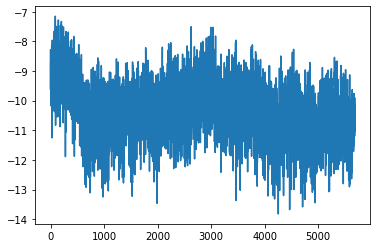

In [3]:
plt.plot(reward_records)

In [4]:
import misc

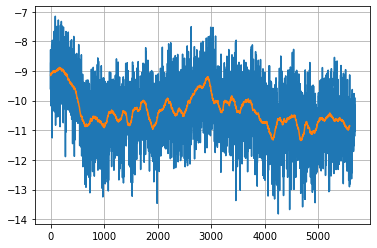

In [5]:
plt.plot(reward_records)
plt.plot(misc.smooth(reward_records,100))
plt.grid()


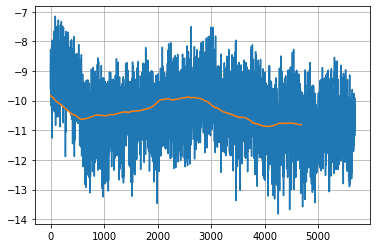

In [12]:
plt.plot(reward_records)
plt.plot(misc.smooth(reward_records,1000))
plt.grid()

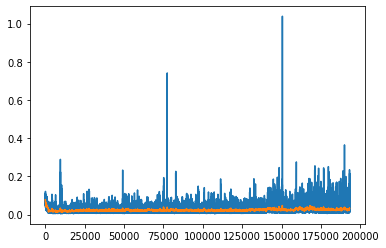

In [6]:
plt.plot(buffer.critic_loss_buffer[100:])
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],100))

In [ ]:
plt.plot(buffer.critic_loss_buffer[:10])


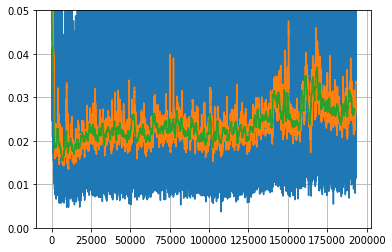

In [16]:
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],1))
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],100))
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],1000))
plt.ylim([0,0.05])
plt.grid()

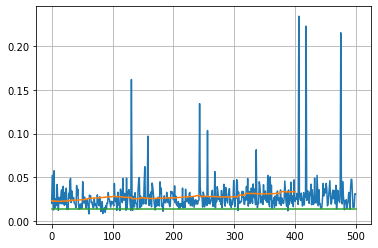

In [19]:
plt.plot(misc.smooth(buffer.critic_loss_buffer[-500:],1))
plt.plot(misc.smooth(buffer.critic_loss_buffer[-500:],100))
plt.plot(misc.smooth(buffer.critic_loss_buffer[-500:],1000))
plt.grid()

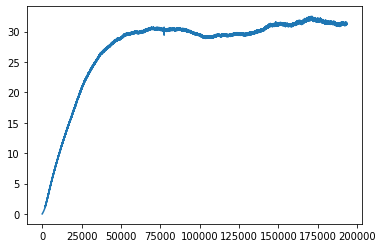

In [7]:
plt.plot(buffer.actor_loss_buffer[100:])


In [11]:
deterministic_action.numpy()

array([[0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.

In [9]:
deterministic_action.numpy().var(axis=0)

array([2.220446e-16, 0.000000e+00], dtype=float32)

In [20]:
env.timestep

16

In [21]:
state, reward, done, info = env.step(action)


In [22]:
deterministic_action2 = policy(env.unflatten_observation(prev_state), actor_model, lower_bound, upper_bound)


In [23]:
deterministic_action2.numpy()

array([[0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.03413263, 2.        ],
       [0.

In [26]:
policy(env.unflatten_observation(0.0*prev_state), actor_model, lower_bound, upper_bound)

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.        ],
       [0.03426299, 2.     

In [49]:
for k_state in range(-3,4):
    for k_act in range(-3,4):
        print(k_state,k_act,critic_model([env.unflatten_observation(k_state*prev_state),
                      k_act*deterministic_action]).numpy()[:5].T)

-3 -3 [[-31.97099  -32.261547 -32.940937 -32.10326  -31.976463]]
-3 -2 [[-31.490364 -31.780922 -32.460403 -31.622227 -31.495842]]
-3 -1 [[-31.471153 -31.761711 -32.44024  -31.603233 -31.47663 ]]
-3 0 [[-31.45742  -31.748259 -32.4258   -31.590052 -31.463177]]
-3 1 [[-31.442963 -31.73479  -32.411343 -31.576853 -31.449709]]
-3 2 [[-31.487907 -31.780512 -32.456287 -31.623    -31.495737]]
-3 3 [[-31.74645  -32.039055 -32.71483  -31.883142 -31.755527]]
-2 -3 [[-31.813843 -31.91971  -32.298603 -31.954432 -31.90005 ]]
-2 -2 [[-31.33322  -31.439089 -31.818075 -31.47381  -31.419428]]
-2 -1 [[-31.314009 -31.419876 -31.797909 -31.454596 -31.400215]]
-2 0 [[-31.300552 -31.406424 -31.783468 -31.441145 -31.386763]]
-2 1 [[-31.286682 -31.39286  -31.76901  -31.427677 -31.373295]]
-2 2 [[-31.331627 -31.437807 -31.813957 -31.473705 -31.419323]]
-2 3 [[-31.59017  -31.69635  -32.0725   -31.733498 -31.677965]]
-1 -3 [[-31.767418 -31.775217 -31.859217 -31.826561 -31.809666]]
-1 -2 [[-31.286892 -31.294693 -31

In [53]:
for k_state in range(-3,4):
    for k_act in range(-3,4):
        print(k_state,k_act,critic_model([env.unflatten_observation(k_state*state),
                      k_act*deterministic_action]).numpy()[:5].T)

-3 -3 [[-40.478954 -40.124733 -41.429096 -39.915585 -39.990974]]
-3 -2 [[-39.99843  -39.64421  -40.948574 -39.434563 -39.50998 ]]
-3 -1 [[-39.978268 -39.624046 -40.92841  -39.41557  -39.49099 ]]
-3 0 [[-39.96382  -39.6096   -40.913963 -39.40238  -39.477688]]
-3 1 [[-39.949364 -39.595146 -40.89951  -39.389187 -39.463894]]
-3 2 [[-39.994312 -39.64009  -40.944458 -39.435333 -39.50884 ]]
-3 3 [[-40.252853 -39.898632 -41.202995 -39.695477 -39.76738 ]]
-2 -3 [[-34.71364  -34.370388 -35.018116 -34.529224 -34.479378]]
-2 -2 [[-34.233017 -33.889732 -34.53719  -34.048195 -33.998352]]
-2 -1 [[-34.213814 -33.8697   -34.517242 -34.02921  -33.979362]]
-2 0 [[-34.20035  -33.85525  -34.503067 -34.016014 -33.966175]]
-2 1 [[-34.18613  -33.8408   -34.48888  -34.002827 -33.95298 ]]
-2 2 [[-34.23108  -33.885746 -34.533947 -34.048973 -33.999123]]
-2 3 [[-34.489616 -34.144287 -34.79284  -34.309116 -34.258892]]
-1 -3 [[-32.889267 -32.720966 -32.61835  -32.954227 -32.78369 ]]
-1 -2 [[-32.408638 -32.240337 -32

In [60]:
print('----------')
print(critic_model([env.unflatten_observation(state),
                      deterministic_action]).numpy()[:5].T)
print(critic_model([env.unflatten_observation(state),
                      -deterministic_action]).numpy()[:5].T)

----------
[[-31.131256 -31.140306 -31.624422 -30.82772  -31.110796]]
[[-31.160156 -31.169205 -31.65332  -30.856617 -31.139694]]


In [64]:
for ii in range(15):
    state, reward, done, info = env.step(action)
    print('----------')
    print(reward.numpy()[:5])
    print(critic_model([env.unflatten_observation(state),
                          deterministic_action]).numpy()[:5].T)
    print(critic_model([env.unflatten_observation(state),
                          -deterministic_action]).numpy()[:5].T)

----------
[-0.25897443 -0.22049017 -0.29683337 -0.26510084 -0.19744492]
[[-31.112778 -31.162203 -31.388891 -30.927145 -31.137737]]
[[-31.141678 -31.191101 -31.41779  -30.956041 -31.166636]]
----------
[-0.26170704 -0.2291641  -0.23050076 -0.2567824  -0.20017366]
[[-31.147194 -31.21526  -31.204357 -31.031637 -31.143684]]
[[-31.176094 -31.24416  -31.233255 -31.060534 -31.172583]]
----------
[-0.27107185 -0.2308561  -0.19465722 -0.25162047 -0.20245437]
[[-31.183912 -31.253164 -31.105652 -31.278894 -31.138187]]
[[-31.212812 -31.282063 -31.134548 -31.307795 -31.167088]]
----------
[-0.28705966 -0.22579405 -0.17685074 -0.25978473 -0.20179857]
[[-31.336113 -31.296139 -31.071959 -31.541742 -31.136497]]
[[-31.365013 -31.325039 -31.100859 -31.570642 -31.165398]]
----------
[-0.28015262 -0.2339486  -0.16564453 -0.277576   -0.2054661 ]
[[-31.427515 -31.390512 -31.05582  -31.797134 -31.145256]]
[[-31.456415 -31.419413 -31.084717 -31.826033 -31.174154]]
----------
[-0.29595858 -0.25177944 -0.188056

In [63]:
reward.numpy()[:5]

array([-0.27048308, -0.21970658, -0.38258746, -0.2539218 , -0.19663411],
      dtype=float32)

In [66]:
state[-1]

<tf.Tensor: shape=(50221,), dtype=float32, numpy=
array([3.4081340e-02, 2.9346067e-02, 2.5266375e-02, ..., 2.1596621e+01,
       2.2673790e+01, 3.2000000e+01], dtype=float32)>